# kd_plots.ipynb

Plots to quantify the kinematic distance method accuracy.

Contains:
- Face on view in Galactocentric Cartesian frame
- Face on view of difference between kd - plx distances in Galactocentric Cartesian frame
- Histogram of differences
- Histogram of differences / combined uncertainty
- CDF of differences / combined uncertainty.

Usage:
1. Run the first 2 cells
2. Run the 2 cells under `Using vlsr_tol` or `Using bimodal classification` headers
3. Use whatever file generated to plot figures using code under `General plotting function
   using pickled data` header
4. Identify outliers and re-plot using code under `Plots after removing outliers`

Isaac Cheng - April 2021

In [1]:
import sys
from pathlib import Path
import dill
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import gaussian_kde, kstest
from scipy.signal import argrelmax
from re import search  # for regex

# Want to add my own programs as package:
# Make a $PATH to coop2021
_SCRIPT_DIR = str(Path.cwd().parent)
# Add coop2021 to $PATH
sys.path.append(_SCRIPT_DIR)

import mytransforms as trans

# WC21 A6 rotation model parameters
_R0 = 8.1746
_USUN = 10.879
_VSUN = 10.697
_WSUN = 8.088
_ROLL = -0.011
_ZSUN = 5.399

In [2]:
def gaussian_cdf(x, mu=0, sigma=1):
    """
    Computes the cumulative distribution function (CDF)
    of the normal distribution at x.
    The standard normal distribution has mu=0, sigma=1.
    """
    cdf = 0.5 * (1 + erf((x - mu) / (sigma * np.sqrt(2))))
    return cdf

# Using `vlsr_tol`

In [3]:
def assign_kd_distances(database_data, kd_results, vlsr_tol=20,
                        gc_threshold=15):
      """
      Returns the closest near/far kinematic distance to parallax distance.
      
      Method:
      1. If -ve velocity in Q1/Q2 or +ve velocity in Q3/Q4, use far distance.
      2. Elif vlsr (km/s) is within vlsr_tol (km/s) of tangent point vlsr,
            use the tangent point vlsr.
      3. Else, assign either near/far/tangent distance based on whichever is closer
            to parallax-derived distance. 

      Inputs:
            database_data :: pandas DataFrame
            kd_results :: pandas DataFrame
            vlsr_tol :: scalar
            gc_threshold :: scalar (deg; for determining unreliable sources)
      """
      glong = database_data["glong"].values
      vlsr = database_data["vlsr_med"].values
      peak_dist = database_data["dist_mode"].values
      # 
      # Check for -ve vlsr in Q1/2, +ve vlsr in Q3/4
      # 
      is_q12 = (glong >= 0) & (glong < 180)
      is_q34 = (glong >= 180) & (glong < 360)
      use_far = (((vlsr < 0) & (is_q12)) | ((vlsr > 0) & (is_q34))) & \
                (~np.isnan(kd_results["far"]))
      print("Number of sources automatically assigned to far distance:",
            np.sum(use_far))
      #
      # Assign tangent kd to any source with vlsr w/in vlsr_tol of tangent vlsr
      #
      # 1st quadrant
      is_q1 = (glong >= 0) & (glong <= 90)
      use_tan_q1 = (vlsr) > (kd_results["vlsr_tangent"] - vlsr_tol)
      # 4th quadrant
      is_q4 = (glong >= 270) & (glong < 360)
      use_tan_q4 = (vlsr) < (kd_results["vlsr_tangent"] + vlsr_tol)
      use_tangent = ((is_q1) & (use_tan_q1)) | ((is_q4) & (use_tan_q4))
      print("Number of sources automatically assigned to tangent based on vlsr_tol:",
            np.sum((use_tangent) & (~use_far)))
      #
      # Otherwise, select kd that is closest to distance from parallax
      #
      # peak_dist = plx_to_peak_dist(plx, e_plx)
      near_err = abs(kd_results["near"] - peak_dist)
      far_err = abs(kd_results["far"] - peak_dist)
      tangent_err = abs(kd_results["tangent"] - peak_dist)
      min_err = np.fmin.reduce([near_err, far_err, tangent_err])  # ignores NaNs
      # Select distance corresponding to smallest error
      # tol = 1e-9  # tolerance for float equality
      # is_near = (abs(near_err - min_err) < tol) & (~use_tangent)
      # is_far = (abs(far_err - min_err) < tol) & (~use_tangent)
      # is_tangent = (abs(tangent_err - min_err) < tol) | (use_tangent)
      # 
      # If assigning minimum near/far/tangent error
      # is_near = (near_err == min_err) & (~use_tangent) & (~use_far)
      # is_far = (far_err == min_err) & (~use_tangent) | (use_far)
      # is_tangent = ((tangent_err == min_err) | (use_tangent)) & (~use_far)
      # is_near = (abs(near_err - min_err) < tol) & (~use_tangent) & (~use_far)
      # is_far = (abs(far_err - min_err) < tol) & (~use_tangent) | (use_far)
      # is_tangent = ((abs(tangent_err - min_err) < tol) | (use_tangent)) & (~use_far)
      # 
      # If assigning only minimum near/far error
      is_near = ((near_err < far_err) & (~use_tangent) & (~use_far)) | \
                ((np.isnan(far_err)) & (~np.isnan(near_err)) & (~use_tangent))
      is_far = ((far_err < near_err) & (~use_tangent)) | (use_far) | \
               ((np.isnan(near_err)) & (~np.isnan(far_err)) & (~use_tangent))
      is_tangent = ((use_tangent) & (~use_far)) | \
                   ((np.isnan(near_err)) & (np.isnan(far_err)))
      conditions = [is_near, is_far, is_tangent]
      choices = [kd_results["near"], kd_results["far"], kd_results["tangent"]]
      dists = np.select(conditions, choices, default=np.nan)
      nan_dist = np.isnan(dists)
      # 
      # print("Index of nan:", np.argwhere(nan_dist))
      # print("Arrays at nan:", is_near[nan_dist], is_far[nan_dist], is_tangent[nan_dist],
      #       use_far[nan_dist], use_tangent[nan_dist], min_err[nan_dist],
      #       near_err[nan_dist], far_err[nan_dist], tangent_err[nan_dist])
      # 
      # Exclude any sources w/in 15(?) deg of GC or 20 deg of GAC
      glong[glong > 180] -= 360  # force -180 < glong <= 180
      is_unreliable = (abs(glong) < gc_threshold) | (abs(glong) > 160.)
      #
      # Print some stats
      #
      print("=" * 6)
      is_nan = (~is_near) & (~is_far) & (~is_tangent)
      # num_sources = np.sum(np.isfinite(dists)) + np.sum((is_unreliable) & (~is_nan)) - \
      #               np.sum((np.isfinite(dists)) & ((is_unreliable) & (~is_nan)))
      num_sources = np.sum(np.isfinite(dists))
      # print(dists[~np.isfinite(dists)])
      print("Total number of (non NaN) sources:", num_sources)
      print(f"Num near: {np.sum((is_near) & (~is_unreliable))}"
            + f"\tNum far: {np.sum((is_far) & (~is_unreliable))}"
            + f"\tNum tangent: {np.sum((is_tangent) & (~is_unreliable))}"
            + f"\tNum unreliable: {np.sum((is_unreliable) & (~is_nan))}")
      print("Number of NaN sources (i.e. all dists are NaNs):", np.sum(is_nan))
      print("Num NaNs in near, far, tangent:",
            np.sum(np.isnan(near_err)), np.sum(np.isnan(far_err)),
            np.sum(np.isnan(tangent_err)))
      print("Number of sources with NaN in both 'near' and 'far':",
            sum(np.isnan(kd_results["near"]) & np.isnan(kd_results["far"])))
      print("Number of sources with NaN in both 'near' and 'tangent':",
            sum(np.isnan(kd_results["near"]) & np.isnan(kd_results["tangent"])))
      print("Number of sources with NaN in both 'far' and 'tangent':",
            sum(np.isnan(kd_results["far"]) & np.isnan(kd_results["tangent"])))
      # Print following if two distances are selected:
      num_near_far = np.sum((is_near) & (is_far))
      num_near_tan = np.sum((is_near) & (is_tangent))
      num_far_tan = np.sum((is_far) & (is_tangent))
      if any([num_near_far, num_near_tan, num_far_tan]):
            print("Both near and far (should be 0):", num_near_far)
            print("Both near and tan (should be 0):", num_near_tan)
            print("Both far and tan (should be 0):", num_far_tan)
      #
      # Get corresponding kd errors
      #
      e_near = 0.5 * (kd_results["near_err_pos"] + kd_results["near_err_neg"])
      e_far = 0.5 * (kd_results["far_err_pos"] + kd_results["far_err_neg"])
      # Use half the distance between max far & min near KDs as tangent error
      e_tan = 0.5 * (kd_results["far"] + kd_results["far_err_pos"] - kd_results["near"] + kd_results["near_err_neg"])
      e_tan_isnan = np.isnan(e_tan)
      # Use distance HPD if either near or far has NaNs
      e_tan[e_tan_isnan] = 0.5 * (kd_results["distance_err_pos"][e_tan_isnan] + kd_results["distance_err_neg"][e_tan_isnan])
      e_conditions = [is_near, is_far, is_tangent]
      e_choices = [e_near, e_far, e_tan]
      e_dists = np.select(e_conditions, e_choices, default=np.nan)
      print("Num of NaN errors (i.e. all errors are NaNs):", np.sum(np.isnan(e_dists)))

      return dists, e_dists, is_near, is_far, is_tangent, is_unreliable

In [4]:
def plots_vlsrtol(
    kdfile,
    vlsr_tol=20,
    gc_threshold=15,
    plot_figs=True,
    save_figs=True,
    print_stats=False,
    save_pkl=True,
):
    print("KDFILE INPUT:", kdfile)
    #
    # Load plx data
    #
    plxfile = Path("pec_motions/csvfiles/alldata_HPDmode_NEW2.csv")
    plxdata = pd.read_csv(Path.cwd().parent / plxfile)
    dist_plx = plxdata["dist_mode"].values
    e_dist_plx = plxdata["dist_halfhpd"].values
    #
    # RegEx stuff
    #
    # Find num_samples in kd
    num_samples = int(search("(\d+)x", kdfile).group(1))
    # Find if kd used kriging
    use_kriging = search("krige(.+?)", kdfile).group(1)
    use_kriging = use_kriging.lower() == "t"
    # Find if kd used peculiar motions
    use_peculiar = search("_pec(.+?)", kdfile).group(1)
    use_peculiar = use_peculiar.lower() == "t"
    # Find rotcurve used
    rotcurve = kdfile.split("_", 1)[0].replace(".", "") + "_"
    # Find normalization factor
    try:
        norm_factor = int(search("norm(\d+)", kdfile).group(1))
    except AttributeError:
        norm_factor = None
    # Find if kd included streaming motion uncertainty in e_vlsr
    try:
        streaming_mot = float(search("revLsr([-+]?\d*\.\d+|\d+)", kdfile).group(1))
        if streaming_mot.is_integer():
            streaming_mot = int(streaming_mot)
    except AttributeError:
        streaming_mot = None
    # Append info to figure names
    if norm_factor is None:
        figname_append = (
            f"_{num_samples}x_pec{use_peculiar}_krige{use_kriging}"
            + f"_vlsrTolerance{vlsr_tol}_revLsr{streaming_mot}.pdf"
        )
    else:
        figname_append = (
            f"_{num_samples}x_pec{use_peculiar}_krige{use_kriging}"
            + f"_norm{norm_factor}_vlsrTolerance{vlsr_tol}_revLsr{streaming_mot}.pdf"
        )
    #
    # Print stats
    #
    print("=" * 6)
    print("Number of MC kd samples:", num_samples)
    print("Including peculiar motions in kd:", use_peculiar)
    print("Using kriging:", use_kriging)
    print("Normalization factor:", norm_factor)
    print("vlsr tolerance (km/s):", vlsr_tol)
    print(
        "Sources deemed unreliable within ___ deg of galactic centre direction:",
        gc_threshold,
    )
    print("Streaming motion uncertainty factor (km/s):", streaming_mot)
    print("=" * 6)
    #
    # Load kd data using vlsr_tol
    #
    # kddata = pd.read_csv(Path.cwd() / kdfile)
    # Load pickle file with kd results
    with open(Path.cwd() / kdfile, "rb") as f:
        kddata = dill.load(f)["kd"]
    dist_kd, e_dist_kd, is_near, is_far, is_tangent, is_unreliable = assign_kd_distances(
        plxdata, kddata, vlsr_tol=vlsr_tol, gc_threshold=gc_threshold
    )
    #
    # Create face-on map with kinematic distances
    #
    # Convert to galactocentric frame
    glong = plxdata["glong"].values
    glat = plxdata["glat"].values
    Xb, Yb, Zb = trans.gal_to_bary(glong, glat, dist_kd)
    Xg, Yg, Zg = trans.bary_to_gcen(Xb, Yb, Zb, R0=_R0, Zsun=_ZSUN, roll=_ROLL)
    # Rotate 90 deg CW (so Sun is on +y-axis)
    Xg, Yg = Yg, -Xg
    #
    fig, ax = plt.subplots()
    size_scale = 4  # scaling factor for size
    #
    ax.scatter(
        Xg[(is_near) & (~is_unreliable)],
        Yg[(is_near) & (~is_unreliable)],
        c="tab:cyan",
        s=e_dist_kd[(is_near) & (~is_unreliable)] * size_scale,
        label="Near",
    )
    #
    ax.scatter(
        Xg[(is_far) & (~is_unreliable)],
        Yg[(is_far) & (~is_unreliable)],
        c="tab:purple",
        s=e_dist_kd[(is_far) & (~is_unreliable)] * size_scale,
        label="Far",
    )
    #
    ax.scatter(
        Xg[(is_tangent) & (~is_unreliable)],
        Yg[(is_tangent) & (~is_unreliable)],
        c="tab:green",
        s=e_dist_kd[(is_tangent) & (~is_unreliable)] * size_scale,
        label="Tangent",
    )
    #
    ax.scatter(
        Xg[is_unreliable],
        Yg[is_unreliable],
        c="tab:red",
        s=e_dist_kd[is_unreliable] * size_scale,
        label="Unreliable",
    )
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = rotcurve + "faceonplx" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    #
    # Calculate difference between kd and plx distances
    #
    dist_diff = dist_kd - dist_plx
    e_dist_diff = np.sqrt(e_dist_plx ** 2 + e_dist_kd ** 2)
    #
    # Plot
    #
    # Face on view of differences
    fig, ax = plt.subplots()
    #
    cmap = "viridis"
    norm = mpl.colors.Normalize(
        vmin=np.nanmin(dist_diff[~is_unreliable]),
        vmax=np.nanmax(dist_diff[~is_unreliable]),
    )
    ax.scatter(
        Xg[~is_unreliable],
        Yg[~is_unreliable],
        c=dist_diff[~is_unreliable],
        s=e_dist_diff[~is_unreliable] * size_scale,
        cmap=cmap,
        norm=norm,
    )
    ax.scatter(
        Xg[is_unreliable],
        Yg[is_unreliable],
        c="grey",
        s=e_dist_diff[is_unreliable] * size_scale,
        label="Unreliable",
    )
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.ax.set_ylabel(r"$d_{\rm kd} - d_\pi$ (kpc)", rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = rotcurve + "faceonplxDiffs" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # Histogram of differences
    fig, ax = plt.subplots()
    ax.hist(dist_diff[~is_unreliable], bins=15, histtype="step", color="k", alpha=0.5)
    median_diff = np.median(dist_diff[~is_unreliable])
    ax.axvline(median_diff, color="k")
    print("=" * 6)
    print("Median difference b/w kd and parallax-derived distances (kpc)", median_diff)
    print(
        "Min & Max differences (kpc):",
        np.min(dist_diff[~is_unreliable]),
        np.max(dist_diff[~is_unreliable]),
    )
    print(
        "Min & Max abs(differences) (kpc):",
        np.min(abs(dist_diff[~is_unreliable])),
        np.max(abs(dist_diff[~is_unreliable])),
    )
    # KDE
    kde = gaussian_kde(dist_diff[~is_unreliable])
    xlabels = [-5, 0, 5]
    diffs = np.linspace(xlabels[0], xlabels[-1], 200)
    kde = kde(diffs)
    ax.plot(diffs, kde * np.sum(kde) * 3, color="k")
    ax.set_xlabel(r"$d_{\rm kd} - d_\pi$ (kpc)")
    ax.set_ylabel("Frequency")
    ax.set_xticks(xlabels)
    figname = rotcurve + "kd_plx_diff_hist" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # CDF of differences over total error
    fig, ax = plt.subplots()
    xlims = (-3, 3)
    cdf_x = np.linspace(*xlims)
    ax.plot(cdf_x, gaussian_cdf(cdf_x), "k--")
    cdf_data = np.sort(dist_diff[~is_unreliable] / e_dist_diff[~is_unreliable])
    ax.plot(cdf_data, np.arange(cdf_data.size) / cdf_data.size, "k-")
    # ax.set_xlim(*xlims)
    ax.set_xlabel(r"$(d_{\rm kd} - d_\pi) / \sqrt{\sigma^2_{\rm kd} + \sigma^2_\pi}$")
    ax.set_ylabel("CDF")
    figname = rotcurve + "kd_plx_diff_CDF" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    #
    # K-S test
    #
    print(
        "======\n",
        kstest(cdf_data, gaussian_cdf, N=cdf_data.size, mode="exact"),
        "\n======",
    )
    if save_pkl:
        # Save pickle file
        pklfile = f"vlsrtol_{rotcurve[:-1]}" + figname_append[:-3] + "pkl"
        with open(Path.cwd() / pklfile, "wb") as f:
            dill.dump(
                {
                    "plxdata": plxdata,
                    "kddata": kddata,
                    "dist_kd": dist_kd,
                    "e_dist_kd": e_dist_kd,
                    "is_near": is_near,
                    "is_far": is_far,
                    "is_tangent": is_tangent,
                    "is_unreliable": is_unreliable,
                    "vlsr_tol": vlsr_tol,
                    "gc_threshold": gc_threshold,
                },
                f,
            )
        print("Saved pickle file!")
    if print_stats:
        #
        # Print stats
        #
        kdtypes = [
            (is_near) & (~is_unreliable),
            (is_far) & (~is_unreliable),
            (is_tangent) & (~is_unreliable),
            is_unreliable,
        ]
        kdnames = ["Near", "Far", "Tangent", "Unreliable"]
        for kdtype, kdname in zip(kdtypes, kdnames):
            print("=" * 3, kdname + " sources", "=" * 3)
            df_plx = plxdata[["gname", "glong", "glat", "vlsr_med", "dist_mode"]][kdtype]
            df_kd = kddata[["near", "far", "tangent", "vlsr_tangent"]][kdtype]
            df_tot = pd.concat([df_plx, df_kd], axis=1)
            print(df_tot.to_string())
            print(f"Number of {kdname} sources:", len(df_tot))
            print()


KDFILE INPUT: wc21_kd_1000x_pecTrue_krigeTrue_norm20.0.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
vlsr tolerance (km/s): 10
Sources deemed unreliable within ___ deg of galactic centre direction: 15
Streaming motion uncertainty factor (km/s): None
Number of sources automatically assigned to far distance: 69
Number of sources automatically assigned to tangent based on vlsr_tol: 52
Total number of (non NaN) sources: 202
Num near: 34	Num far: 75	Num tangent: 46	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 58 4 51
Number of sources with NaN in both 'near' and 'far': 3
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0
Num of NaN errors (i.e. all errors are NaNs): 0


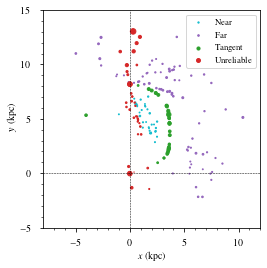

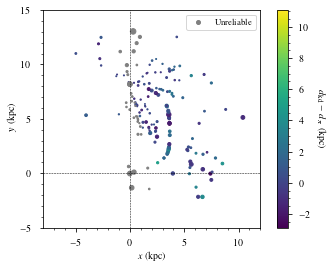

Median difference b/w kd and parallax-derived distances (kpc) 0.3694384384384346
Min & Max differences (kpc): -2.864996996997 11.079546546546533
Min & Max abs(differences) (kpc): 0.0016566566566544871 11.079546546546533


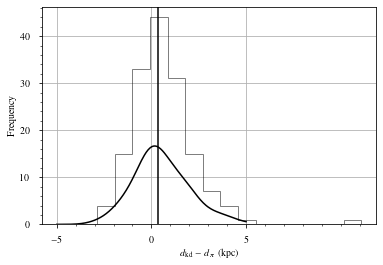

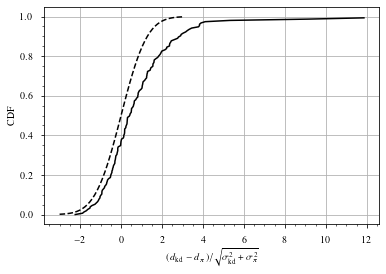

 KstestResult(statistic=0.2076281862053082, pvalue=2.4427135931032203e-06) 
Saved pickle file!


In [57]:
kdfile_input = "wc21_kd_1000x_pecTrue_krigeTrue_norm20.0.pkl"
plots_vlsrtol(kdfile_input, vlsr_tol=10, gc_threshold=15, plot_figs=True,
              save_figs=False, print_stats=False, save_pkl=True)

KDFILE INPUT: wc21_kd_1000x_pecTrue_krigeTrue_norm20.0_revLsr5.0.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
vlsr tolerance (km/s): 10
Sources deemed unreliable within ___ deg of galactic centre direction: 15
Streaming motion uncertainty factor (km/s): 5
Number of sources automatically assigned to far distance: 69
Number of sources automatically assigned to tangent based on vlsr_tol: 50
Total number of (non NaN) sources: 202
Num near: 35	Num far: 76	Num tangent: 44	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 57 3 51
Number of sources with NaN in both 'near' and 'far': 2
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0
Num of NaN errors (i.e. all errors are NaNs): 0


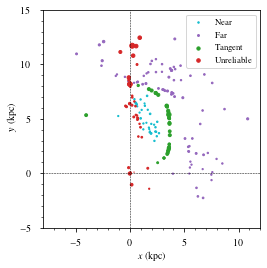

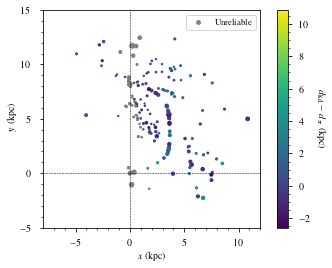

Median difference b/w kd and parallax-derived distances (kpc) 0.35779879879879317
Min & Max differences (kpc): -2.5693173173173207 10.84927327327326
Min & Max abs(differences) (kpc): 0.0015315315315329592 10.84927327327326


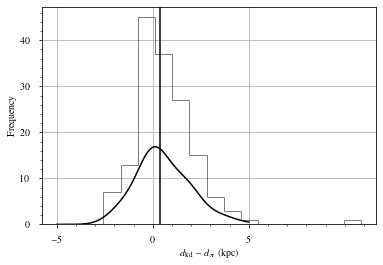

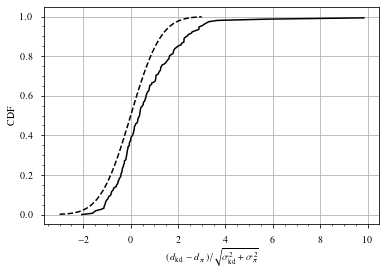

 KstestResult(statistic=0.1743484046004823, pvalue=0.00013662683595255324) 
Saved pickle file!


In [74]:
kdfile_input = "wc21_kd_1000x_pecTrue_krigeTrue_norm20.0_revLsr5.0.pkl"
plots_vlsrtol(kdfile_input, vlsr_tol=10, gc_threshold=15, plot_figs=True,
              save_figs=False, print_stats=False, save_pkl=True)

KDFILE INPUT: wc21_kd_1000x_pecTrue_krigeTrue_norm20.0_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
vlsr tolerance (km/s): 10
Sources deemed unreliable within ___ deg of galactic centre direction: 15
Streaming motion uncertainty factor (km/s): 7.5
Number of sources automatically assigned to far distance: 70
Number of sources automatically assigned to tangent based on vlsr_tol: 52
Total number of (non NaN) sources: 202
Num near: 34	Num far: 75	Num tangent: 46	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 55 2 51
Number of sources with NaN in both 'near' and 'far': 2
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0
Num of NaN errors (i.e. all errors are NaNs): 0


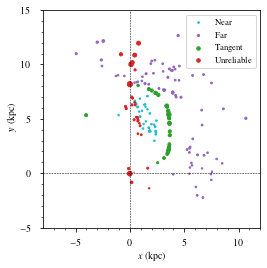

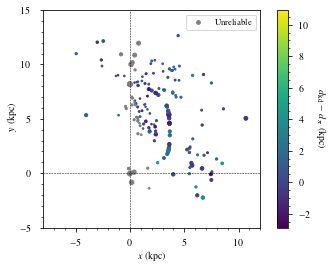

Median difference b/w kd and parallax-derived distances (kpc) 0.3955125125125072
Min & Max differences (kpc): -2.8805895895895937 10.927186186186175
Min & Max abs(differences) (kpc): 0.006180180180185957 10.927186186186175


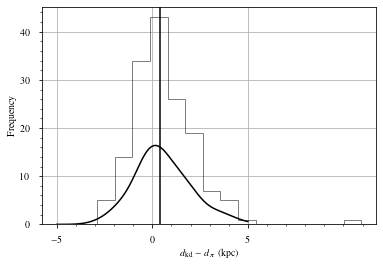

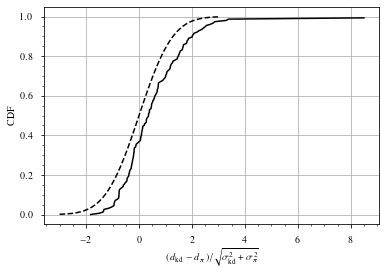

 KstestResult(statistic=0.1540993987429521, pvalue=0.0011133499536051905) 
Saved pickle file!


In [77]:
kdfile_input = "wc21_kd_1000x_pecTrue_krigeTrue_norm20.0_revLsr7.5.pkl"
plots_vlsrtol(kdfile_input, vlsr_tol=10, gc_threshold=15, plot_figs=True,
              save_figs=False, print_stats=False, save_pkl=True)

KDFILE INPUT: wc21pec2_kd_1000x_pecTrue_krigeTrue_norm20.0_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: False
Using kriging: True
Normalization factor: 20
vlsr tolerance (km/s): 10
Sources deemed unreliable within ___ deg of galactic centre direction: 15
Streaming motion uncertainty factor (km/s): 7.5
Number of sources automatically assigned to far distance: 70
Number of sources automatically assigned to tangent based on vlsr_tol: 53
Total number of (non NaN) sources: 202
Num near: 33	Num far: 75	Num tangent: 47	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 55 2 51
Number of sources with NaN in both 'near' and 'far': 2
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0
Num of NaN errors (i.e. all errors are NaNs): 0


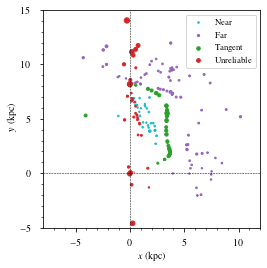

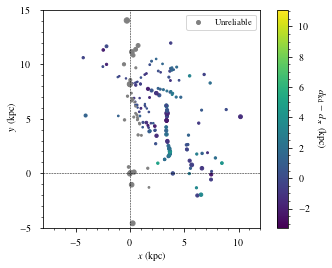

Median difference b/w kd and parallax-derived distances (kpc) 0.265080080080079
Min & Max differences (kpc): -3.247782782782786 11.071054054054041
Min & Max abs(differences) (kpc): 0.004429429429426257 11.071054054054041


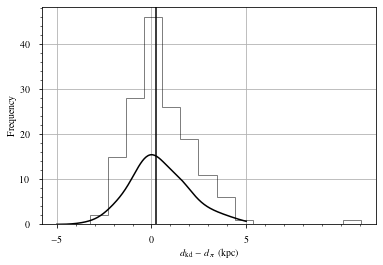

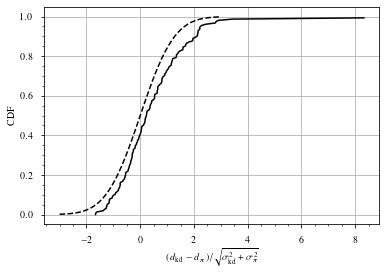

 KstestResult(statistic=0.12158094140715936, pvalue=0.01870117946478305) 
Saved pickle file!


In [5]:
kdfile_input = "wc21pec2_kd_1000x_pecTrue_krigeTrue_norm20.0_revLsr7.5.pkl"
plots_vlsrtol(kdfile_input, vlsr_tol=10, gc_threshold=15, plot_figs=True,
              save_figs=False, print_stats=False, save_pkl=True)

KDFILE INPUT: wc21pec3_kd_1000x_pecTrue_krigeTrue_norm20.0_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: False
Using kriging: True
Normalization factor: 20
vlsr tolerance (km/s): 10
Sources deemed unreliable within ___ deg of galactic centre direction: 15
Streaming motion uncertainty factor (km/s): 7.5
Number of sources automatically assigned to far distance: 70
Number of sources automatically assigned to tangent based on vlsr_tol: 56
Total number of (non NaN) sources: 202
Num near: 30	Num far: 75	Num tangent: 50	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 55 2 51
Number of sources with NaN in both 'near' and 'far': 2
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0
Num of NaN errors (i.e. all errors are NaNs): 0


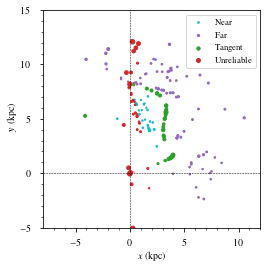

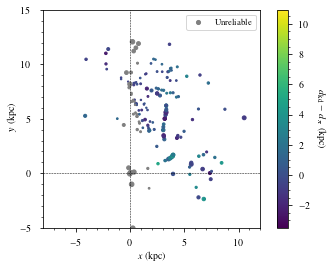

Median difference b/w kd and parallax-derived distances (kpc) 0.19062662662662566
Min & Max differences (kpc): -3.480851851851855 10.914588588588575
Min & Max abs(differences) (kpc): 0.0013473473473495368 10.914588588588575


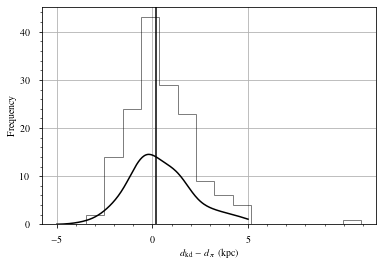

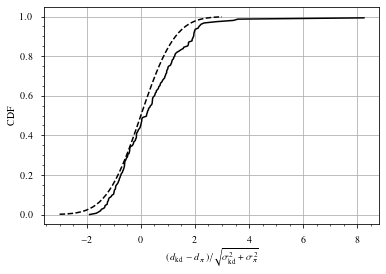

 KstestResult(statistic=0.12038422893811107, pvalue=0.020483493677088103) 
Saved pickle file!


In [5]:
kdfile_input = "wc21pec3_kd_1000x_pecTrue_krigeTrue_norm20.0_revLsr7.5.pkl"
plots_vlsrtol(kdfile_input, vlsr_tol=10, gc_threshold=15, plot_figs=True,
              save_figs=False, print_stats=False, save_pkl=True)

KDFILE INPUT: wc21_kd_1000x_pecTrue_krigeFalse_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: False
Normalization factor: None
vlsr tolerance (km/s): 10
Sources deemed unreliable within ___ deg of galactic centre direction: 15
Streaming motion uncertainty factor (km/s): 7.5
Number of sources automatically assigned to far distance: 70
Number of sources automatically assigned to tangent based on vlsr_tol: 49
Total number of (non NaN) sources: 202
Num near: 36	Num far: 76	Num tangent: 43	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 56 2 51
Number of sources with NaN in both 'near' and 'far': 2
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0
Num of NaN errors (i.e. all errors are NaNs): 0


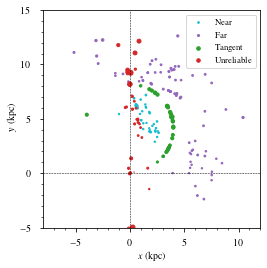

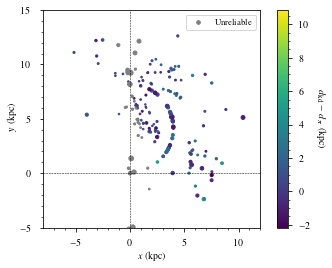

Median difference b/w kd and parallax-derived distances (kpc) 0.49047047047046677
Min & Max differences (kpc): -2.171962962962974 10.861148148148136
Min & Max abs(differences) (kpc): 0.002272272272270781 10.861148148148136


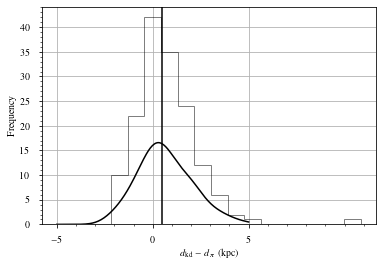

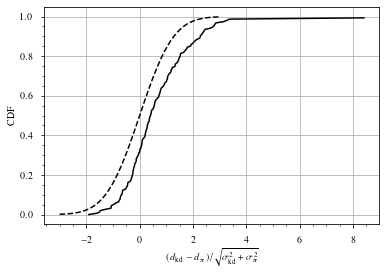

 KstestResult(statistic=0.19789367248612544, pvalue=8.54109040225781e-06) 
Saved pickle file!


In [6]:
kdfile_input = "wc21_kd_1000x_pecTrue_krigeFalse_revLsr7.5.pkl"
plots_vlsrtol(kdfile_input, vlsr_tol=10, gc_threshold=15, plot_figs=True,
              save_figs=False, print_stats=False, save_pkl=True)

KDFILE INPUT: reid14_kd_1000x_pecFalse_krigeFalse_revLsrNone.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: False
Using kriging: False
Normalization factor: None
vlsr tolerance (km/s): 10
Sources deemed unreliable within ___ deg of galactic centre direction: 15
Streaming motion uncertainty factor (km/s): None
Number of sources automatically assigned to far distance: 68
Number of sources automatically assigned to tangent based on vlsr_tol: 48
Total number of (non NaN) sources: 202
Num near: 38	Num far: 75	Num tangent: 42	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 58 4 51
Number of sources with NaN in both 'near' and 'far': 4
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0
Num of NaN errors (i.e. all errors are NaNs): 0


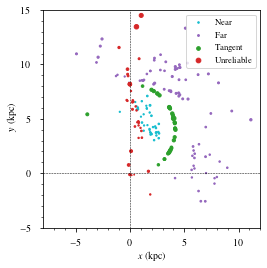

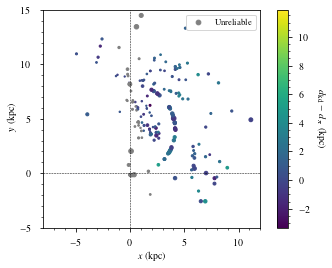

Median difference b/w kd and parallax-derived distances (kpc) 0.7060610610610591
Min & Max differences (kpc): -3.3111031031031057 11.876276276276263
Min & Max abs(differences) (kpc): 0.010831831831831007 11.876276276276263


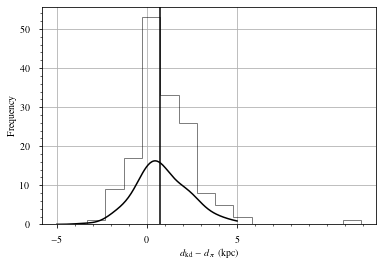

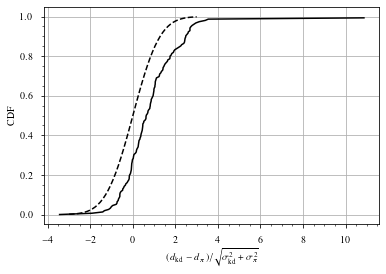

 KstestResult(statistic=0.2555539649063612, pvalue=2.0602859408268314e-09) 
Saved pickle file!


In [7]:
kdfile_input = "reid14_kd_1000x_pecFalse_krigeFalse_revLsrNone.pkl"
plots_vlsrtol(kdfile_input, vlsr_tol=10, gc_threshold=15,
              plot_figs=True, save_figs=False, print_stats=False, save_pkl=True)

# Using bimodal classification

In [8]:
def assign_kd_distances_bimodal(database_data, kd_results, trough_threshold=0.4,
                                gc_threshold=15):
    """
    Returns the closest kinematic distance to parallax distance.
    If the distance KDE has two peaks and the trough between them is at least
    trough_threshold times the height of the smaller peak, don't assign tangent.
    If the distance KDE has only 1 peak or the depth of the trough is less than
    the trough_threshold times the height of the smaller peak, assign tangent distance.

    Inputs:
      database_data :: pandas DataFrame
      kd_results :: pandas DataFrame
      trough_threshold :: scalar
      gc_threshold :: scalar (deg; for determining unreliable sources)
    """
    # 
    glong = database_data["glong"].values
    vlsr = database_data["vlsr_med"].values
    peak_dist = database_data["dist_mode"].values
    # 
    is_q23 = (glong > 90) & (glong < 270)
    is_q12 = (glong >= 0) & (glong < 180)
    is_q34 = (glong >= 180) & (glong < 360)
    use_far = (((vlsr < 0) & (is_q12)) | ((vlsr > 0) & (is_q34))) & \
            (~np.isnan(kd_results["far"]))
    print("Number of sources automatically assigned to far distance:",
        np.sum(use_far))
    # Load pickle file with KDEs
    # kdfile = kdfile[:-3] + "pkl"
    # with open(Path.cwd() / kdfile, "rb") as f:
    #     kd_results = dill.load(f)["kd"]
    # 
    # Load distance KDEs of all sources
    # 
    kdes = kd_results["distance_kde"]
    num_sources = len(kdes)
    print("num_sources", num_sources)
    # 
    # Find peaks in quadrants 1 & 4
    # 
    dists = np.arange(0.001, 20, 0.001)
    maxes = np.zeros(num_sources) * np.nan
    use_tangent = np.zeros(num_sources, bool)
    for i in range(num_sources):
        print("\rIteration", i, end="")
        # Skip sources in q2 & q3
        if is_q23[i] or use_far[i]:
            continue
        probs = kdes[i](dists)
        if np.sum(~np.isfinite(probs)):
            print("NaN or +/-np.inf found at index", i, "= source", database_data["gname"][i])
        max_idx = argrelmax(probs, mode="wrap")[0]
        num_max = len(max_idx)
        if num_max == 1:
            use_tangent[i] = True
            continue
        # Find if one peak is much larger than the rest
        peaks = probs[max_idx]
        max_peak = np.max(peaks)
        peak_diffs = max_peak - peaks[peaks != max_peak]
        # TODO: EXPERIMENT WITH THIS PARAMETER!
        if all(peak_diffs > 0.8 * max_peak):
            # "much larger" = at least 80% height of max_peak
            use_tangent[i] = True
        # if num_max < 1 or num_max > 2:
        #     print("At index", i, "= source", database_data["gname"][i])
        #     raise ValueError("Wrong number of maxima detected. Detected " + str(num_max) + " max!")
        else:
            # Choose 2 largest maxima
            second_max_peak = np.max(peaks[peaks != max_peak])
            max_idx = np.argwhere((probs == max_peak) | (probs == second_max_peak))
            if max_idx.size != 2:
                print("Index", i, "= source", database_data["gname"][i])
                raise ValueError("Wrong number of 2 largest maxima detected. Detected " + str(max_idx.size))
            between_maxes = (dists > dists[max_idx[0]]) & (dists < dists[max_idx[1]])
            min_prob = np.amin(probs, where=between_maxes, initial=np.inf)
            if min_prob.size != 1:
                raise ValueError("Wrong number of mins detected. Detected " + str(min_prob.size))
            # Check if min is between max_idx
            # min_idx = np.where(probs = min_prob)
            # Check if difference between peaks and trough is too small
            smaller_peak = np.min(probs[max_idx])
            diff = smaller_peak - min_prob
            if diff < trough_threshold * smaller_peak:
                use_tangent[i] = True
    print("\nNumber of sources automatically assigned to tangent based on KDE peaks:",
          np.sum(use_tangent))  
    #
    # Otherwise, select kd that is closest to distance from parallax
    #
    # peak_dist = plx_to_peak_dist(plx, e_plx)
    near_err = abs(kd_results["near"] - peak_dist)
    far_err = abs(kd_results["far"] - peak_dist)
    tangent_err = abs(kd_results["tangent"] - peak_dist)
    min_err = np.fmin.reduce([near_err, far_err, tangent_err])  # ignores NaNs
    # Select distance corresponding to smallest error
    # tol = 1e-9  # tolerance for float equality
    # is_near = (abs(near_err - min_err) < tol) & (~use_tangent)
    # is_far = (abs(far_err - min_err) < tol) & (~use_tangent)
    # is_tangent = (abs(tangent_err - min_err) < tol) | (use_tangent)
    # is_near = (near_err == min_err) & (~use_tangent)
    # is_far = (far_err == min_err) & (~use_tangent)
    # is_tangent = (tangent_err == min_err) | (use_tangent)
    # 
    # If assigning minimum near/far/tangent error
    # is_near = (near_err == min_err) & (~use_tangent) & (~use_far)
    # is_far = (far_err == min_err) & (~use_tangent) | (use_far)
    # is_tangent = ((tangent_err == min_err) | (use_tangent)) & (~use_far)
    # is_near = (abs(near_err - min_err) < tol) & (~use_tangent) & (~use_far)
    # is_far = (abs(far_err - min_err) < tol) & (~use_tangent) | (use_far)
    # is_tangent = ((abs(tangent_err - min_err) < tol) | (use_tangent)) & (~use_far)
    # 
    # If assigning only minimum near/far error
    is_near = ((near_err < far_err) & (~use_tangent) & (~use_far)) | \
            ((np.isnan(far_err)) & (~np.isnan(near_err)) & (~use_tangent))
    is_far = ((far_err < near_err) & (~use_tangent)) | (use_far) | \
            ((np.isnan(near_err)) & (~np.isnan(far_err)) & (~use_tangent))
    is_tangent = ((use_tangent) & (~use_far)) | \
                ((np.isnan(near_err)) & (np.isnan(far_err)))
    # 
    conditions = [is_near, is_far, is_tangent]
    choices = [kd_results["near"], kd_results["far"], kd_results["tangent"]]
    dists = np.select(conditions, choices, default=np.nan)
    nan_dist = np.isnan(dists)
    # Exclude any sources w/in 15(?) deg of GC or 20 deg of GAC
    glong[glong > 180] -= 360  # force -180 < glong <= 180
    is_unreliable = (abs(glong) < gc_threshold) | (abs(glong) > 160.)
    #
    # Print some stats
    #
    print("=" * 6)
    is_nan = (~is_near) & (~is_far) & (~is_tangent)
    # num_sources = np.sum(np.isfinite(dists)) + np.sum((is_unreliable) & (~is_nan)) - \
    #               np.sum((np.isfinite(dists)) & ((is_unreliable) & (~is_nan)))
    num_sources = np.sum(np.isfinite(dists))
    print("Total number of (non NaN) sources:", num_sources)
    print(f"Num near: {np.sum((is_near) & (~is_unreliable))}"
          + f"\tNum far: {np.sum((is_far) & (~is_unreliable))}"
          + f"\tNum tangent: {np.sum((is_tangent) & (~is_unreliable))}"
          + f"\tNum unreliable: {np.sum((is_unreliable) & (~is_nan))}")
    print("Number of NaN sources (i.e. all dists are NaNs):", np.sum(is_nan))
    print("Num NaNs in near, far, tangent:",
          np.sum(np.isnan(near_err)), np.sum(np.isnan(far_err)),
          np.sum(np.isnan(tangent_err)))
    print("Number of sources with NaN in both 'near' and 'far':",
          sum(np.isnan(kd_results["near"]) & np.isnan(kd_results["far"])))
    print("Number of sources with NaN in both 'near' and 'tangent':",
          sum(np.isnan(kd_results["near"]) & np.isnan(kd_results["tangent"])))
    print("Number of sources with NaN in both 'far' and 'tangent':",
          sum(np.isnan(kd_results["far"]) & np.isnan(kd_results["tangent"])))
    # Print following if two distances are selected:
    num_near_far = np.sum((is_near) & (is_far))
    num_near_tan = np.sum((is_near) & (is_tangent))
    num_far_tan = np.sum((is_far) & (is_tangent))
    if any([num_near_far, num_near_tan, num_far_tan]):
        print("Both near and far (should be 0):", num_near_far)
        print("Both near and tan (should be 0):", num_near_tan)
        print("Both far and tan (should be 0):", num_far_tan)
    #
    # Get corresponding kd errors
    #
    e_near = 0.5 * (kd_results["near_err_pos"] + kd_results["near_err_neg"])
    e_far = 0.5 * (kd_results["far_err_pos"] + kd_results["far_err_neg"])
    e_tan = 0.5 * (kd_results["distance_err_pos"] + kd_results["distance_err_neg"])
    e_conditions = [is_near, is_far, is_tangent]
    e_choices = [e_near, e_far, e_tan]
    e_dists = np.select(e_conditions, e_choices, default=np.nan)
    print("Num of NaN errors (i.e. all errors are NaNs):", np.sum(np.isnan(e_dists)))

    return dists, e_dists, is_near, is_far, is_tangent, is_unreliable

In [9]:
def plots_bimodal(kdfile, trough_threshold=0.4, gc_threshold=15,
                  save_figs=True, print_stats=False, save_pkl=True):
    print("FILE LOADED:", kdfile)
    #
    # Load plx data
    #
    plxfile = Path("pec_motions/csvfiles/alldata_HPDmode_NEW2.csv")
    plxdata = pd.read_csv(Path.cwd().parent / plxfile)
    dist_plx = plxdata["dist_mode"].values
    e_dist_plx = plxdata["dist_halfhpd"].values
    #
    # RegEx stuff
    #
    # Find num_samples in kd
    num_samples = int(search('(\d+)x', kdfile).group(1))
    # Find if kd used kriging
    use_kriging = search("krige(.+?)", kdfile).group(1)
    use_kriging = use_kriging.lower() == "t"
    # Find if kd used peculiar motions
    use_peculiar = search("_pec(.+?)", kdfile).group(1)
    use_peculiar = use_peculiar.lower() == "t"
    # Find rotcurve used
    rotcurve = kdfile.split('_', 1)[0].replace('.', '') + "_"
    # Find normalization factor
    try:
        norm_factor = int(search('norm(\d+)', kdfile).group(1))
    except AttributeError:
        norm_factor = None
    # Find if kd included streaming motion uncertainty in e_vlsr
    try:
        streaming_mot = float(search("revLsr([-+]?\d*\.\d+|\d+)", kdfile).group(1))
        if streaming_mot.is_integer():
            streaming_mot = int(streaming_mot)
    except AttributeError:
        streaming_mot = None
    # Append info to figure names
    if norm_factor is None:
        figname_append = f"_{num_samples}x_pec{use_peculiar}_krige{use_kriging}" + \
                         f"_trough{trough_threshold}_revLsr{streaming_mot}.pdf"
    else:
        figname_append = f"_{num_samples}x_pec{use_peculiar}_krige{use_kriging}" + \
                         f"_norm{norm_factor}_trough{trough_threshold}_revLsr{streaming_mot}.pdf"
    #
    # Print stats
    #
    print("=" * 6)
    print("Number of MC kd samples:", num_samples)
    print("Including peculiar motions in kd:", use_peculiar)
    print("Using kriging:", use_kriging)
    print("Normalization factor:", norm_factor)
    print("Trough threshold:", trough_threshold)
    print("Streaming motion uncertainty factor (km/s):", streaming_mot)
    print("=" * 6)
    #
    # Load kd data using bimodal KDE classification
    #
    # Load pickle file with kd results
    with open(Path.cwd() / kdfile, "rb") as f:
        kddata = dill.load(f)["kd"]
    print("Assigning kd distances using bimodal tangent criterion...")
    dist_kd, e_dist_kd, is_near, is_far, is_tangent, is_unreliable = assign_kd_distances_bimodal(
        plxdata, kddata, trough_threshold=trough_threshold, gc_threshold=gc_threshold)
    print("Done assigning kd distances using bimodal tangent criterion...")
    #
    # Create face-on map with kinematic distances
    #
    # Convert to galactocentric frame
    glong = plxdata["glong"].values
    glat = plxdata["glat"].values
    Xb, Yb, Zb = trans.gal_to_bary(glong, glat, dist_kd)
    Xg, Yg, Zg = trans.bary_to_gcen(Xb, Yb, Zb, R0=_R0, Zsun=_ZSUN, roll=_ROLL)
    # Rotate 90 deg CW (so Sun is on +y-axis)
    Xg, Yg = Yg, -Xg
    #
    fig, ax = plt.subplots()
    size_scale = 4  # scaling factor for size
    #
    ax.scatter(Xg[(is_near) & (~is_unreliable)], Yg[(is_near) & (~is_unreliable)],
            c="tab:cyan", s=e_dist_kd[(is_near) & (~is_unreliable)] * size_scale,
            label="Near")
    #
    ax.scatter(Xg[(is_far) & (~is_unreliable)], Yg[(is_far) & (~is_unreliable)],
            c="tab:purple", s=e_dist_kd[(is_far) & (~is_unreliable)] * size_scale,
            label="Far")
    #
    ax.scatter(Xg[(is_tangent) & (~is_unreliable)], Yg[(is_tangent) & (~is_unreliable)],
            c="tab:green", s=e_dist_kd[(is_tangent) & (~is_unreliable)] * size_scale,
            label="Tangent")
    #
    ax.scatter(Xg[is_unreliable], Yg[is_unreliable],
            c="tab:red", s=e_dist_kd[is_unreliable] * size_scale,
            label="Unreliable")
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = rotcurve + "faceonplx" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    #
    # Calculate difference between kd and plx distances
    #
    dist_diff = dist_kd - dist_plx
    e_dist_diff = np.sqrt(e_dist_plx**2 + e_dist_kd**2)
    #
    # Plot
    #
    # Face on view of differences
    fig, ax = plt.subplots()
    #
    cmap = "viridis"
    norm = mpl.colors.Normalize(vmin=np.nanmin(dist_diff[~is_unreliable]),
                                vmax=np.nanmax(dist_diff[~is_unreliable]))
    ax.scatter(Xg[~is_unreliable], Yg[~is_unreliable],
            c=dist_diff[~is_unreliable], s=e_dist_diff[~is_unreliable] * size_scale,
            cmap=cmap, norm=norm)
    ax.scatter(Xg[is_unreliable], Yg[is_unreliable],
            c="grey", s=e_dist_diff[is_unreliable] * size_scale, label="Unreliable")
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.ax.set_ylabel(r"$d_{\rm kd} - d_\pi$ (kpc)", rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = rotcurve + "faceonplxDiffs" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # Histogram of differences
    fig, ax = plt.subplots()
    ax.hist(dist_diff[~is_unreliable], bins=15, histtype="step", color="k", alpha=0.5)
    median_diff = np.median(dist_diff[~is_unreliable])
    ax.axvline(median_diff, color="k")
    print("=" * 6)
    print("Median difference b/w kd and parallax-derived distances (kpc)", median_diff)
    print("Min & Max differences (kpc):", np.min(dist_diff[~is_unreliable]),
            np.max(dist_diff[~is_unreliable]))
    print("Min & Max abs(differences) (kpc):", np.min(abs(dist_diff[~is_unreliable])),
            np.max(abs(dist_diff[~is_unreliable])))
    # KDE
    kde = gaussian_kde(dist_diff[~is_unreliable])
    xlabels = [-5, 0, 5]
    diffs = np.linspace(xlabels[0], xlabels[-1], 200)
    kde = kde(diffs)
    ax.plot(diffs, kde * np.sum(kde) * 3, color="k")
    ax.set_xlabel(r"$d_{\rm kd} - d_\pi$ (kpc)")
    ax.set_ylabel("Frequency")
    ax.set_xticks(xlabels)
    figname = rotcurve + "kd_plx_diff_hist" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # CDF of differences over total error
    fig, ax = plt.subplots()
    xlims = (-3, 3)
    cdf_x = np.linspace(*xlims)
    ax.plot(cdf_x, gaussian_cdf(cdf_x), "k--")
    cdf_data = np.sort(dist_diff[~is_unreliable]/e_dist_diff[~is_unreliable])
    ax.plot(cdf_data, np.arange(cdf_data.size)/cdf_data.size, "k-")
    # ax.set_xlim(*xlims)
    ax.set_xlabel(r"$(d_{\rm kd} - d_\pi) / \sqrt{\sigma^2_{\rm kd} + \sigma^2_\pi}$")
    ax.set_ylabel("CDF")
    figname = rotcurve + "kd_plx_diff_CDF" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    #
    # K-S test
    #
    print("======\n",
            kstest(cdf_data, gaussian_cdf, N=cdf_data.size, mode="exact"),
            "\n======")
    # 
    if save_pkl:
        # Save pickle file
        pklfile =  f"bimodal_{rotcurve[:-1]}" + figname_append[:-3] + "pkl"
        with open(Path.cwd() / pklfile, "wb") as f:
            dill.dump(
                {
                    "plxdata": plxdata,
                    "kddata": kddata,
                    "dist_kd": dist_kd,
                    "e_dist_kd": e_dist_kd,
                    "is_near": is_near,
                    "is_far": is_far,
                    "is_tangent": is_tangent,
                    "is_unreliable": is_unreliable,
                    "trough_threshold": trough_threshold,
                    "gc_threshold": gc_threshold,
                },
                f
            )
        print("Saved pickle file!")
    # 
    if print_stats:
        #
        # Print stats
        #
        kdtypes = [(is_near) & (~is_unreliable),
                (is_far) & (~is_unreliable),
                (is_tangent) & (~is_unreliable),
                is_unreliable
        ]
        kdnames = ["Near", "Far", "Tangent", "Unreliable"]
        for kdtype, kdname in zip(kdtypes, kdnames):
            print("="*3, kdname + " sources", "="*3)
            df_plx = plxdata[["gname", "glong", "glat", "vlsr_med", "dist_mode"]][kdtype]
            print()
            df_kd = kddata[["near", "far", "tangent", "vlsr_tangent"]][kdtype]
            df_tot = pd.concat([df_plx, df_kd], axis=1)
            print(df_tot.to_string())
            print(f"Number of {kdname} sources:", len(df_tot))

FILE LOADED: wc21_kd_1000x_pecTrue_krigeTrue_norm20.0.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
Trough threshold: 0.2
Streaming motion uncertainty factor (km/s): None
Assigning kd distances using bimodal tangent criterion...
Number of sources automatically assigned to far distance: 69
num_sources 202
Iteration 201
Number of sources automatically assigned to tangent based on KDE peaks: 30
Total number of (non NaN) sources: 202
Num near: 52	Num far: 81	Num tangent: 22	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 58 4 51
Number of sources with NaN in both 'near' and 'far': 3
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0
Num of NaN errors (i.e. all errors are NaNs): 0
Done assigning kd distances using bimodal tangent criterion...


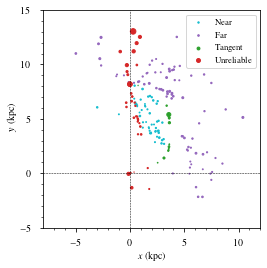

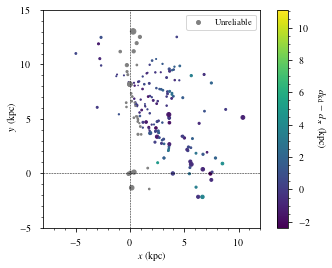

Median difference b/w kd and parallax-derived distances (kpc) 0.18310810810810452
Min & Max differences (kpc): -2.350662662662673 11.079546546546533
Min & Max abs(differences) (kpc): 0.0016566566566544871 11.079546546546533


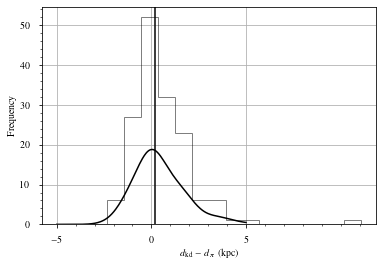

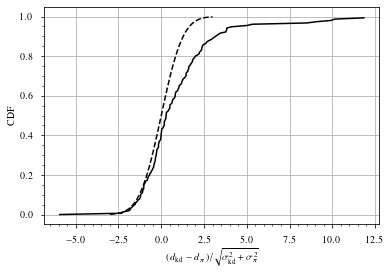

 KstestResult(statistic=0.22518107161501777, pvalue=2.1835085664063707e-07) 
Saved pickle file!


In [42]:
kdfile_input = "wc21_kd_1000x_pecTrue_krigeTrue_norm20.0.pkl"
# plots_bimodal(kdfile_input, trough_threshold=0.33, gc_threshold=15,
#               save_figs=False, print_stats=False)
plots_bimodal(kdfile_input, trough_threshold=0.2, gc_threshold=15,
              save_figs=False, print_stats=False, save_pkl=True)

FILE LOADED: wc21pec3_kd_1000x_pecTrue_krigeTrue_norm20.0_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
Trough threshold: 0.2
Streaming motion uncertainty factor (km/s): 7.5
Assigning kd distances using bimodal tangent criterion...
Number of sources automatically assigned to far distance: 70
num_sources 202
Iteration 201
Number of sources automatically assigned to tangent based on KDE peaks: 39
Total number of (non NaN) sources: 202
Num near: 42	Num far: 78	Num tangent: 35	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 55 2 51
Number of sources with NaN in both 'near' and 'far': 2
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0
Num of NaN errors (i.e. all errors are NaNs): 0
Done assigning kd distances using bimodal tangent criterion...


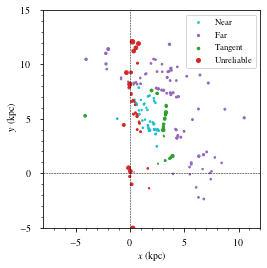

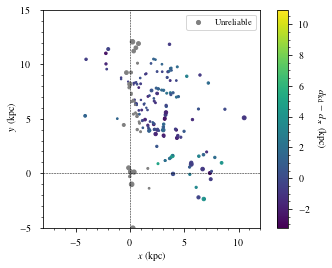

Median difference b/w kd and parallax-derived distances (kpc) -0.0013473473473495368
Min & Max differences (kpc): -3.1977477477477514 10.914588588588575
Min & Max abs(differences) (kpc): 0.0013473473473495368 10.914588588588575


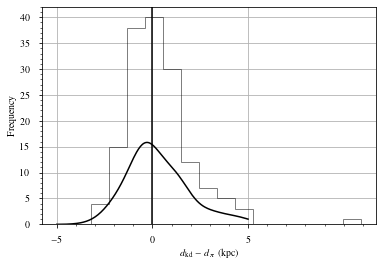

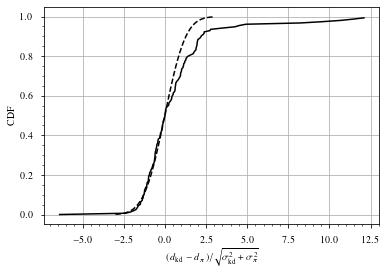

 KstestResult(statistic=0.14531072531214062, pvalue=0.002550204809074842) 
Saved pickle file!


In [7]:
kdfile_input = "wc21pec3_kd_1000x_pecTrue_krigeTrue_norm20.0_revLsr7.5.pkl"
plots_bimodal(kdfile_input, trough_threshold=0.2, gc_threshold=15,
              save_figs=False, print_stats=False, save_pkl=True)

FILE LOADED: wc21_kd_1000x_pecTrue_krigeFalse_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: False
Normalization factor: None
Trough threshold: 0.2
Streaming motion uncertainty factor (km/s): 7.5
Assigning kd distances using bimodal tangent criterion...
Number of sources automatically assigned to far distance: 70
num_sources 202
Iteration 201
Number of sources automatically assigned to tangent based on KDE peaks: 26
Total number of (non NaN) sources: 202
Num near: 53	Num far: 84	Num tangent: 18	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 56 2 51
Number of sources with NaN in both 'near' and 'far': 2
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0
Num of NaN errors (i.e. all errors are NaNs): 0
Done assigning kd distances using bimodal tangent criterion...


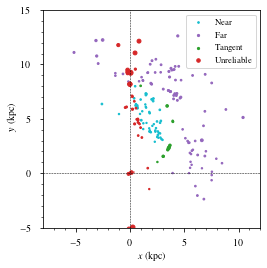

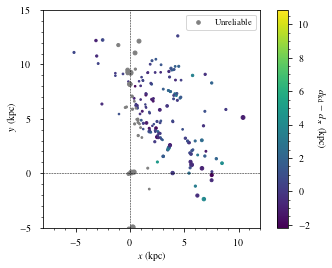

Median difference b/w kd and parallax-derived distances (kpc) 0.38517217217217103
Min & Max differences (kpc): -2.171962962962974 10.861148148148136
Min & Max abs(differences) (kpc): 0.002272272272270781 10.861148148148136


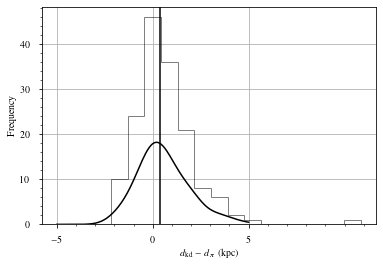

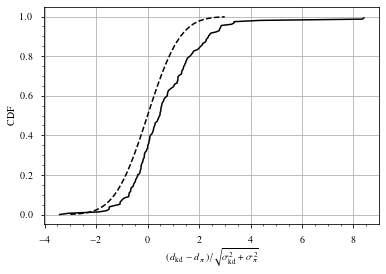

 KstestResult(statistic=0.2101499703935399, pvalue=1.74837884375614e-06) 
Saved pickle file!


In [10]:
kdfile_input = "wc21_kd_1000x_pecTrue_krigeFalse_revLsr7.5.pkl"
plots_bimodal(kdfile_input, trough_threshold=0.2, gc_threshold=15,
              save_figs=False, print_stats=False, save_pkl=True)

FILE LOADED: reid14_kd_1000x_pecFalse_krigeFalse_revLsrNone.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: False
Using kriging: False
Normalization factor: None
Trough threshold: 0.2
Streaming motion uncertainty factor (km/s): None
Assigning kd distances using bimodal tangent criterion...
Number of sources automatically assigned to far distance: 68
num_sources 202
Iteration 201
Number of sources automatically assigned to tangent based on KDE peaks: 26
Total number of (non NaN) sources: 202
Num near: 56	Num far: 83	Num tangent: 16	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 58 4 51
Number of sources with NaN in both 'near' and 'far': 4
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0
Num of NaN errors (i.e. all errors are NaNs): 0
Done assigning kd distances using bimodal tangent criterion...


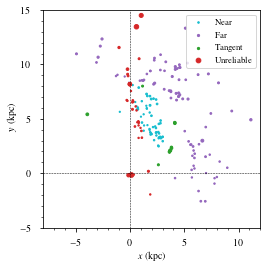

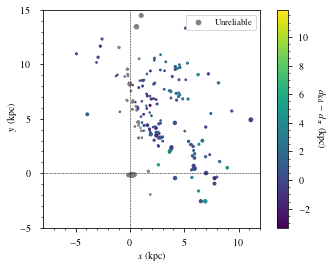

Median difference b/w kd and parallax-derived distances (kpc) 0.6182872872872849
Min & Max differences (kpc): -3.3111031031031057 11.876276276276263
Min & Max abs(differences) (kpc): 0.010831831831831007 11.876276276276263


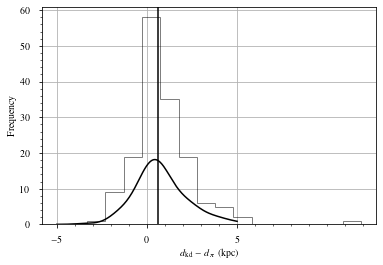

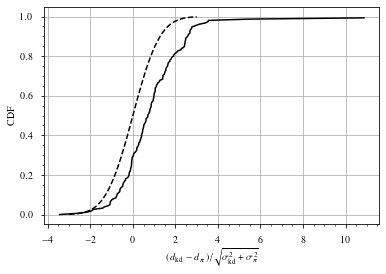

 KstestResult(statistic=0.26490309215899166, pvalue=4.3262333516430947e-10) 
Saved pickle file!


In [11]:
kdfile_input = "reid14_kd_1000x_pecFalse_krigeFalse_revLsrNone.pkl"
plots_bimodal(kdfile_input, trough_threshold=0.2, gc_threshold=15,
              save_figs=False, print_stats=False, save_pkl=True)

# Code to see individual KDEs

---- Trough threshold: 0.5 ----
Source G081.87+00.78, idx = 153
Found 1 peak much larger than rest


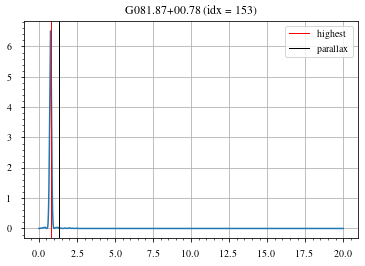


Source G075.78+00.34, idx = 145
Count as 2 distinct peaks


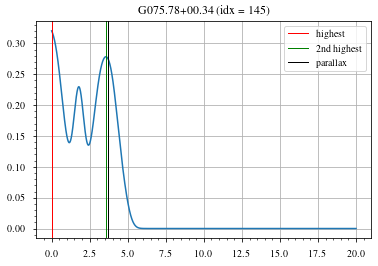

In [8]:
#
# Code to see individual KDEs
#
#
# Enter parameters here
#
kdfile = "cw21_kd_plx_results_1000x_pecTrue_krigeTrue_norm20.pkl"
# kdfile = "cw21_kd_plx_results_1000x_pecTrue_krigeFalse.pkl"
with open(Path.cwd() / kdfile, "rb") as f:
    kd_results = dill.load(f)["kd"]
kdes = kd_results["distance_kde"]
dists = np.arange(0.001, 20, 0.001)
# indices = [0,1,2,3,4]  # index to inspect
# indices = np.arange(20, 30, dtype=int)
indices = [153, 145]
# indices = [95, 133, 144, 145, 53, 54]
trough_threshold = 0.4
gc_threshold = 15  # deg
#
# 
# 
datafile = Path("pec_motions/csvfiles/alldata_HPDmode_NEW2.csv")
database_data = pd.read_csv(Path.cwd().parent / datafile)
glong = database_data["glong"].values
vlsr = database_data["vlsr_med"].values
peak_dist = database_data["dist_mode"].values
# Unreliable sources
glong[glong > 180] -= 360  # force -180 < glong <= 180
is_unreliable = (abs(glong) < gc_threshold) | (abs(glong) > 160.0)
# 
is_q23 = (glong > 90) & (glong < 270)
is_q12 = (glong >= 0) & (glong < 180)
is_q34 = (glong >= 180) & (glong < 360)
use_far = (((vlsr < 0) & (is_q12)) | ((vlsr > 0) & (is_q34))) & \
        (~np.isnan(kd_results["far"]))
#
# Skip sources in q2 & q3
is_q23 = (glong > 90) & (glong < 270)
#
print("---- Trough threshold:", trough_threshold, "----")
for idx in indices:
    gname = database_data["gname"][idx]
    print(f"Source {gname}, idx = {idx}")
    if is_unreliable[idx]:
        print("This source is unreliable")
    if is_q23[idx]:
        print("This source is in quadrants 2/3")
    if use_far[idx]:
        print("This source is auto-assigned to far distance")
    # 
    probs = kdes[idx](dists)
    max_idx = argrelmax(probs, mode="wrap")[0]
    num_max = len(max_idx)
    if num_max == 1:
        print("1 max found")
    # Find if one peak is much larger than the rest
    peaks = probs[max_idx]
    max_peak = np.max(peaks)
    peak_diffs = max_peak - peaks[peaks != max_peak]
    second_max_peak = None
    if all(peak_diffs > 0.8 * max_peak):
        # "much larger" = at least 50% height of max_peak
        print("Found 1 peak much larger than rest")
    # if num_max < 1 or num_max > 2:
    #     print("At index", i, "= source", database_data["gname"][i])
    #     raise ValueError("Wrong number of maxima detected. Detected " + str(num_max) + " max!")
    else:
        # Choose 2 largest maxima
        second_max_peak = np.max(peaks[peaks != max_peak])
        max_idx = np.argwhere((probs == max_peak) | (probs == second_max_peak))
        if max_idx.size != 2:
            raise ValueError(
                "Wrong number of 2 largest maxima detected. Detected "
                + str(max_idx.size)
            )
        between_maxes = (dists > dists[max_idx[0]]) & (dists < dists[max_idx[1]])
        min_prob = np.amin(probs, where=between_maxes, initial=np.inf)
        if min_prob.size != 1:
            raise ValueError(
                "Wrong number of mins detected. Detected " + str(min_prob.size)
            )
        # Check if min is between max_idx
        # min_idx = np.where(probs = min_prob)
        # Check if difference between peaks and trough is too small
        smaller_peak = np.min(probs[max_idx])
        diff = smaller_peak - min_prob
        if diff < trough_threshold * smaller_peak:
            print("Essentially 1 peak")
        else:
            print("Count as 2 distinct peaks")
    fig, ax = plt.subplots()
    ax.plot(dists, probs)
    for i in max_idx:
        if probs[i] == max_peak:
            colour = "r"
            label = "highest"
        elif second_max_peak is not None:
            colour = "g"
            label = "2nd highest"
        else:
            # colour = "k"
            continue
        ax.axvline(dists[i], color=colour, linewidth=1, label=label)
    # Plot actual distance
    ax.axvline(peak_dist[idx], color="k", linewidth=1, label="parallax")
    ax.legend(loc="best")
    ax.set_title(f"{gname} (idx = {idx})")
    plt.show()
    print()


# General plotting function using pickled data

In [5]:
def plots(kd_results, save_figs=True, print_stats=False):
    # 
    # Load data
    # 
    print("FILE LOADED:", kd_results)
    with open(Path.cwd() / kd_results, "rb") as f:
        file = dill.load(f)
        plxdata = file["plxdata"]
        kddata = file["kddata"]
        dist_kd = file["dist_kd"]
        e_dist_kd = file["e_dist_kd"]
        is_near = file["is_near"]
        is_far = file["is_far"]
        is_tangent = file["is_tangent"]
        is_unreliable = file["is_unreliable"]
        gc_threshold = file["gc_threshold"]
        if "trough" in kd_results:
            used_bimodal = True
            threshold = file["trough_threshold"]
        else:
            used_bimodal = False
            threshold = file["vlsr_tol"]
    dist_plx = plxdata["dist_mode"].values
    e_dist_plx = plxdata["dist_halfhpd"].values
    # plxfile = Path("pec_motions/csvfiles/alldata_HPDmode_NEW2.csv")
    # plxdata = pd.read_csv(Path.cwd().parent / plxfile)
    # dist_plx = plxdata["dist_mode"].values
    # e_dist_plx = plxdata["dist_halfhpd"].values
    #
    # RegEx stuff
    #
    # Find num_samples in kd
    num_samples = int(search('(\d+)x', kd_results).group(1))
    # Find if kd used kriging
    use_kriging = search("krige(.+?)", kd_results).group(1)
    use_kriging = use_kriging.lower() == "t"
    # Find if kd used peculiar motions
    use_peculiar = search("_pec(.+?)", kd_results).group(1)
    use_peculiar = use_peculiar.lower() == "t"
    # Find rotcurve used
    rotcurve = kd_results.split('_', 1)[0].replace('.', '') + "_"
    # Find normalization factor
    try:
        norm_factor = int(search('norm(\d+)', kd_results).group(1))
    except AttributeError:
        norm_factor = None
    # Find if kd included streaming motion uncertainty in e_vlsr
    try:
        streaming_mot = float(search("revLsr([-+]?\d*\.\d+|\d+)", kd_results).group(1))
        if streaming_mot.is_integer():
            streaming_mot = int(streaming_mot)
    except AttributeError:
        streaming_mot = None
    # Append info to figure names
    figname_append = f"_{num_samples}x_pec{use_peculiar}_krige{use_kriging}"
    if norm_factor is not None:
        figname_append += f"_norm{norm_factor}"   
    if used_bimodal:
        figname_append += f"_trough{threshold}"
    else:
        figname_append += f"_vlsrTolerance{threshold}"
    figname_append += f"_revLsr{streaming_mot}.pdf"
    #
    # Print stats
    #
    print("=" * 6)
    print("Number of MC kd samples:", num_samples)
    print("Including peculiar motions in kd:", use_peculiar)
    print("Using kriging:", use_kriging)
    print("Normalization factor:", norm_factor)
    print("GC unreliable cutoff (deg):", gc_threshold)
    if used_bimodal:
        print("Trough threshold:", threshold)
    else:
        print("vlsr tolerance (km/s):", threshold)
    print("Streaming motion uncertainty factor (km/s):", streaming_mot)
    print("=" * 6)
    # 
    is_nan = (~is_near) & (~is_far) & (~is_tangent)
    near_err = abs(kddata["near"] - dist_plx)
    far_err = abs(kddata["far"] - dist_plx)
    tangent_err = abs(kddata["tangent"] - dist_plx)
    print("Total number of (non NaN) sources:", np.isfinite(dist_kd).sum())
    print(f"Num near: {np.sum((is_near) & (~is_unreliable))}"
          + f"\tNum far: {np.sum((is_far) & (~is_unreliable))}"
          + f"\tNum tangent: {np.sum((is_tangent) & (~is_unreliable))}"
          + f"\tNum unreliable: {np.sum((is_unreliable) & (~is_nan))}")
    print("Number of NaN sources (i.e. all dists are NaNs):", np.sum(is_nan))
    print("Num NaNs in near, far, tangent:",
          np.sum(np.isnan(near_err)), np.sum(np.isnan(far_err)),
          np.sum(np.isnan(tangent_err)))
    print("Number of sources with NaN in both 'near' and 'far':",
          sum(np.isnan(kddata["near"]) & np.isnan(kddata["far"])))
    print("Number of sources with NaN in both 'near' and 'tangent':",
          sum(np.isnan(kddata["near"]) & np.isnan(kddata["tangent"])))
    print("Number of sources with NaN in both 'far' and 'tangent':",
          sum(np.isnan(kddata["far"]) & np.isnan(kddata["tangent"])))
    # Print following if two distances are selected:
    num_near_far = np.sum((is_near) & (is_far))
    num_near_tan = np.sum((is_near) & (is_tangent))
    num_far_tan = np.sum((is_far) & (is_tangent))
    if any([num_near_far, num_near_tan, num_far_tan]):
        print("Both near and far (should be 0):", num_near_far)
        print("Both near and tan (should be 0):", num_near_tan)
        print("Both far and tan (should be 0):", num_far_tan)
    print("=" * 6)
    #
    # Create face-on map with kinematic distances
    #
    # Convert to galactocentric frame
    glong = plxdata["glong"].values
    glat = plxdata["glat"].values
    Xb, Yb, Zb = trans.gal_to_bary(glong, glat, dist_kd)
    Xg, Yg, Zg = trans.bary_to_gcen(Xb, Yb, Zb, R0=_R0, Zsun=_ZSUN, roll=_ROLL)
    # Rotate 90 deg CW (so Sun is on +y-axis)
    Xg, Yg = Yg, -Xg
    #
    fig, ax = plt.subplots()
    size_scale = 4  # scaling factor for size
    #
    ax.scatter(Xg[(is_near) & (~is_unreliable)], Yg[(is_near) & (~is_unreliable)],
            c="tab:cyan", s=e_dist_kd[(is_near) & (~is_unreliable)] * size_scale,
            label="Near")
    #
    ax.scatter(Xg[(is_far) & (~is_unreliable)], Yg[(is_far) & (~is_unreliable)],
            c="tab:purple", s=e_dist_kd[(is_far) & (~is_unreliable)] * size_scale,
            label="Far")
    #
    ax.scatter(Xg[(is_tangent) & (~is_unreliable)], Yg[(is_tangent) & (~is_unreliable)],
            c="tab:green", s=e_dist_kd[(is_tangent) & (~is_unreliable)] * size_scale,
            label="Tangent")
    #
    ax.scatter(Xg[is_unreliable], Yg[is_unreliable],
            c="tab:red", s=e_dist_kd[is_unreliable] * size_scale,
            label="Unreliable")
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = rotcurve + "faceonplx" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    #
    # Calculate difference between kd and plx distances
    #
    dist_diff = dist_kd - dist_plx
    e_dist_diff = np.sqrt(e_dist_plx**2 + e_dist_kd**2)
    #
    # Plot
    #
    # Face on view of differences
    fig, ax = plt.subplots()
    #
    cmap = "viridis"
    norm = mpl.colors.Normalize(vmin=np.nanmin(dist_diff[~is_unreliable]),
                                vmax=np.nanmax(dist_diff[~is_unreliable]))
    ax.scatter(Xg[~is_unreliable], Yg[~is_unreliable],
            c=dist_diff[~is_unreliable], s=e_dist_diff[~is_unreliable] * size_scale,
            cmap=cmap, norm=norm)
    ax.scatter(Xg[is_unreliable], Yg[is_unreliable],
            c="grey", s=e_dist_diff[is_unreliable] * size_scale, label="Unreliable")
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.ax.set_ylabel(r"$d_{\rm kd} - d_\pi$ (kpc)", rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = rotcurve + "faceonplxDiffs" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # Histogram of differences
    fig, ax = plt.subplots()
    ax.hist(dist_diff[~is_unreliable], bins=15, histtype="step", color="k", alpha=0.5)
    median_diff = np.median(dist_diff[~is_unreliable])
    ax.axvline(median_diff, color="k")
    print("Median difference b/w kd and parallax-derived distances (kpc):", median_diff)
    print("Min & Max differences (kpc):", np.min(dist_diff[~is_unreliable]),
            np.max(dist_diff[~is_unreliable]))
    print("Min & Max abs(differences) (kpc):", np.min(abs(dist_diff[~is_unreliable])),
            np.max(abs(dist_diff[~is_unreliable])))
    # Add KDE to histogram
    kde_dist_diffs = gaussian_kde(dist_diff[~is_unreliable])
    xlims = (np.floor(np.min(dist_diff[~is_unreliable])),
             np.ceil(np.max(dist_diff[~is_unreliable])))
    # xlabels = np.arange(xlims[0], xlims[1]+1, 1, dtype=int)
    diffs = np.linspace(*xlims, 200)
    kde = kde_dist_diffs(diffs)
    ax.plot(diffs, kde * np.sum(kde) * 10, color="k")
    ax.set_xlabel(r"$d_{\rm kd} - d_\pi$ (kpc)")
    ax.set_ylabel("Frequency")
    # ax.set_xticks(xlabels)
    ax.grid(True)
    figname = rotcurve + "kd_plx_diff_hist" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # Plot histogram of kinematic distance difference / combined uncertainty
    diff_over_uncer = dist_diff / e_dist_diff
    fig, ax = plt.subplots()
    ax.hist(diff_over_uncer[~is_unreliable], bins=15, histtype="step", color="k", alpha=0.5)
    median_diff_over_uncer = np.median(diff_over_uncer[~is_unreliable])
    ax.axvline(median_diff_over_uncer, color="k")
    ax.set_xlabel(r"$(d_{\rm kd} - d_\pi) / \sqrt{\sigma^2_{\rm kd} + \sigma^2_\pi}$")
    ax.set_ylabel("Frequency")
    print("Median difference / combined uncertainty:", median_diff_over_uncer)
    print("Min & Max diff_ver_uncer:", np.min(diff_over_uncer[~is_unreliable]),
            np.max(diff_over_uncer[~is_unreliable]))
    print("Min & Max abs(diff_over_uncer):", np.min(abs(diff_over_uncer[~is_unreliable])),
            np.max(abs(diff_over_uncer[~is_unreliable])))
    ax.grid(True)
    figname = rotcurve + "kd_plx_diffOverUncer_hist" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # CDF of differences over total error
    fig, ax = plt.subplots()
    cdf_data = np.sort(dist_diff[~is_unreliable]/e_dist_diff[~is_unreliable])
    xlims = (np.min(cdf_data), np.max(cdf_data))
    cdf_x = np.linspace(*xlims)
    ax.plot(cdf_x, gaussian_cdf(cdf_x), "k--")
    ax.plot(cdf_data, np.arange(cdf_data.size)/cdf_data.size, "k-")
    # ax.set_xlim(*xlims)
    ax.set_xlabel(r"$(d_{\rm kd} - d_\pi) / \sqrt{\sigma^2_{\rm kd} + \sigma^2_\pi}$")
    ax.set_ylabel("CDF")
    figname = rotcurve + "kd_plx_diff_CDF" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    #
    # K-S test
    #
    print("======\n",
            kstest(cdf_data, gaussian_cdf, N=cdf_data.size, mode="exact"),
            "\n======")
    # 
    if print_stats:
        #
        # Print stats
        #
        kdtypes = [(is_near) & (~is_unreliable),
                (is_far) & (~is_unreliable),
                (is_tangent) & (~is_unreliable),
                is_unreliable
        ]
        kdnames = ["Near", "Far", "Tangent", "Unreliable"]
        for kdtype, kdname in zip(kdtypes, kdnames):
            print("="*3, kdname + " sources", "="*3)
            df_plx = plxdata[["gname", "glong", "glat", "vlsr_med", "dist_mode"]][kdtype]
            print()
            df_kd = kddata[["near", "far", "tangent", "vlsr_tangent"]][kdtype]
            df_tot = pd.concat([df_plx, df_kd], axis=1)
            print(df_tot.to_string())
            print(f"Number of {kdname} sources:", len(df_tot))

FILE LOADED: bimodal_wc21pec3_1000x_pecTrue_krigeTrue_norm20_trough0.2_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
GC unreliable cutoff (deg): 15
Trough threshold: 0.2
Streaming motion uncertainty factor (km/s): 7.5
Total number of (non NaN) sources: 202
Num near: 42	Num far: 78	Num tangent: 35	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 55 2 51
Number of sources with NaN in both 'near' and 'far': 2
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0


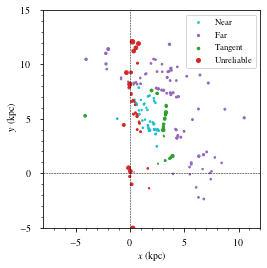

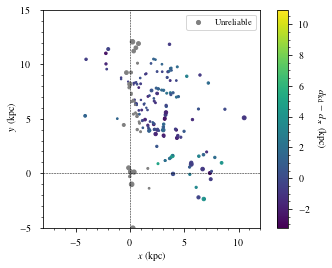

Median difference b/w kd and parallax-derived distances (kpc): -0.0013473473473495368
Min & Max differences (kpc): -3.1977477477477514 10.914588588588575
Min & Max abs(differences) (kpc): 0.0013473473473495368 10.914588588588575


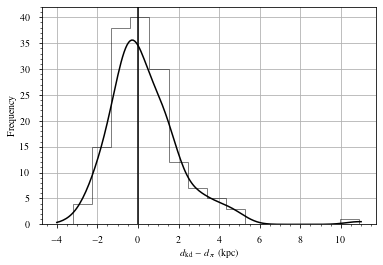

Median difference / combined uncertainty: -0.0016247633752101737
Min & Max diff_ver_uncer: -6.392348284055997 12.097180611312092
Min & Max abs(diff_over_uncer): 0.0016247633752101737 12.097180611312092


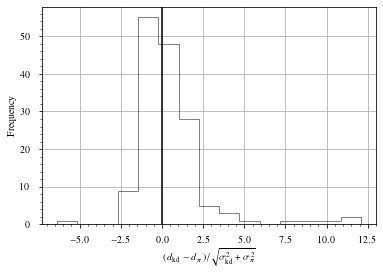

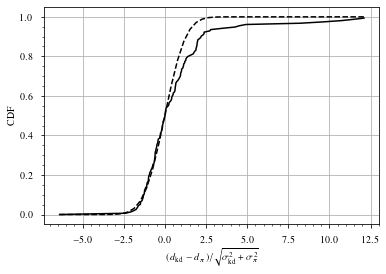

 KstestResult(statistic=0.14531072531214062, pvalue=0.002550204809074842) 


In [9]:
kdresults_input = "bimodal_wc21pec3_1000x_pecTrue_krigeTrue_norm20_trough0.2_revLsr7.5.pkl"
plots(kdresults_input, save_figs=False, print_stats=False)

FILE LOADED: bimodal_wc21_1000x_pecTrue_krigeTrue_norm20_trough0.2_revLsrNone.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
GC unreliable cutoff (deg): 15
Trough threshold: 0.2
Streaming motion uncertainty factor (km/s): None
Total number of (non NaN) sources: 202
Num near: 52	Num far: 81	Num tangent: 22	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 58 4 51
Number of sources with NaN in both 'near' and 'far': 3
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0


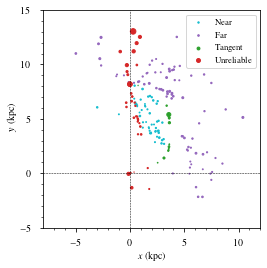

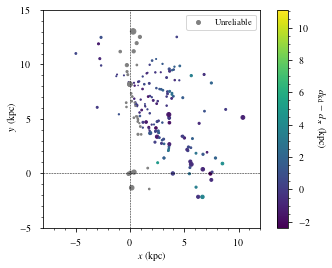

Median difference b/w kd and parallax-derived distances (kpc): 0.18310810810810452
Min & Max differences (kpc): -2.350662662662673 11.079546546546533
Min & Max abs(differences) (kpc): 0.0016566566566544871 11.079546546546533


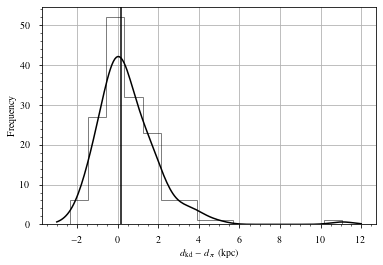

Median difference / combined uncertainty: 0.28828860921215976
Min & Max diff_ver_uncer: -5.944889878000342 11.854036702679219
Min & Max abs(diff_over_uncer): 0.004646181787460219 11.854036702679219


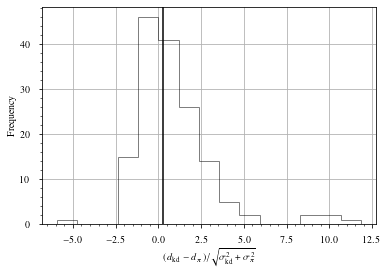

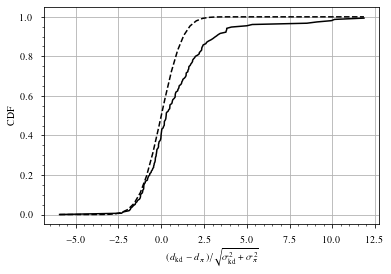

 KstestResult(statistic=0.22518107161501777, pvalue=2.1835085664063707e-07) 


In [44]:
kdresults_input = "bimodal_wc21_1000x_pecTrue_krigeTrue_norm20_trough0.2_revLsrNone.pkl"
plots(kdresults_input, save_figs=False, print_stats=False)

FILE LOADED: vlsrtol_wc21_1000x_pecTrue_krigeTrue_norm20_vlsrTolerance20.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
GC unreliable cutoff (deg): 15
vlsr tolerance (km/s): 20
Streaming motion uncertainty factor (km/s): None
Total number of (non NaN) sources: 202
Num near: 27	Num far: 69	Num tangent: 59	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 58 4 51
Number of sources with NaN in both 'near' and 'far': 3
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0


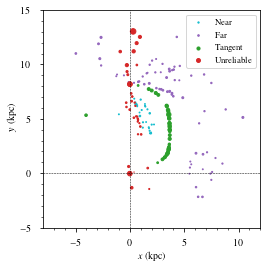

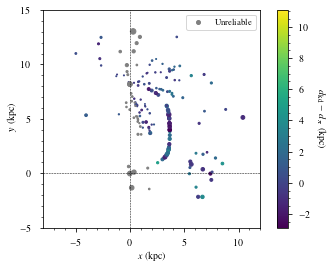

Median difference b/w kd and parallax-derived distances (kpc): 0.40802902902902694
Min & Max differences (kpc): -2.864996996997 11.079546546546533
Min & Max abs(differences) (kpc): 0.0016566566566544871 11.079546546546533


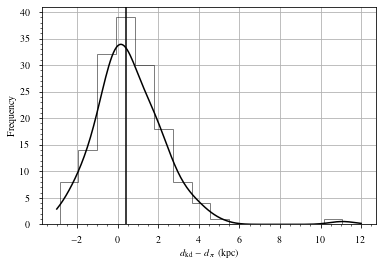

Median difference / combined uncertainty: 0.30942969757637345
Min & Max diff_ver_uncer: -1.880814072993434 11.854036702679219
Min & Max abs(diff_over_uncer): 0.004646181787460219 11.854036702679219


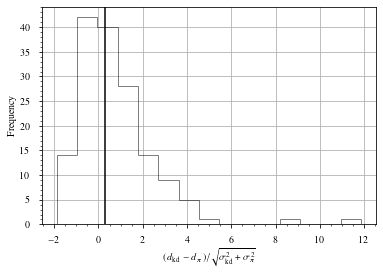

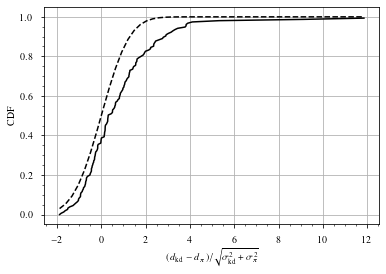

 KstestResult(statistic=0.20571421223862962, pvalue=3.139731634674303e-06) 


In [59]:
kdresults_input = "vlsrtol_wc21_1000x_pecTrue_krigeTrue_norm20_vlsrTolerance20.pkl"
plots(kdresults_input, save_figs=False, print_stats=False)

FILE LOADED: vlsrtol_wc21_1000x_pecTrue_krigeTrue_norm20_vlsrTolerance10_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
GC unreliable cutoff (deg): 15
vlsr tolerance (km/s): 10
Streaming motion uncertainty factor (km/s): 7.5
Total number of (non NaN) sources: 202
Num near: 34	Num far: 75	Num tangent: 46	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 55 2 51
Number of sources with NaN in both 'near' and 'far': 2
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0


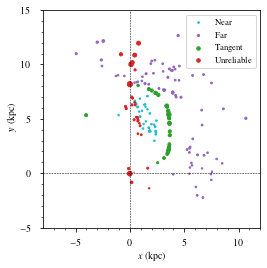

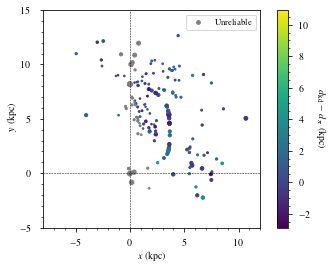

Median difference b/w kd and parallax-derived distances (kpc): 0.3955125125125072
Min & Max differences (kpc): -2.8805895895895937 10.927186186186175
Min & Max abs(differences) (kpc): 0.006180180180185957 10.927186186186175


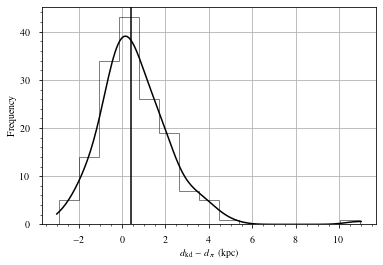

Median difference / combined uncertainty: 0.35422364298936526
Min & Max diff_ver_uncer: -1.8249954816015386 8.493830962675295
Min & Max abs(diff_over_uncer): 0.0049814297866347355 8.493830962675295


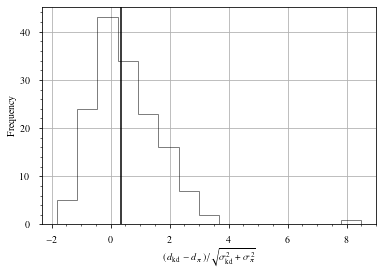

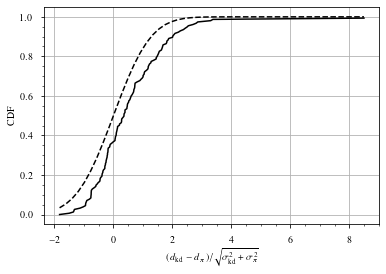

 KstestResult(statistic=0.1540993987429521, pvalue=0.0011133499536051905) 


In [13]:
kdresults_input = "vlsrtol_wc21_1000x_pecTrue_krigeTrue_norm20_vlsrTolerance10_revLsr7.5.pkl"
plots(kdresults_input, save_figs=False, print_stats=False)

FILE LOADED: vlsrtol_wc21pec3_1000x_pecTrue_krigeTrue_norm20_vlsrTolerance10_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
GC unreliable cutoff (deg): 15
vlsr tolerance (km/s): 10
Streaming motion uncertainty factor (km/s): 7.5
Total number of (non NaN) sources: 202
Num near: 30	Num far: 75	Num tangent: 50	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 55 2 51
Number of sources with NaN in both 'near' and 'far': 2
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0


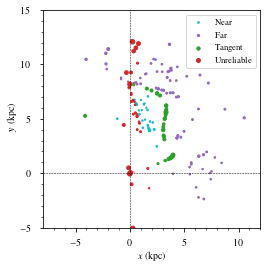

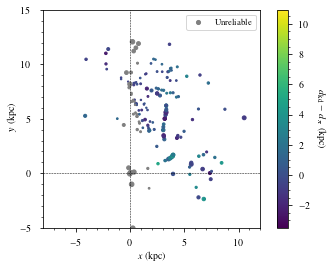

Median difference b/w kd and parallax-derived distances (kpc): 0.19062662662662566
Min & Max differences (kpc): -3.480851851851855 10.914588588588575
Min & Max abs(differences) (kpc): 0.0013473473473495368 10.914588588588575


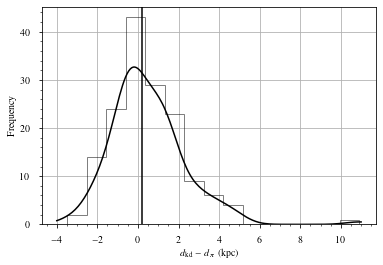

Median difference / combined uncertainty: 0.20613412370152215
Min & Max diff_ver_uncer: -1.890872248411447 8.242282011214614
Min & Max abs(diff_over_uncer): 0.0016247633752101737 8.242282011214614


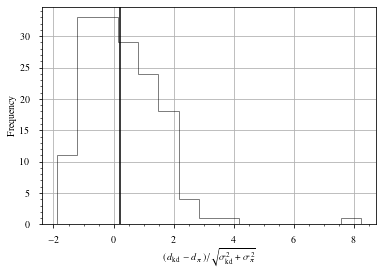

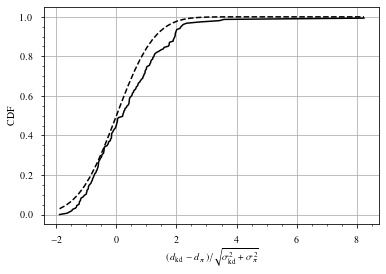

 KstestResult(statistic=0.12038422893811107, pvalue=0.020483493677088103) 


In [9]:
kdresults_input = "vlsrtol_wc21pec3_1000x_pecTrue_krigeTrue_norm20_vlsrTolerance10_revLsr7.5.pkl"
plots(kdresults_input, save_figs=True, print_stats=False)

FILE LOADED: vlsrtol_wc21_1000x_pecTrue_krigeFalse_vlsrTolerance10_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: False
Normalization factor: None
GC unreliable cutoff (deg): 15
vlsr tolerance (km/s): 10
Streaming motion uncertainty factor (km/s): 7.5
Total number of (non NaN) sources: 202
Num near: 36	Num far: 76	Num tangent: 43	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 56 2 51
Number of sources with NaN in both 'near' and 'far': 2
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0


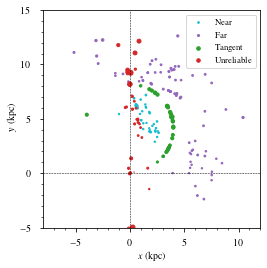

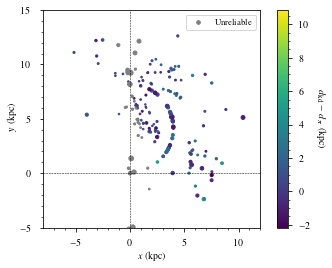

Median difference b/w kd and parallax-derived distances (kpc): 0.49047047047046677
Min & Max differences (kpc): -2.171962962962974 10.861148148148136
Min & Max abs(differences) (kpc): 0.002272272272270781 10.861148148148136


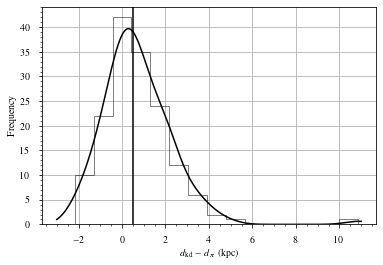

Median difference / combined uncertainty: 0.39372185209588156
Min & Max diff_ver_uncer: -1.9035817385609344 8.406796643952617
Min & Max abs(diff_over_uncer): 0.0035653882303814124 8.406796643952617


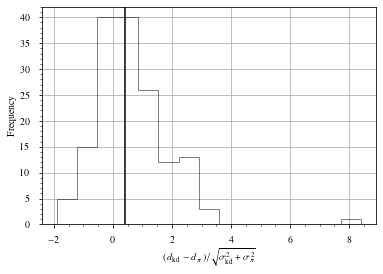

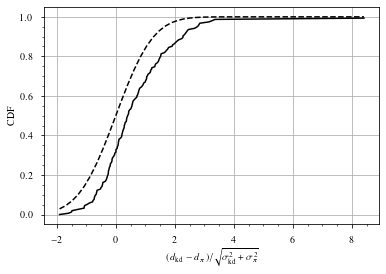

 KstestResult(statistic=0.19789367248612544, pvalue=8.54109040225781e-06) 


In [13]:
kdresults_input = "vlsrtol_wc21_1000x_pecTrue_krigeFalse_vlsrTolerance10_revLsr7.5.pkl"
plots(kdresults_input, save_figs=False, print_stats=False)

FILE LOADED: vlsrtol_reid14_1000x_pecFalse_krigeFalse_vlsrTolerance10_revLsrNone.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: False
Using kriging: False
Normalization factor: None
GC unreliable cutoff (deg): 15
vlsr tolerance (km/s): 10
Streaming motion uncertainty factor (km/s): None
Total number of (non NaN) sources: 202
Num near: 38	Num far: 75	Num tangent: 42	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs): 0
Num NaNs in near, far, tangent: 58 4 51
Number of sources with NaN in both 'near' and 'far': 4
Number of sources with NaN in both 'near' and 'tangent': 51
Number of sources with NaN in both 'far' and 'tangent': 0


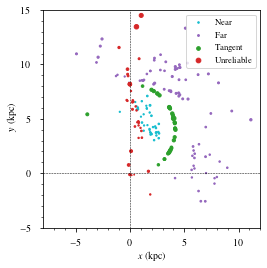

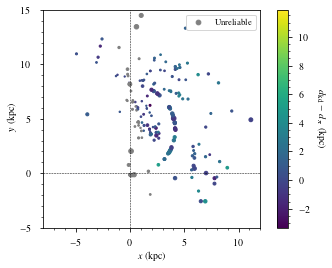

Median difference b/w kd and parallax-derived distances (kpc): 0.7060610610610591
Min & Max differences (kpc): -3.3111031031031057 11.876276276276263
Min & Max abs(differences) (kpc): 0.010831831831831007 11.876276276276263


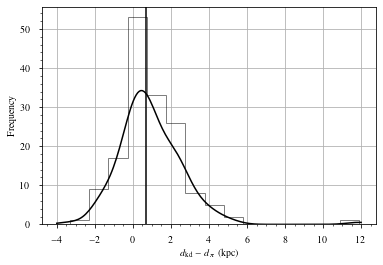

Median difference / combined uncertainty: 0.6201645641567151
Min & Max diff_ver_uncer: -3.4459090098148186 10.86621551951905
Min & Max abs(diff_over_uncer): 0.018815409855355153 10.86621551951905


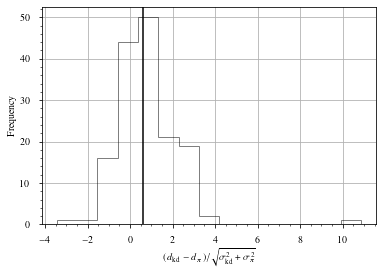

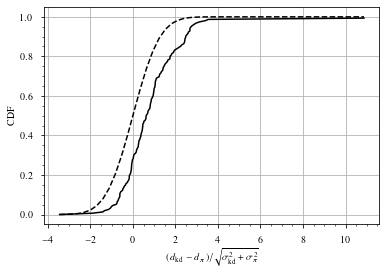

 KstestResult(statistic=0.2555539649063612, pvalue=2.0602859408268314e-09) 


In [14]:
kdresults_input = "vlsrtol_reid14_1000x_pecFalse_krigeFalse_vlsrTolerance10_revLsrNone.pkl"
plots(kdresults_input, save_figs=False, print_stats=False)

# Plots after removing outliers

In [10]:
def plots_clean(kd_results, save_figs=True, print_stats=False,
                diff_threshold_low=-3.5, diff_threshold_high=6.0,
                outlier_list=None):
    """
    Inputs:
      diff_threshold_low, diff_threshold_high :: scalars
        Parameters to control outlier rejection
        diff_threshold_low = minimum allowed dist_diff / e_dist_diff
        diff_threshold_high = maximum allowed dist_diff / e_dist_diff
        outlier_list = list or array of outliers by gname (strings).
          If passed in, WILL IGNORE DIFF_THRESHOLD values!
    """
    #
    # Load data
    #
    print("FILE LOADED:", kd_results)
    with open(Path.cwd() / kd_results, "rb") as f:
        file = dill.load(f)
        plxdata = file["plxdata"]
        kddata = file["kddata"]
        dist_kd = file["dist_kd"]
        e_dist_kd = file["e_dist_kd"]
        is_near = file["is_near"]
        is_far = file["is_far"]
        is_tangent = file["is_tangent"]
        is_unreliable = file["is_unreliable"]
        gc_threshold = file["gc_threshold"]
        if "trough" in kd_results:
            used_bimodal = True
            threshold = file["trough_threshold"]
        else:
            used_bimodal = False
            threshold = file["vlsr_tol"]
    dist_plx = plxdata["dist_mode"].values
    e_dist_plx = plxdata["dist_halfhpd"].values
    # plxfile = Path("pec_motions/csvfiles/alldata_HPDmode_NEW2.csv")
    # plxdata = pd.read_csv(Path.cwd().parent / plxfile)
    # dist_plx = plxdata["dist_mode"].values
    # e_dist_plx = plxdata["dist_halfhpd"].values
    #
    # RegEx stuff
    #
    # Find num_samples in kd
    num_samples = int(search("(\d+)x", kd_results).group(1))
    # Find if kd used kriging
    use_kriging = search("krige(.+?)", kd_results).group(1)
    use_kriging = use_kriging.lower() == "t"
    # Find if kd used peculiar motions
    use_peculiar = search("_pec(.+?)", kd_results).group(1)
    use_peculiar = use_peculiar.lower() == "t"
    # Find rotcurve used
    rotcurve = "clean_" + kd_results.split("_", 1)[0].replace(".", "") + "_"
    # Find normalization factor
    try:
        norm_factor = int(search("norm(\d+)", kd_results).group(1))
    except AttributeError:
        norm_factor = None
    # Find if kd included streaming motion uncertainty in e_vlsr
    try:
        streaming_mot = float(search("revLsr([-+]?\d*\.\d+|\d+)", kd_results).group(1))
        if streaming_mot.is_integer():
            streaming_mot = int(streaming_mot)
    except AttributeError:
        streaming_mot = None
    # Append info to figure names
    figname_append = f"_{num_samples}x_pec{use_peculiar}_krige{use_kriging}"
    if norm_factor is not None:
        figname_append += f"_norm{norm_factor}"   
    if used_bimodal:
        figname_append += f"_trough{threshold}"
    else:
        figname_append += f"_vlsrTolerance{threshold}"
    figname_append += f"_revLsr{streaming_mot}.pdf"
    #
    # Print stats
    #
    print("=" * 6)
    print("Number of MC kd samples:", num_samples)
    print("Including peculiar motions in kd:", use_peculiar)
    print("Using kriging:", use_kriging)
    print("Normalization factor:", norm_factor)
    print("GC unreliable cutoff (deg):", gc_threshold)
    if used_bimodal:
        print("Trough threshold:", threshold)
    else:
        print("vlsr tolerance (km/s):", threshold)
    print("Streaming motion uncertainty factor (km/s):", streaming_mot)
    print("=" * 6)
    #
    # Calculate difference between kd and plx distances
    #
    dist_diff = dist_kd - dist_plx
    e_dist_diff = np.sqrt(e_dist_plx ** 2 + e_dist_kd ** 2)
    diff_over_uncer = dist_diff / e_dist_diff
    # Remove outliers
    if outlier_list is not None:
        print("! Using outlier_list as outliers instead of diff_threshold values !")
        # is_clean = plxdata["gname"].values not in outlier_list
        is_clean = ~np.isin(plxdata["gname"].values, outlier_list)
    else:
        is_clean = (diff_over_uncer > diff_threshold_low) & \
                (diff_over_uncer < diff_threshold_high)
    #
    is_nan = (~is_near) & (~is_far) & (~is_tangent)
    near_err = abs(kddata["near"] - dist_plx)
    far_err = abs(kddata["far"] - dist_plx)
    tangent_err = abs(kddata["tangent"] - dist_plx)
    print("NUM OUTLIERS:", np.sum((~is_clean) & (~is_unreliable)))
    print("OUTLIERS:", plxdata["gname"].values[(~is_clean) & (~is_unreliable)])
    print("PLX COORDS (x):", plxdata["x_mode"].values[(~is_clean) & (~is_unreliable)])
    print("PLX COORDS (y):", plxdata["y_mode"].values[(~is_clean) & (~is_unreliable)])
    print("=" * 6)
    # 
    print("Total number of (non NaN) sources (cleaned):", np.isfinite(dist_kd).sum() - ((~is_clean) & (~is_unreliable)).sum())
    print(
        f"Num near: {np.sum((is_near) & (~is_unreliable))}"
        + f"\tNum far: {np.sum((is_far) & (~is_unreliable))}"
        + f"\tNum tangent: {np.sum((is_tangent) & (~is_unreliable))}"
        + f"\tNum unreliable: {np.sum((is_unreliable) & (~is_nan))}"
    )
    print("Number of NaN sources (i.e. all dists are NaNs, cleaned):", np.sum((is_nan) & (is_clean)))
    print(
        "Num NaNs in near, far, tangent (cleaned):",
        np.sum((np.isnan(near_err)) & (is_clean)),
        np.sum((np.isnan(far_err)) & (is_clean)),
        np.sum((np.isnan(tangent_err)) & (is_clean)),
    )
    print(
        "Number of sources with NaN in both 'near' and 'far' (cleaned):",
        sum(np.isnan(kddata["near"]) & np.isnan(kddata["far"]) & (is_clean)),
    )
    print(
        "Number of sources with NaN in both 'near' and 'tangent' (cleaned):",
        sum(np.isnan(kddata["near"]) & np.isnan(kddata["tangent"]) & (is_clean)),
    )
    print(
        "Number of sources with NaN in both 'far' and 'tangent' (cleaned):",
        sum(np.isnan(kddata["far"]) & np.isnan(kddata["tangent"]) & (is_clean)),
    )
    # Print following if two distances are selected:
    num_near_far = np.sum((is_near) & (is_far) & (is_clean))
    num_near_tan = np.sum((is_near) & (is_tangent) & (is_clean))
    num_far_tan = np.sum((is_far) & (is_tangent) & (is_clean))
    if any([num_near_far, num_near_tan, num_far_tan]):
        print("(Cleaned) Both near and far (should be 0):", num_near_far)
        print("(Cleaned) Both near and tan (should be 0):", num_near_tan)
        print("(Cleaned) Both far and tan (should be 0):", num_far_tan)
    print("=" * 6)
    #
    # Create face-on map with kinematic distances
    #
    # Convert to galactocentric frame
    glong = plxdata["glong"].values
    glat = plxdata["glat"].values
    Xb, Yb, Zb = trans.gal_to_bary(glong, glat, dist_kd)
    Xg, Yg, Zg = trans.bary_to_gcen(Xb, Yb, Zb, R0=_R0, Zsun=_ZSUN, roll=_ROLL)
    # Rotate 90 deg CW (so Sun is on +y-axis)
    Xg, Yg = Yg, -Xg
    #
    fig, ax = plt.subplots()
    size_scale = 4  # scaling factor for size
    #
    ax.scatter(
        Xg[(is_near) & (~is_unreliable) & (is_clean)],
        Yg[(is_near) & (~is_unreliable) & (is_clean)],
        c="tab:cyan",
        s=e_dist_kd[(is_near) & (~is_unreliable) & (is_clean)] * size_scale,
        label="Near",
    )
    #
    ax.scatter(
        Xg[(is_far) & (~is_unreliable) & (is_clean)],
        Yg[(is_far) & (~is_unreliable) & (is_clean)],
        c="tab:purple",
        s=e_dist_kd[(is_far) & (~is_unreliable) & (is_clean)] * size_scale,
        label="Far",
    )
    #
    ax.scatter(
        Xg[(is_tangent) & (~is_unreliable) & (is_clean)],
        Yg[(is_tangent) & (~is_unreliable) & (is_clean)],
        c="tab:green",
        s=e_dist_kd[(is_tangent) & (~is_unreliable) & (is_clean)] * size_scale,
        label="Tangent",
    )
    #
    ax.scatter(
        Xg[(is_unreliable) & (is_clean)],
        Yg[(is_unreliable) & (is_clean)],
        c="tab:red",
        s=e_dist_kd[(is_unreliable) & (is_clean)] * size_scale,
        label="Unreliable",
    )
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = rotcurve + "faceonplx" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    #
    # Plot
    #
    # Face on view of differences
    fig, ax = plt.subplots()
    #
    cmap = "viridis"
    norm = mpl.colors.Normalize(
        vmin=np.nanmin(dist_diff[(~is_unreliable) & (is_clean)]),
        vmax=np.nanmax(dist_diff[(~is_unreliable) & (is_clean)]),
    )
    ax.scatter(
        Xg[(~is_unreliable) & (is_clean)],
        Yg[(~is_unreliable) & (is_clean)],
        c=dist_diff[(~is_unreliable) & (is_clean)],
        s=e_dist_diff[(~is_unreliable) & (is_clean)] * size_scale,
        cmap=cmap,
        norm=norm,
    )
    ax.scatter(
        Xg[(is_unreliable) & (is_clean)],
        Yg[(is_unreliable) & (is_clean)],
        c="grey",
        s=e_dist_diff[(is_unreliable) & (is_clean)] * size_scale,
        label="Unreliable",
    )
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.ax.set_ylabel(r"$d_{\rm kd} - d_\pi$ (kpc)", rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = rotcurve + "faceonplxDiffs" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # Histogram of differences
    fig, ax = plt.subplots()
    ax.hist(dist_diff[(~is_unreliable) & (is_clean)], bins=15,
            histtype="step", color="k", alpha=0.5)
    median_diff = np.median(dist_diff[(~is_unreliable) & (is_clean)])
    ax.axvline(median_diff, color="k")
    print("Median difference b/w kd and parallax-derived distances (kpc):", median_diff)
    print(
        "Min & Max differences (kpc):",
        np.min(dist_diff[(~is_unreliable) & (is_clean)]),
        np.max(dist_diff[(~is_unreliable) & (is_clean)]),
    )
    print(
        "Min & Max abs(differences) (kpc):",
        np.min(abs(dist_diff[(~is_unreliable) & (is_clean)])),
        np.max(abs(dist_diff[(~is_unreliable) & (is_clean)])),
    )
    # Add KDE to histogram
    kde = gaussian_kde(dist_diff[(~is_unreliable) & (is_clean)])
    xlims = (
        np.floor(np.min(dist_diff[(~is_unreliable) & (is_clean)])),
        np.ceil(np.max(dist_diff[(~is_unreliable) & (is_clean)])),
    )
    xlabels = np.arange(xlims[0], xlims[1] + 1, 1, dtype=int)
    diffs = np.linspace(*xlims, 200)
    kde = kde(diffs)
    ax.plot(diffs, kde * np.sum(kde) * 2.5, color="k")
    ax.set_xlabel(r"$d_{\rm kd} - d_\pi$ (kpc)")
    ax.set_ylabel("Frequency")
    ax.set_xticks(xlabels)
    figname = rotcurve + "kd_plx_diff_hist" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # Plot histogram of kinematic distance difference / combined uncertainty
    fig, ax = plt.subplots()
    ax.hist(
        diff_over_uncer[(~is_unreliable) & (is_clean)], bins=15, histtype="step", color="k", alpha=0.5
    )
    median_diff_over_uncer = np.median(diff_over_uncer[(~is_unreliable) & (is_clean)])
    ax.axvline(median_diff_over_uncer, color="k")
    ax.set_xlabel(r"$(d_{\rm kd} - d_\pi) / \sqrt{\sigma^2_{\rm kd} + \sigma^2_\pi}$")
    ax.set_ylabel("Frequency")
    print("Median difference / combined uncertainty:", median_diff_over_uncer)
    print(
        "Min & Max diff_ver_uncer:",
        np.min(diff_over_uncer[(~is_unreliable) & (is_clean)]),
        np.max(diff_over_uncer[(~is_unreliable) & (is_clean)]),
    )
    print(
        "Min & Max abs(diff_over_uncer):",
        np.min(abs(diff_over_uncer[(~is_unreliable) & (is_clean)])),
        np.max(abs(diff_over_uncer[(~is_unreliable) & (is_clean)])),
    )
    figname = rotcurve + "kd_plx_diffOverUncer_hist" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # CDF of differences over total error
    fig, ax = plt.subplots()
    cdf_data = np.sort(dist_diff[(~is_unreliable) & (is_clean)] / e_dist_diff[(~is_unreliable) & (is_clean)])
    xlims = (np.min(cdf_data), np.max(cdf_data))
    cdf_x = np.linspace(*xlims)
    ax.plot(cdf_x, gaussian_cdf(cdf_x), "k--")
    ax.plot(cdf_data, np.arange(cdf_data.size) / cdf_data.size, "k-")
    # ax.set_xlim(*xlims)
    ax.set_xlabel(r"$(d_{\rm kd} - d_\pi) / \sqrt{\sigma^2_{\rm kd} + \sigma^2_\pi}$")
    ax.set_ylabel("CDF")
    figname = rotcurve + "kd_plx_diff_CDF" + figname_append
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    #
    # K-S test
    #
    print(
        "======\n",
        kstest(cdf_data, gaussian_cdf, N=cdf_data.size, mode="exact"),
        "\n======",
    )
    #
    if print_stats:
        #
        # Print stats
        #
        kdtypes = [
            (is_near) & (~is_unreliable) & (is_clean),
            (is_far) & (~is_unreliable) & (is_clean),
            (is_tangent) & (~is_unreliable) & (is_clean),
            is_unreliable,
        ]
        kdnames = ["Near", "Far", "Tangent", "Unreliable"]
        for kdtype, kdname in zip(kdtypes, kdnames):
            print("=" * 3, kdname + " sources", "=" * 3)
            df_plx = plxdata[["gname", "glong", "glat", "vlsr_med", "dist_mode"]][kdtype]
            print()
            df_kd = kddata[["near", "far", "tangent", "vlsr_tangent"]][kdtype]
            df_tot = pd.concat([df_plx, df_kd], axis=1)
            print(df_tot.to_string())
            print(f"Number of {kdname} sources:", len(df_tot))


FILE LOADED: bimodal_wc21_1000x_pecTrue_krigeTrue_norm20_trough0.2.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
GC unreliable cutoff (deg): 15
Trough threshold: 0.2
Streaming motion uncertainty factor (km/s): None
NUM OUTLIERS: 6
OUTLIERS: ['G015.66-00.49' 'G030.19-00.16' 'G030.22-00.18' 'G030.41-00.23'
 'G030.81-00.05' 'G081.87+00.78']
PLX COORDS (x): [1.20045211 2.36965597 1.71981602 1.97967461 1.55765339 1.28871879]
PLX COORDS (y): [3.92534917 4.09773916 5.19907449 4.80750849 5.57821973 7.99439578]
Total number of (non NaN) sources (cleaned): 196
Num near: 52	Num far: 81	Num tangent: 22	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs, cleaned): 0
Num NaNs in near, far, tangent (cleaned): 55 2 49
Number of sources with NaN in both 'near' and 'far' (cleaned): 2
Number of sources with NaN in both 'near' and 'tangent' (cleaned): 49
Number of sources with NaN in both 'far' and 'tangent' (cleaned): 

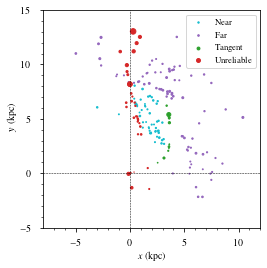

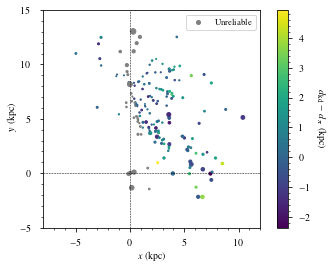

Median difference b/w kd and parallax-derived distances (kpc): 0.1448388388388353
Min & Max differences (kpc): -2.350662662662673 4.932098098098093
Min & Max abs(differences) (kpc): 0.0016566566566544871 4.932098098098093


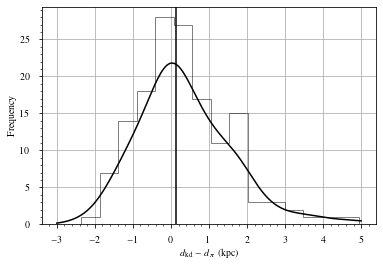

Median difference / combined uncertainty: 0.2644723127092225
Min & Max diff_ver_uncer: -2.320703296710533 5.320536054276414
Min & Max abs(diff_over_uncer): 0.004646181787460219 5.320536054276414


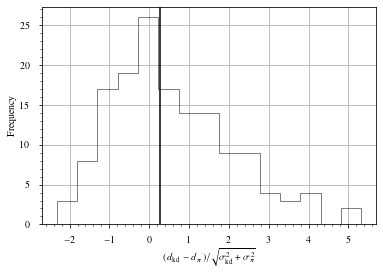

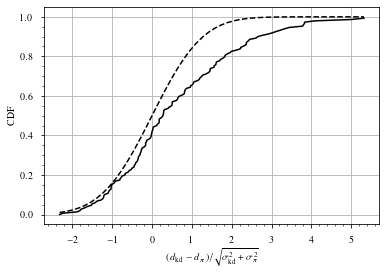

 KstestResult(statistic=0.2038344597942774, pvalue=6.630172804293523e-06) 


In [64]:
kdresults_input = "bimodal_wc21_1000x_pecTrue_krigeTrue_norm20_trough0.2.pkl"
plots_clean(kdresults_input, save_figs=False, print_stats=False,
            diff_threshold_low=-2.5, diff_threshold_high=6.0)

FILE LOADED: bimodal_wc21_1000x_pecTrue_krigeTrue_norm20_trough0.2_revLsr10.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
GC unreliable cutoff (deg): 15
Trough threshold: 0.2
Streaming motion uncertainty factor (km/s): 10
NUM OUTLIERS: 3
OUTLIERS: ['G015.66-00.49' 'G030.19-00.16' 'G030.22-00.18']
PLX COORDS (x): [1.20045211 2.36965597 1.71981602]
PLX COORDS (y): [3.92534917 4.09773916 5.19907449]
Total number of (non NaN) sources (cleaned): 199
Num near: 50	Num far: 81	Num tangent: 24	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs, cleaned): 0
Num NaNs in near, far, tangent (cleaned): 55 2 51
Number of sources with NaN in both 'near' and 'far' (cleaned): 2
Number of sources with NaN in both 'near' and 'tangent' (cleaned): 51
Number of sources with NaN in both 'far' and 'tangent' (cleaned): 0


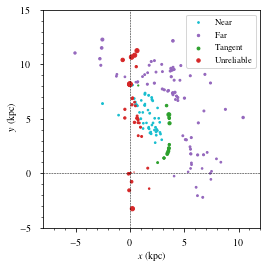

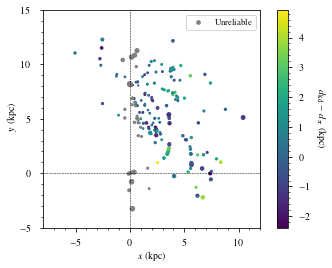

Median difference b/w kd and parallax-derived distances (kpc): 0.18074474474474034
Min & Max differences (kpc): -2.378503503503513 4.921742742742737
Min & Max abs(differences) (kpc): 0.0200250250250269 4.921742742742737


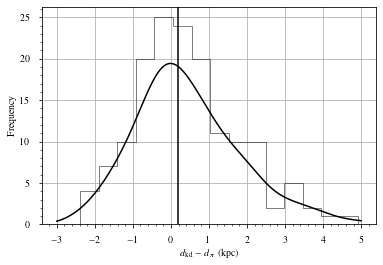

Median difference / combined uncertainty: 0.15227145042514023
Min & Max diff_ver_uncer: -3.270342631148707 3.7010488365587713
Min & Max abs(diff_over_uncer): 0.024666965666104275 3.7010488365587713


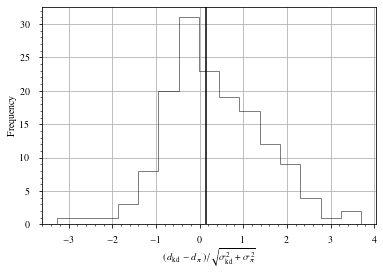

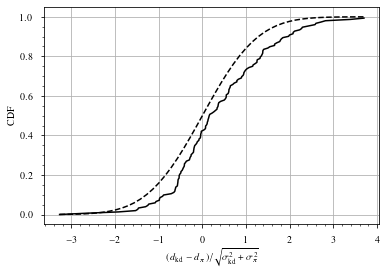

 KstestResult(statistic=0.14604586383853746, pvalue=0.002711027741643259) 


In [25]:
kdresults_input = "bimodal_wc21_1000x_pecTrue_krigeTrue_norm20_trough0.2_revLsr10.pkl"
plots_clean(kdresults_input, save_figs=False, print_stats=False,
            diff_threshold_low=-3.5, diff_threshold_high=4.0)

FILE LOADED: vlsrtol_wc21_1000x_pecTrue_krigeTrue_norm20_vlsrTolerance20.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
GC unreliable cutoff (deg): 15
vlsr tolerance (km/s): 20
Streaming motion uncertainty factor (km/s): None
NUM OUTLIERS: 3
OUTLIERS: ['G015.66-00.49' 'G030.22-00.18' 'G133.94+01.06']
PLX COORDS (x): [1.20045211 1.71981602 1.40428557]
PLX COORDS (y): [3.92534917 5.19907449 9.53718566]
Total number of (non NaN) sources (cleaned): 199
Num near: 27	Num far: 69	Num tangent: 59	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs, cleaned): 0
Num NaNs in near, far, tangent (cleaned): 54 3 48
Number of sources with NaN in both 'near' and 'far' (cleaned): 2
Number of sources with NaN in both 'near' and 'tangent' (cleaned): 48
Number of sources with NaN in both 'far' and 'tangent' (cleaned): 0


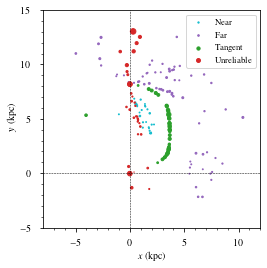

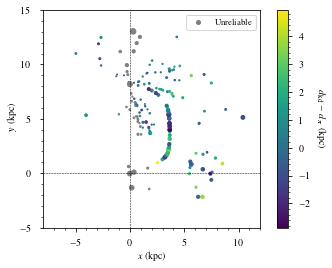

Median difference b/w kd and parallax-derived distances (kpc): 0.34981731731731425
Min & Max differences (kpc): -2.864996996997 4.932098098098093
Min & Max abs(differences) (kpc): 0.0016566566566544871 4.932098098098093


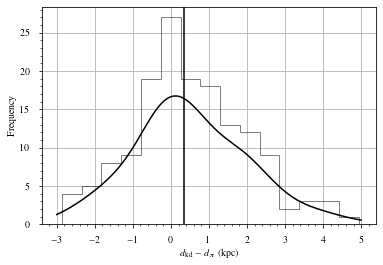

Median difference / combined uncertainty: 0.29820468613035456
Min & Max diff_ver_uncer: -1.880814072993434 4.1060317776205
Min & Max abs(diff_over_uncer): 0.004646181787460219 4.1060317776205


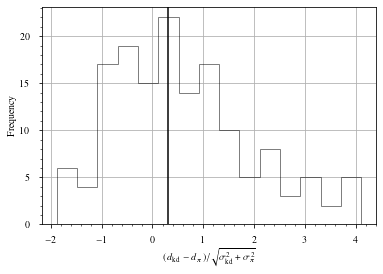

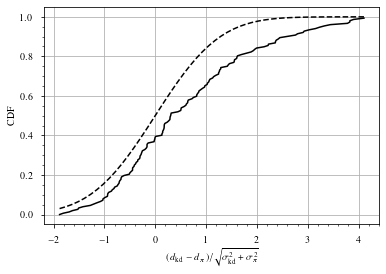

 KstestResult(statistic=0.19412677590586214, pvalue=1.7127626145454666e-05) 


In [69]:
kdresults_input = "vlsrtol_wc21_1000x_pecTrue_krigeTrue_norm20_vlsrTolerance20.pkl"
plots_clean(kdresults_input, save_figs=False, print_stats=False,
            diff_threshold_low=-2, diff_threshold_high=4.5)

FILE LOADED: vlsrtol_wc21pec3_1000x_pecTrue_krigeTrue_norm20_vlsrTolerance10_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
GC unreliable cutoff (deg): 15
vlsr tolerance (km/s): 10
Streaming motion uncertainty factor (km/s): 7.5
NUM OUTLIERS: 3
OUTLIERS: ['G015.66-00.49' 'G019.49+00.11' 'G030.22-00.18']
PLX COORDS (x): [1.20045211 0.90795466 1.71981602]
PLX COORDS (y): [3.92534917 5.62357063 5.19907449]
Total number of (non NaN) sources (cleaned): 199
Num near: 30	Num far: 75	Num tangent: 50	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs, cleaned): 0
Num NaNs in near, far, tangent (cleaned): 55 2 51
Number of sources with NaN in both 'near' and 'far' (cleaned): 2
Number of sources with NaN in both 'near' and 'tangent' (cleaned): 51
Number of sources with NaN in both 'far' and 'tangent' (cleaned): 0


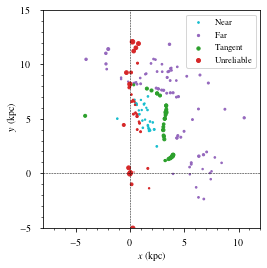

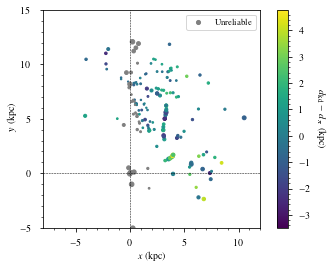

Median difference b/w kd and parallax-derived distances (kpc): 0.07635485485484994
Min & Max differences (kpc): -3.480851851851855 4.772215215215208
Min & Max abs(differences) (kpc): 0.0013473473473495368 4.772215215215208


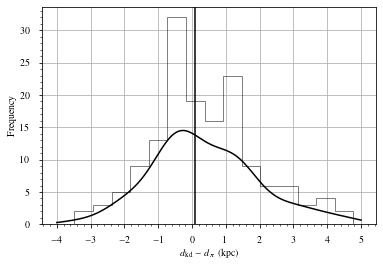

Median difference / combined uncertainty: 0.05489340263348631
Min & Max diff_ver_uncer: -1.890872248411447 2.7840257705304725
Min & Max abs(diff_over_uncer): 0.0016247633752101737 2.7840257705304725


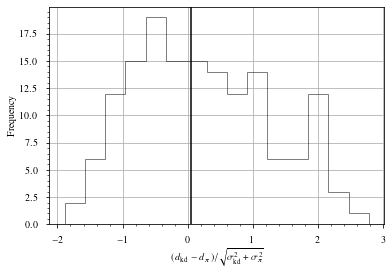

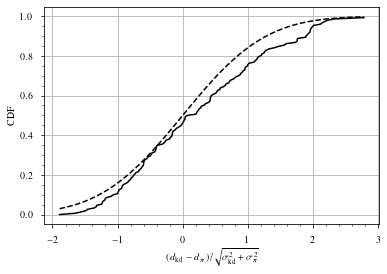

 KstestResult(statistic=0.10675944116221969, pvalue=0.058027534095546174) 


In [12]:
kdresults_input = "vlsrtol_wc21pec3_1000x_pecTrue_krigeTrue_norm20_vlsrTolerance10_revLsr7.5.pkl"
plots_clean(kdresults_input, save_figs=True, print_stats=False,
            diff_threshold_low=-2.0, diff_threshold_high=3.0)

FILE LOADED: vlsrtol_wc21_1000x_pecTrue_krigeFalse_vlsrTolerance10_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: False
Normalization factor: None
GC unreliable cutoff (deg): 15
vlsr tolerance (km/s): 10
Streaming motion uncertainty factor (km/s): 7.5
! Using outlier_list as outliers instead of diff_threshold values !
NUM OUTLIERS: 3
OUTLIERS: ['G015.66-00.49' 'G019.49+00.11' 'G030.22-00.18']
PLX COORDS (x): [1.20045211 0.90795466 1.71981602]
PLX COORDS (y): [3.92534917 5.62357063 5.19907449]
Total number of (non NaN) sources (cleaned): 199
Num near: 36	Num far: 76	Num tangent: 43	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs, cleaned): 0
Num NaNs in near, far, tangent (cleaned): 56 2 51
Number of sources with NaN in both 'near' and 'far' (cleaned): 2
Number of sources with NaN in both 'near' and 'tangent' (cleaned): 51
Number of sources with NaN in both 'far' and 'tangent' (cleaned): 0


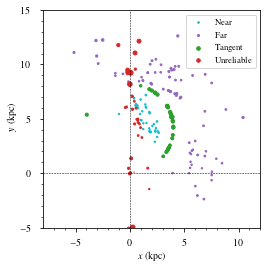

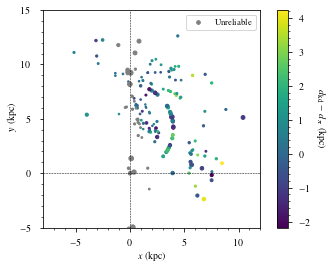

Median difference b/w kd and parallax-derived distances (kpc): 0.4770680680680659
Min & Max differences (kpc): -2.171962962962974 4.2273563563563465
Min & Max abs(differences) (kpc): 0.002272272272270781 4.2273563563563465


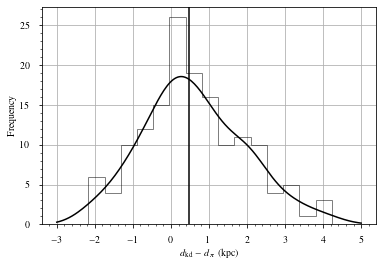

Median difference / combined uncertainty: 0.37319724821497535
Min & Max diff_ver_uncer: -1.9035817385609344 3.3599012444491225
Min & Max abs(diff_over_uncer): 0.0035653882303814124 3.3599012444491225


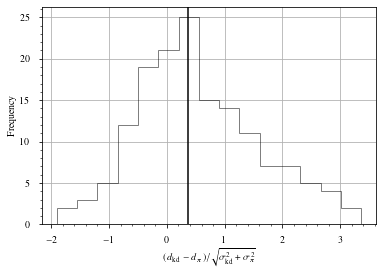

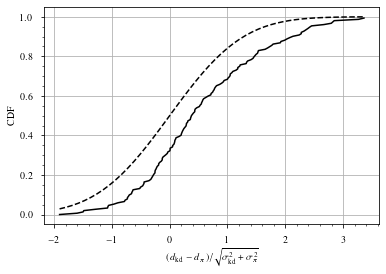

 KstestResult(statistic=0.1944556419258538, pvalue=1.646117122828364e-05) 


In [16]:
outliers = ['G015.66-00.49', 'G019.49+00.11', 'G030.22-00.18']
kdresults_input = "vlsrtol_wc21_1000x_pecTrue_krigeFalse_vlsrTolerance10_revLsr7.5.pkl"
plots_clean(kdresults_input, save_figs=False, print_stats=False, outlier_list=outliers)

FILE LOADED: vlsrtol_reid14_1000x_pecFalse_krigeFalse_vlsrTolerance10_revLsrNone.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: False
Using kriging: False
Normalization factor: None
GC unreliable cutoff (deg): 15
vlsr tolerance (km/s): 10
Streaming motion uncertainty factor (km/s): None
! Using outlier_list as outliers instead of diff_threshold values !
NUM OUTLIERS: 3
OUTLIERS: ['G015.66-00.49' 'G019.49+00.11' 'G030.22-00.18']
PLX COORDS (x): [1.20045211 0.90795466 1.71981602]
PLX COORDS (y): [3.92534917 5.62357063 5.19907449]
Total number of (non NaN) sources (cleaned): 199
Num near: 38	Num far: 75	Num tangent: 42	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs, cleaned): 0
Num NaNs in near, far, tangent (cleaned): 58 4 51
Number of sources with NaN in both 'near' and 'far' (cleaned): 4
Number of sources with NaN in both 'near' and 'tangent' (cleaned): 51
Number of sources with NaN in both 'far' and 'tangent' (cleaned): 0


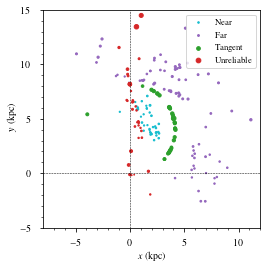

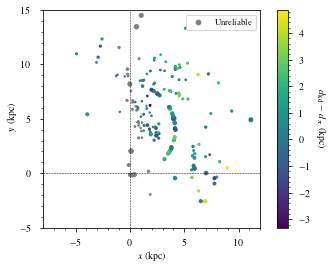

Median difference b/w kd and parallax-derived distances (kpc): 0.6687857857857797
Min & Max differences (kpc): -3.3111031031031057 4.865910910910899
Min & Max abs(differences) (kpc): 0.010831831831831007 4.865910910910899


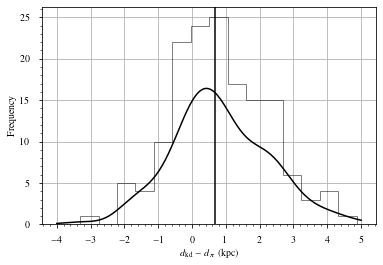

Median difference / combined uncertainty: 0.6158236775419385
Min & Max diff_ver_uncer: -3.4459090098148186 3.544759195253894
Min & Max abs(diff_over_uncer): 0.018815409855355153 3.544759195253894


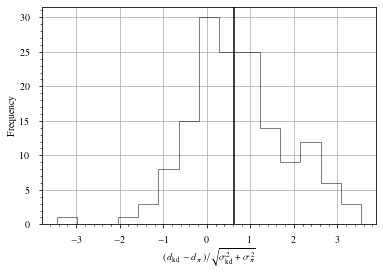

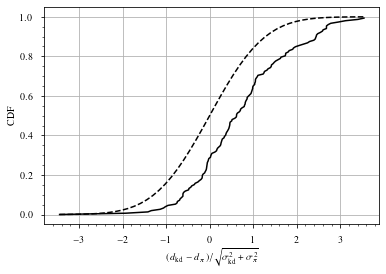

 KstestResult(statistic=0.24880523825101314, pvalue=8.92904747214839e-09) 


In [17]:
outliers = ['G015.66-00.49', 'G019.49+00.11', 'G030.22-00.18']
kdresults_input = "vlsrtol_reid14_1000x_pecFalse_krigeFalse_vlsrTolerance10_revLsrNone.pkl"
plots_clean(kdresults_input, save_figs=False, print_stats=False, outlier_list=outliers)

FILE LOADED: bimodal_wc21pec3_1000x_pecTrue_krigeTrue_norm20_trough0.2_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
GC unreliable cutoff (deg): 15
Trough threshold: 0.2
Streaming motion uncertainty factor (km/s): 7.5
NUM OUTLIERS: 10
OUTLIERS: ['G015.66-00.49' 'G019.49+00.11' 'G029.86-00.04' 'G030.19-00.16'
 'G030.22-00.18' 'G030.41-00.23' 'G030.81-00.05' 'G029.95-00.01'
 'G031.28+00.06' 'G081.87+00.78']
PLX COORDS (x): [1.20045211 0.90795466 2.18322324 2.36965597 1.71981602 1.97967461
 1.55765339 2.39244783 2.7633471  1.28871879]
PLX COORDS (y): [3.92534917 5.62357063 4.39554059 4.09773916 5.19907449 4.80750849
 5.57821973 4.0238044  3.61980909 7.99439578]
Total number of (non NaN) sources (cleaned): 192
Num near: 42	Num far: 78	Num tangent: 35	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs, cleaned): 0
Num NaNs in near, far, tangent (cleaned): 55 2 51
Number of sources with NaN in bo

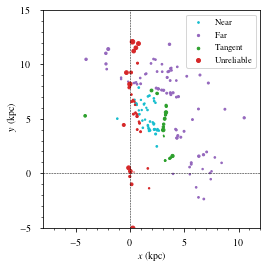

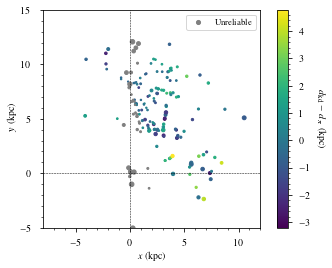

Median difference b/w kd and parallax-derived distances (kpc): -0.08252252252252923
Min & Max differences (kpc): -3.1977477477477514 4.772215215215208
Min & Max abs(differences) (kpc): 0.0013473473473495368 4.772215215215208


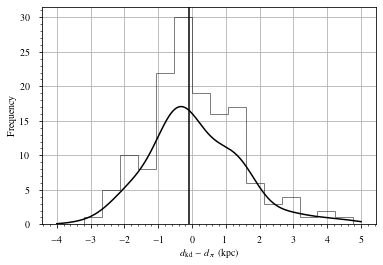

Median difference / combined uncertainty: -0.09864062077170292
Min & Max diff_ver_uncer: -2.3845447419447465 2.7840257705304725
Min & Max abs(diff_over_uncer): 0.0016247633752101737 2.7840257705304725


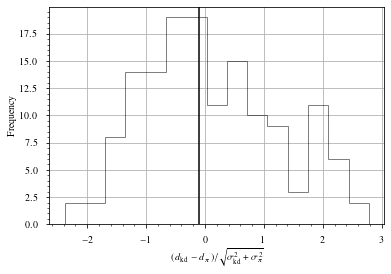

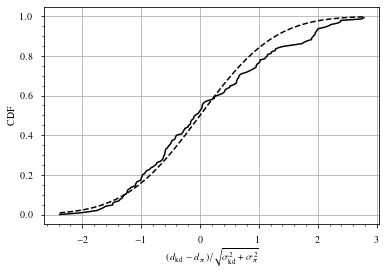

 KstestResult(statistic=0.09614498560135087, pvalue=0.12829064779643307) 


In [12]:
kdresults_input = "bimodal_wc21pec3_1000x_pecTrue_krigeTrue_norm20_trough0.2_revLsr7.5.pkl"
plots_clean(kdresults_input, save_figs=False, print_stats=False,
            diff_threshold_low=-3.0, diff_threshold_high=3.0)

FILE LOADED: bimodal_wc21_1000x_pecTrue_krigeFalse_trough0.2_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: False
Normalization factor: None
GC unreliable cutoff (deg): 15
Trough threshold: 0.2
Streaming motion uncertainty factor (km/s): 7.5
! Using outlier_list as outliers instead of diff_threshold values !
NUM OUTLIERS: 10
OUTLIERS: ['G015.66-00.49' 'G019.49+00.11' 'G029.86-00.04' 'G030.19-00.16'
 'G030.22-00.18' 'G030.41-00.23' 'G030.81-00.05' 'G029.95-00.01'
 'G031.28+00.06' 'G081.87+00.78']
PLX COORDS (x): [1.20045211 0.90795466 2.18322324 2.36965597 1.71981602 1.97967461
 1.55765339 2.39244783 2.7633471  1.28871879]
PLX COORDS (y): [3.92534917 5.62357063 4.39554059 4.09773916 5.19907449 4.80750849
 5.57821973 4.0238044  3.61980909 7.99439578]
Total number of (non NaN) sources (cleaned): 192
Num near: 53	Num far: 84	Num tangent: 18	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs, cleaned): 0
Num NaNs in near, far

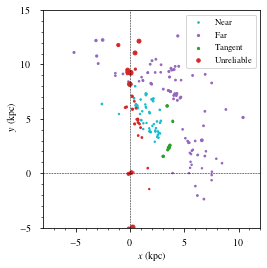

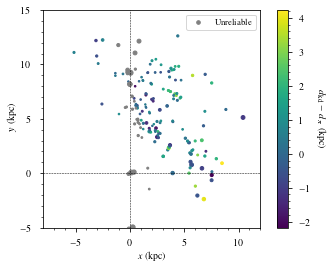

Median difference b/w kd and parallax-derived distances (kpc): 0.30418718718718596
Min & Max differences (kpc): -2.171962962962974 4.2273563563563465
Min & Max abs(differences) (kpc): 0.002272272272270781 4.2273563563563465


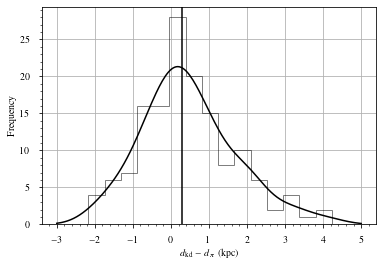

Median difference / combined uncertainty: 0.3766492522765214
Min & Max diff_ver_uncer: -3.416412476162874 3.3599012444491225
Min & Max abs(diff_over_uncer): 0.0035653882303814124 3.416412476162874


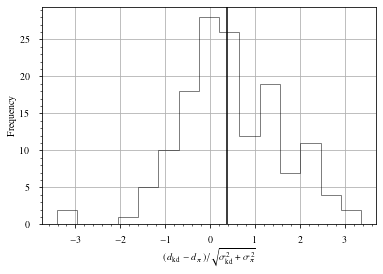

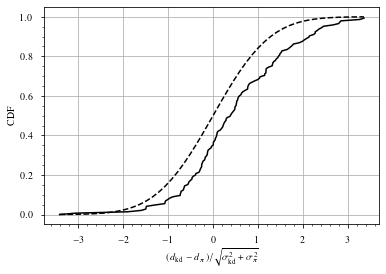

 KstestResult(statistic=0.17121782356372905, pvalue=0.0003468949435808509) 


In [18]:
outliers = [
    "G015.66-00.49", "G019.49+00.11", "G029.86-00.04", "G030.19-00.16", "G030.22-00.18",
    "G030.41-00.23", "G030.81-00.05", "G029.95-00.01", "G031.28+00.06", "G081.87+00.78"
]
kdresults_input = "bimodal_wc21_1000x_pecTrue_krigeFalse_trough0.2_revLsr7.5.pkl"
plots_clean(kdresults_input, save_figs=False, print_stats=False, outlier_list=outliers)

FILE LOADED: bimodal_reid14_1000x_pecFalse_krigeFalse_trough0.2_revLsrNone.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: False
Using kriging: False
Normalization factor: None
GC unreliable cutoff (deg): 15
Trough threshold: 0.2
Streaming motion uncertainty factor (km/s): None
! Using outlier_list as outliers instead of diff_threshold values !
NUM OUTLIERS: 10
OUTLIERS: ['G015.66-00.49' 'G019.49+00.11' 'G029.86-00.04' 'G030.19-00.16'
 'G030.22-00.18' 'G030.41-00.23' 'G030.81-00.05' 'G029.95-00.01'
 'G031.28+00.06' 'G081.87+00.78']
PLX COORDS (x): [1.20045211 0.90795466 2.18322324 2.36965597 1.71981602 1.97967461
 1.55765339 2.39244783 2.7633471  1.28871879]
PLX COORDS (y): [3.92534917 5.62357063 4.39554059 4.09773916 5.19907449 4.80750849
 5.57821973 4.0238044  3.61980909 7.99439578]
Total number of (non NaN) sources (cleaned): 192
Num near: 56	Num far: 83	Num tangent: 16	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs, cleaned): 0
Num NaNs in nea

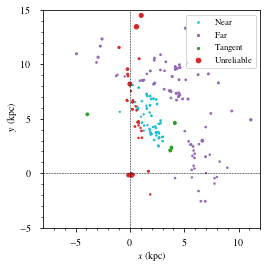

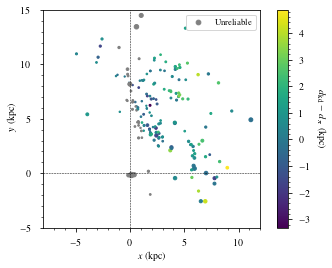

Median difference b/w kd and parallax-derived distances (kpc): 0.569356356356348
Min & Max differences (kpc): -3.3111031031031057 4.865910910910899
Min & Max abs(differences) (kpc): 0.010831831831831007 4.865910910910899


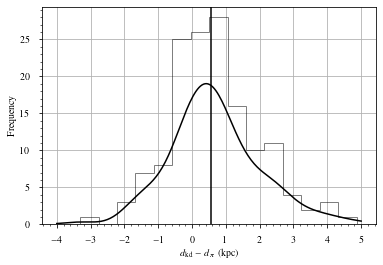

Median difference / combined uncertainty: 0.6131123475611209
Min & Max diff_ver_uncer: -3.4459090098148186 3.544759195253894
Min & Max abs(diff_over_uncer): 0.025309251415502096 3.544759195253894


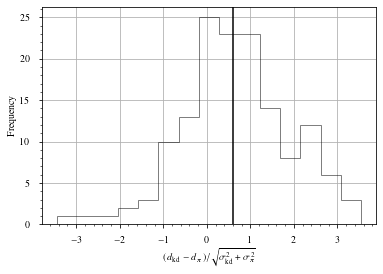

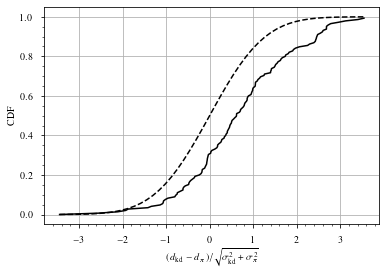

 KstestResult(statistic=0.24378362381657687, pvalue=4.507561117634459e-08) 


In [19]:
outliers = [
    "G015.66-00.49", "G019.49+00.11", "G029.86-00.04", "G030.19-00.16", "G030.22-00.18",
    "G030.41-00.23", "G030.81-00.05", "G029.95-00.01", "G031.28+00.06", "G081.87+00.78"
]
kdresults_input = "bimodal_reid14_1000x_pecFalse_krigeFalse_trough0.2_revLsrNone.pkl"
plots_clean(kdresults_input, save_figs=False, print_stats=False, outlier_list=outliers)

# Plots after removing outliers (HAA Talk ver.)

In [3]:
def plots_clean_haa(kd_results, save_figs=True, print_stats=False,
                    diff_threshold_low=-3.5, diff_threshold_high=6.0,
                    outlier_list=None):
    """
    Inputs:
      diff_threshold_low, diff_threshold_high :: scalars
        Parameters to control outlier rejection
        diff_threshold_low = minimum allowed dist_diff / e_dist_diff
        diff_threshold_high = maximum allowed dist_diff / e_dist_diff
        outlier_list = list or array of outliers by gname (strings).
          If passed in, WILL IGNORE DIFF_THRESHOLD values!
    """
    #
    # Load data
    #
    print("FILE LOADED:", kd_results)
    with open(Path.cwd() / kd_results, "rb") as f:
        file = dill.load(f)
        plxdata = file["plxdata"]
        kddata = file["kddata"]
        dist_kd = file["dist_kd"]
        e_dist_kd = file["e_dist_kd"]
        is_near = file["is_near"]
        is_far = file["is_far"]
        is_tangent = file["is_tangent"]
        is_unreliable = file["is_unreliable"]
        gc_threshold = file["gc_threshold"]
        if "trough" in kd_results:
            used_bimodal = True
            threshold = file["trough_threshold"]
        else:
            used_bimodal = False
            threshold = file["vlsr_tol"]
    dist_plx = plxdata["dist_mode"].values
    e_dist_plx = plxdata["dist_halfhpd"].values
    # plxfile = Path("pec_motions/csvfiles/alldata_HPDmode_NEW2.csv")
    # plxdata = pd.read_csv(Path.cwd().parent / plxfile)
    # dist_plx = plxdata["dist_mode"].values
    # e_dist_plx = plxdata["dist_halfhpd"].values
    #
    # RegEx stuff
    #
    # Find num_samples in kd
    num_samples = int(search("(\d+)x", kd_results).group(1))
    # Find if kd used kriging
    use_kriging = search("krige(.+?)", kd_results).group(1)
    use_kriging = use_kriging.lower() == "t"
    # Find if kd used peculiar motions
    use_peculiar = search("_pec(.+?)", kd_results).group(1)
    use_peculiar = use_peculiar.lower() == "t"
    # Find rotcurve used
    rotcurve = "clean_" + kd_results.split("_", 1)[0].replace(".", "") + "_"
    # Find normalization factor
    try:
        norm_factor = int(search("norm(\d+)", kd_results).group(1))
    except AttributeError:
        norm_factor = None
    # Append info to figure names
    figname_append = f"_{num_samples}x_pec{use_peculiar}_krige{use_kriging}"
    if norm_factor is not None:
        figname_append += f"_norm{norm_factor}"
    if used_bimodal:
        figname_append += f"_trough{threshold}_seaborn.png"
    else:
        figname_append += f"_vlsrTolerance{threshold}_seaborn.png"
    #
    # Print stats
    #
    print("=" * 6)
    print("Number of MC kd samples:", num_samples)
    print("Including peculiar motions in kd:", use_peculiar)
    print("Using kriging:", use_kriging)
    print("Normalization factor:", norm_factor)
    print("GC unreliable cutoff (deg):", gc_threshold)
    if used_bimodal:
        print("Trough threshold:", threshold)
    else:
        print("vlsr tolerance (km/s):", threshold)
    print("=" * 6)
    #
    # Calculate difference between kd and plx distances
    #
    dist_diff = dist_kd - dist_plx
    e_dist_diff = np.sqrt(e_dist_plx ** 2 + e_dist_kd ** 2)
    diff_over_uncer = dist_diff / e_dist_diff
    # Remove outliers
    if outlier_list is not None:
        print("! Using outlier_list as outliers instead of diff_threshold values !")
        # is_clean = plxdata["gname"].values not in outlier_list
        is_clean = ~np.isin(plxdata["gname"].values, outlier_list)
    else:
        is_clean = (diff_over_uncer > diff_threshold_low) & \
                (diff_over_uncer < diff_threshold_high)
    #
    is_nan = (~is_near) & (~is_far) & (~is_tangent)
    near_err = abs(kddata["near"] - dist_plx)
    far_err = abs(kddata["far"] - dist_plx)
    tangent_err = abs(kddata["tangent"] - dist_plx)
    print("NUM OUTLIERS:", np.sum((~is_clean) & (~is_unreliable)))
    print("OUTLIERS:", plxdata["gname"].values[(~is_clean) & (~is_unreliable)])
    print("PLX COORDS (x):", plxdata["x_mode"].values[(~is_clean) & (~is_unreliable)])
    print("PLX COORDS (y):", plxdata["y_mode"].values[(~is_clean) & (~is_unreliable)])
    print("=" * 6)
    # 
    print("Total number of (non NaN) sources (cleaned):", np.isfinite(dist_kd).sum() - ((~is_clean) & (~is_unreliable)).sum())
    print(
        f"Num near: {np.sum((is_near) & (~is_unreliable))}"
        + f"\tNum far: {np.sum((is_far) & (~is_unreliable))}"
        + f"\tNum tangent: {np.sum((is_tangent) & (~is_unreliable))}"
        + f"\tNum unreliable: {np.sum((is_unreliable) & (~is_nan))}"
    )
    print("Number of NaN sources (i.e. all dists are NaNs, cleaned):", np.sum((is_nan) & (is_clean)))
    print(
        "Num NaNs in near, far, tangent (cleaned):",
        np.sum((np.isnan(near_err)) & (is_clean)),
        np.sum((np.isnan(far_err)) & (is_clean)),
        np.sum((np.isnan(tangent_err)) & (is_clean)),
    )
    print(
        "Number of sources with NaN in both 'near' and 'far' (cleaned):",
        sum(np.isnan(kddata["near"]) & np.isnan(kddata["far"]) & (is_clean)),
    )
    print(
        "Number of sources with NaN in both 'near' and 'tangent' (cleaned):",
        sum(np.isnan(kddata["near"]) & np.isnan(kddata["tangent"]) & (is_clean)),
    )
    print(
        "Number of sources with NaN in both 'far' and 'tangent' (cleaned):",
        sum(np.isnan(kddata["far"]) & np.isnan(kddata["tangent"]) & (is_clean)),
    )
    # Print following if two distances are selected:
    num_near_far = np.sum((is_near) & (is_far) & (is_clean))
    num_near_tan = np.sum((is_near) & (is_tangent) & (is_clean))
    num_far_tan = np.sum((is_far) & (is_tangent) & (is_clean))
    if any([num_near_far, num_near_tan, num_far_tan]):
        print("(Cleaned) Both near and far (should be 0):", num_near_far)
        print("(Cleaned) Both near and tan (should be 0):", num_near_tan)
        print("(Cleaned) Both far and tan (should be 0):", num_far_tan)
    print("=" * 6)
    # 
    # Update plot parameters
    # 
    white_params = {
        "ytick.color" : "w",
        "xtick.color" : "w",
        "axes.labelcolor" : "w",
        "axes.edgecolor" : "w",
    }
    plt.rcParams.update(white_params)
    #
    # Create face-on map with kinematic distances
    #
    # Convert to galactocentric frame
    glong = plxdata["glong"].values
    glat = plxdata["glat"].values
    Xb, Yb, Zb = trans.gal_to_bary(glong, glat, dist_kd)
    Xg, Yg, Zg = trans.bary_to_gcen(Xb, Yb, Zb, R0=_R0, Zsun=_ZSUN, roll=_ROLL)
    # Rotate 90 deg CW (so Sun is on +y-axis)
    Xg, Yg = Yg, -Xg
    #
    # fig, ax = plt.subplots()
    # size_scale = 4  # scaling factor for size
    # #
    # ax.scatter(
    #     Xg[(is_near) & (~is_unreliable) & (is_clean)],
    #     Yg[(is_near) & (~is_unreliable) & (is_clean)],
    #     c="tab:cyan",
    #     s=e_dist_kd[(is_near) & (~is_unreliable) & (is_clean)] * size_scale,
    #     label="Near",
    # )
    # #
    # ax.scatter(
    #     Xg[(is_far) & (~is_unreliable) & (is_clean)],
    #     Yg[(is_far) & (~is_unreliable) & (is_clean)],
    #     c="tab:purple",
    #     s=e_dist_kd[(is_far) & (~is_unreliable) & (is_clean)] * size_scale,
    #     label="Far",
    # )
    # #
    # ax.scatter(
    #     Xg[(is_tangent) & (~is_unreliable) & (is_clean)],
    #     Yg[(is_tangent) & (~is_unreliable) & (is_clean)],
    #     c="tab:green",
    #     s=e_dist_kd[(is_tangent) & (~is_unreliable) & (is_clean)] * size_scale,
    #     label="Tangent",
    # )
    # #
    # ax.scatter(
    #     Xg[(is_unreliable) & (is_clean)],
    #     Yg[(is_unreliable) & (is_clean)],
    #     c="tab:red",
    #     s=e_dist_kd[(is_unreliable) & (is_clean)] * size_scale,
    #     label="Unreliable",
    # )
    # ax.legend(fontsize=9)
    # ax.set_xlabel("$x$ (kpc)")
    # ax.set_ylabel("$y$ (kpc)")
    # ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    # ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    # ax.set_xlim(-8, 12)
    # ax.set_xticks([-5, 0, 5, 10])
    # ax.set_ylim(-5, 15)
    # ax.set_yticks([-5, 0, 5, 10, 15])
    # ax.grid(False)
    # ax.set_aspect("equal")
    # figname = rotcurve + "faceonplx" + figname_append
    # fig.savefig(figname, bbox_inches="tight", dpi=300, transparent=True) if save_figs else None
    # plt.show()
    # #
    # # Plot
    # #
    # # Face on view of differences
    # fig, ax = plt.subplots()
    # #
    # cmap = "viridis"
    # norm = mpl.colors.Normalize(
    #     vmin=np.nanmin(dist_diff[(~is_unreliable) & (is_clean)]),
    #     vmax=np.nanmax(dist_diff[(~is_unreliable) & (is_clean)]),
    # )
    # ax.scatter(
    #     Xg[(~is_unreliable) & (is_clean)],
    #     Yg[(~is_unreliable) & (is_clean)],
    #     c=dist_diff[(~is_unreliable) & (is_clean)],
    #     s=e_dist_diff[(~is_unreliable) & (is_clean)] * size_scale,
    #     cmap=cmap,
    #     norm=norm,
    # )
    # ax.scatter(
    #     Xg[(is_unreliable) & (is_clean)],
    #     Yg[(is_unreliable) & (is_clean)],
    #     c="grey",
    #     s=e_dist_diff[(is_unreliable) & (is_clean)] * size_scale,
    #     label="Unreliable",
    # )
    # cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    # cbar.ax.set_ylabel(r"$d_{\rm kd} - d_\pi$ (kpc)", rotation=270)
    # cbar.ax.get_yaxis().labelpad = 15
    # ax.legend(fontsize=9)
    # ax.set_xlabel("$x$ (kpc)")
    # ax.set_ylabel("$y$ (kpc)")
    # ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    # ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    # ax.set_xlim(-8, 12)
    # ax.set_xticks([-5, 0, 5, 10])
    # ax.set_ylim(-5, 15)
    # ax.set_yticks([-5, 0, 5, 10, 15])
    # ax.grid(False)
    # ax.set_aspect("equal")
    # figname = rotcurve + "faceonplxDiffs" + figname_append
    # fig.savefig(figname, bbox_inches="tight", dpi=300, transparent=True) if save_figs else None
    # plt.show()
    # Histogram of differences
    fig, ax = plt.subplots()
    ax.hist(dist_diff[(~is_unreliable) & (is_clean)], bins=15,
            histtype="step", color="#66c2a5", alpha=1)  # seaborn green
    median_diff = np.median(dist_diff[(~is_unreliable) & (is_clean)])
    ax.axvline(median_diff, color="#8da0cb")  # seaborn blue
    print("Median difference b/w kd and parallax-derived distances (kpc):", median_diff)
    print(
        "Min & Max differences (kpc):",
        np.min(dist_diff[(~is_unreliable) & (is_clean)]),
        np.max(dist_diff[(~is_unreliable) & (is_clean)]),
    )
    print(
        "Min & Max abs(differences) (kpc):",
        np.min(abs(dist_diff[(~is_unreliable) & (is_clean)])),
        np.max(abs(dist_diff[(~is_unreliable) & (is_clean)])),
    )
    # Add KDE to histogram
    kde = gaussian_kde(dist_diff[(~is_unreliable) & (is_clean)])
    # xlims = (
    #     np.floor(np.min(dist_diff[(~is_unreliable) & (is_clean)])),
    #     np.ceil(np.max(dist_diff[(~is_unreliable) & (is_clean)])),
    # )
    xlims = (-5, 5)
    xlabels = np.arange(xlims[0], xlims[1] + 1, 1, dtype=int)
    diffs = np.linspace(*xlims, 200)
    kde = kde(diffs)
    ax.plot(diffs, kde * np.sum(kde) * 2.5, color="#fc8d62")  # seaborn orange
    ax.set_xlabel(r"$d_{\rm kd} - d_\pi$ (kpc)")
    ax.set_ylabel("Frequency")
    ax.set_xticks(xlabels)
    ax.axvline(0, color="white", linestyle="dashed", linewidth=1, alpha=0.5)
    ax.set_xlim(*xlims)
    ax.grid(False)
    ax.text(0.02, 0.9, f'Median = {median_diff:.3f}', transform=ax.transAxes, color="#f0be52")
    figname = rotcurve + "kd_plx_diff_hist" + figname_append
    fig.savefig(figname, bbox_inches="tight", dpi=300, transparent=True) if save_figs else None
    plt.show()
    # # Plot histogram of kinematic distance difference / combined uncertainty
    # fig, ax = plt.subplots()
    # ax.hist(
    #     diff_over_uncer[(~is_unreliable) & (is_clean)],
    #     bins=15, histtype="step", color="#66c2a5", alpha=1
    # )  # seaborn green
    # median_diff_over_uncer = np.median(diff_over_uncer[(~is_unreliable) & (is_clean)])
    # ax.axvline(median_diff_over_uncer, color="#8da0cb")  # seaborn blue
    # ax.set_xlabel(r"$(d_{\rm kd} - d_\pi) / \sqrt{\sigma^2_{\rm kd} + \sigma^2_\pi}$")
    # ax.set_ylabel("Frequency")
    # print("Median difference / combined uncertainty:", median_diff_over_uncer)
    # print(
    #     "Min & Max diff_ver_uncer:",
    #     np.min(diff_over_uncer[(~is_unreliable) & (is_clean)]),
    #     np.max(diff_over_uncer[(~is_unreliable) & (is_clean)]),
    # )
    # print(
    #     "Min & Max abs(diff_over_uncer):",
    #     np.min(abs(diff_over_uncer[(~is_unreliable) & (is_clean)])),
    #     np.max(abs(diff_over_uncer[(~is_unreliable) & (is_clean)])),
    # )
    # ax.grid(True)
    # figname = rotcurve + "kd_plx_diffOverUncer_hist" + figname_append
    # fig.savefig(figname, bbox_inches="tight", dpi=300, transparent=True) if save_figs else None
    # plt.show()
    # CDF of differences over total error
    fig, ax = plt.subplots()
    cdf_data = np.sort(dist_diff[(~is_unreliable) & (is_clean)] / e_dist_diff[(~is_unreliable) & (is_clean)])
    ks_stat, p_val = kstest(cdf_data, gaussian_cdf, N=cdf_data.size, mode="exact")
    # xlims = (np.min(cdf_data), np.max(cdf_data))
    xlims = (-3, 3)
    cdf_x = np.linspace(*xlims)
    ax.plot(cdf_x, gaussian_cdf(cdf_x), linestyle="dashed", color="#fc8d62")  # seaborn orange
    ax.plot(cdf_data, np.arange(cdf_data.size) / cdf_data.size, color="#66c2a5")  # seaborn green
    ax.set_xlim(*xlims)
    ax.set_xlabel(r"$(d_{\rm kd} - d_\pi) / \sqrt{\sigma^2_{\rm kd} + \sigma^2_\pi}$")
    ax.set_ylabel("CDF")
    ax.text(0.02, 0.9, f'K-S stat = {ks_stat:.3f}', transform=ax.transAxes, color="#f0be52")
    ax.grid(True)
    figname = rotcurve + "kd_plx_diff_CDF" + figname_append
    fig.savefig(figname, bbox_inches="tight", dpi=300, transparent=True) if save_figs else None
    plt.show()
    #
    # K-S test
    #
    print(
        "======\n",
        kstest(cdf_data, gaussian_cdf, N=cdf_data.size, mode="exact"),
        "\n======",
    )
    #
    if print_stats:
        #
        # Print stats
        #
        kdtypes = [
            (is_near) & (~is_unreliable) & (is_clean),
            (is_far) & (~is_unreliable) & (is_clean),
            (is_tangent) & (~is_unreliable) & (is_clean),
            is_unreliable,
        ]
        kdnames = ["Near", "Far", "Tangent", "Unreliable"]
        for kdtype, kdname in zip(kdtypes, kdnames):
            print("=" * 3, kdname + " sources", "=" * 3)
            df_plx = plxdata[["gname", "glong", "glat", "vlsr_med", "dist_mode"]][kdtype]
            print()
            df_kd = kddata[["near", "far", "tangent", "vlsr_tangent"]][kdtype]
            df_tot = pd.concat([df_plx, df_kd], axis=1)
            print(df_tot.to_string())
            print(f"Number of {kdname} sources:", len(df_tot))

FILE LOADED: vlsrtol_wc21pec3_1000x_pecTrue_krigeTrue_norm20_vlsrTolerance10_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
GC unreliable cutoff (deg): 15
vlsr tolerance (km/s): 10
NUM OUTLIERS: 3
OUTLIERS: ['G015.66-00.49' 'G019.49+00.11' 'G030.22-00.18']
PLX COORDS (x): [1.20045211 0.90795466 1.71981602]
PLX COORDS (y): [3.92534917 5.62357063 5.19907449]
Total number of (non NaN) sources (cleaned): 199
Num near: 30	Num far: 75	Num tangent: 50	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs, cleaned): 0
Num NaNs in near, far, tangent (cleaned): 55 2 51
Number of sources with NaN in both 'near' and 'far' (cleaned): 2
Number of sources with NaN in both 'near' and 'tangent' (cleaned): 51
Number of sources with NaN in both 'far' and 'tangent' (cleaned): 0
Median difference b/w kd and parallax-derived distances (kpc): 0.07635485485484994
Min & Max differences (kpc): -3.480851851851855 4.77221

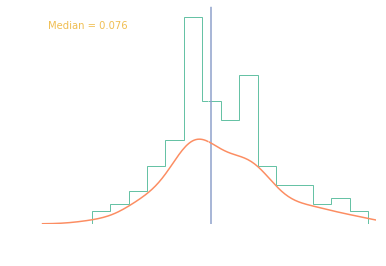

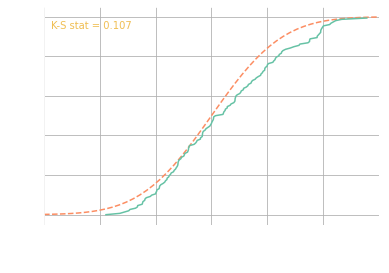

 KstestResult(statistic=0.10675944116221969, pvalue=0.058027534095546174) 


In [4]:
kdresults_input = "vlsrtol_wc21pec3_1000x_pecTrue_krigeTrue_norm20_vlsrTolerance10_revLsr7.5.pkl"
plots_clean_haa(kdresults_input, save_figs=True, print_stats=False,
                diff_threshold_low=-2.0, diff_threshold_high=3.0)

FILE LOADED: vlsrtol_wc21_1000x_pecTrue_krigeFalse_vlsrTolerance10_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: False
Normalization factor: None
GC unreliable cutoff (deg): 15
vlsr tolerance (km/s): 10
! Using outlier_list as outliers instead of diff_threshold values !
NUM OUTLIERS: 3
OUTLIERS: ['G015.66-00.49' 'G019.49+00.11' 'G030.22-00.18']
PLX COORDS (x): [1.20045211 0.90795466 1.71981602]
PLX COORDS (y): [3.92534917 5.62357063 5.19907449]
Total number of (non NaN) sources (cleaned): 199
Num near: 36	Num far: 76	Num tangent: 43	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs, cleaned): 0
Num NaNs in near, far, tangent (cleaned): 56 2 51
Number of sources with NaN in both 'near' and 'far' (cleaned): 2
Number of sources with NaN in both 'near' and 'tangent' (cleaned): 51
Number of sources with NaN in both 'far' and 'tangent' (cleaned): 0
Median difference b/w kd and parallax-derived distances (kpc): 0.477068068068

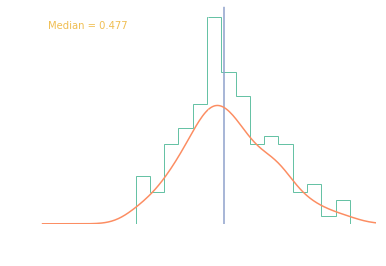

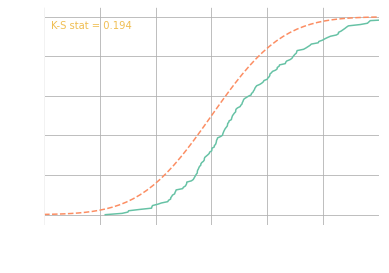

 KstestResult(statistic=0.1944556419258538, pvalue=1.646117122828364e-05) 


In [5]:
outliers = ['G015.66-00.49', 'G019.49+00.11', 'G030.22-00.18']
kdresults_input = "vlsrtol_wc21_1000x_pecTrue_krigeFalse_vlsrTolerance10_revLsr7.5.pkl"
plots_clean_haa(kdresults_input, save_figs=True, print_stats=False, outlier_list=outliers)

FILE LOADED: vlsrtol_reid14_1000x_pecFalse_krigeFalse_vlsrTolerance10_revLsrNone.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: False
Using kriging: False
Normalization factor: None
GC unreliable cutoff (deg): 15
vlsr tolerance (km/s): 10
! Using outlier_list as outliers instead of diff_threshold values !
NUM OUTLIERS: 3
OUTLIERS: ['G015.66-00.49' 'G019.49+00.11' 'G030.22-00.18']
PLX COORDS (x): [1.20045211 0.90795466 1.71981602]
PLX COORDS (y): [3.92534917 5.62357063 5.19907449]
Total number of (non NaN) sources (cleaned): 199
Num near: 38	Num far: 75	Num tangent: 42	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs, cleaned): 0
Num NaNs in near, far, tangent (cleaned): 58 4 51
Number of sources with NaN in both 'near' and 'far' (cleaned): 4
Number of sources with NaN in both 'near' and 'tangent' (cleaned): 51
Number of sources with NaN in both 'far' and 'tangent' (cleaned): 0
Median difference b/w kd and parallax-derived distances (kpc): 0.6687857

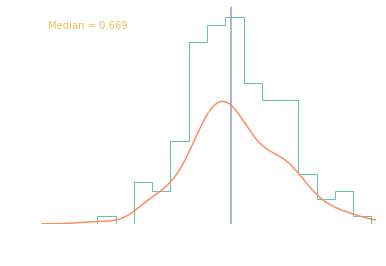

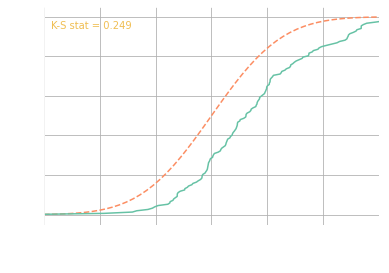

 KstestResult(statistic=0.24880523825101314, pvalue=8.92904747214839e-09) 


In [9]:
outliers = ['G015.66-00.49', 'G019.49+00.11', 'G030.22-00.18']
kdresults_input = "vlsrtol_reid14_1000x_pecFalse_krigeFalse_vlsrTolerance10_revLsrNone.pkl"
plots_clean_haa(kdresults_input, save_figs=True, print_stats=False, outlier_list=outliers)

FILE LOADED: bimodal_wc21pec3_1000x_pecTrue_krigeTrue_norm20_trough0.2_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: True
Normalization factor: 20
GC unreliable cutoff (deg): 15
Trough threshold: 0.2
NUM OUTLIERS: 10
OUTLIERS: ['G015.66-00.49' 'G019.49+00.11' 'G029.86-00.04' 'G030.19-00.16'
 'G030.22-00.18' 'G030.41-00.23' 'G030.81-00.05' 'G029.95-00.01'
 'G031.28+00.06' 'G081.87+00.78']
PLX COORDS (x): [1.20045211 0.90795466 2.18322324 2.36965597 1.71981602 1.97967461
 1.55765339 2.39244783 2.7633471  1.28871879]
PLX COORDS (y): [3.92534917 5.62357063 4.39554059 4.09773916 5.19907449 4.80750849
 5.57821973 4.0238044  3.61980909 7.99439578]
Total number of (non NaN) sources (cleaned): 192
Num near: 42	Num far: 78	Num tangent: 35	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs, cleaned): 0
Num NaNs in near, far, tangent (cleaned): 55 2 51
Number of sources with NaN in both 'near' and 'far' (cleaned): 2
Number of sourc

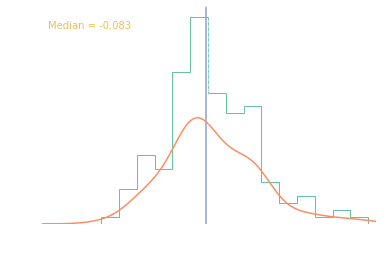

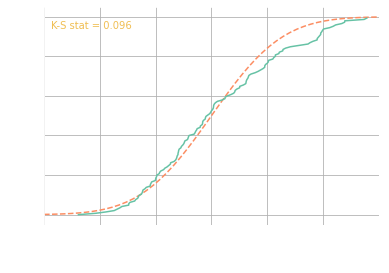

 KstestResult(statistic=0.09614498560135087, pvalue=0.12829064779643307) 


In [4]:
kdresults_input = "bimodal_wc21pec3_1000x_pecTrue_krigeTrue_norm20_trough0.2_revLsr7.5.pkl"
plots_clean_haa(kdresults_input, save_figs=True, print_stats=False,
                diff_threshold_low=-3.0, diff_threshold_high=3.0)

FILE LOADED: bimodal_wc21_1000x_pecTrue_krigeFalse_trough0.2_revLsr7.5.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: True
Using kriging: False
Normalization factor: None
GC unreliable cutoff (deg): 15
Trough threshold: 0.2
! Using outlier_list as outliers instead of diff_threshold values !
NUM OUTLIERS: 10
OUTLIERS: ['G015.66-00.49' 'G019.49+00.11' 'G029.86-00.04' 'G030.19-00.16'
 'G030.22-00.18' 'G030.41-00.23' 'G030.81-00.05' 'G029.95-00.01'
 'G031.28+00.06' 'G081.87+00.78']
PLX COORDS (x): [1.20045211 0.90795466 2.18322324 2.36965597 1.71981602 1.97967461
 1.55765339 2.39244783 2.7633471  1.28871879]
PLX COORDS (y): [3.92534917 5.62357063 4.39554059 4.09773916 5.19907449 4.80750849
 5.57821973 4.0238044  3.61980909 7.99439578]
Total number of (non NaN) sources (cleaned): 192
Num near: 53	Num far: 84	Num tangent: 18	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs, cleaned): 0
Num NaNs in near, far, tangent (cleaned): 56 2 51
Number of sources w

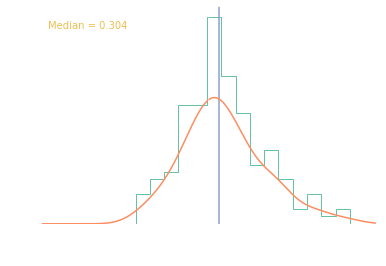

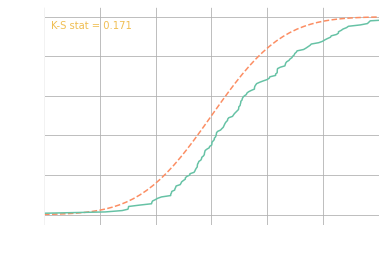

 KstestResult(statistic=0.17121782356372905, pvalue=0.0003468949435808509) 


In [7]:
outliers = [
    "G015.66-00.49", "G019.49+00.11", "G029.86-00.04", "G030.19-00.16", "G030.22-00.18",
    "G030.41-00.23", "G030.81-00.05", "G029.95-00.01", "G031.28+00.06", "G081.87+00.78"
]
kdresults_input = "bimodal_wc21_1000x_pecTrue_krigeFalse_trough0.2_revLsr7.5.pkl"
plots_clean_haa(kdresults_input, save_figs=True, print_stats=False, outlier_list=outliers)

FILE LOADED: bimodal_reid14_1000x_pecFalse_krigeFalse_trough0.2_revLsrNone.pkl
Number of MC kd samples: 1000
Including peculiar motions in kd: False
Using kriging: False
Normalization factor: None
GC unreliable cutoff (deg): 15
Trough threshold: 0.2
! Using outlier_list as outliers instead of diff_threshold values !
NUM OUTLIERS: 10
OUTLIERS: ['G015.66-00.49' 'G019.49+00.11' 'G029.86-00.04' 'G030.19-00.16'
 'G030.22-00.18' 'G030.41-00.23' 'G030.81-00.05' 'G029.95-00.01'
 'G031.28+00.06' 'G081.87+00.78']
PLX COORDS (x): [1.20045211 0.90795466 2.18322324 2.36965597 1.71981602 1.97967461
 1.55765339 2.39244783 2.7633471  1.28871879]
PLX COORDS (y): [3.92534917 5.62357063 4.39554059 4.09773916 5.19907449 4.80750849
 5.57821973 4.0238044  3.61980909 7.99439578]
Total number of (non NaN) sources (cleaned): 192
Num near: 56	Num far: 83	Num tangent: 16	Num unreliable: 47
Number of NaN sources (i.e. all dists are NaNs, cleaned): 0
Num NaNs in near, far, tangent (cleaned): 58 4 51
Number of sour

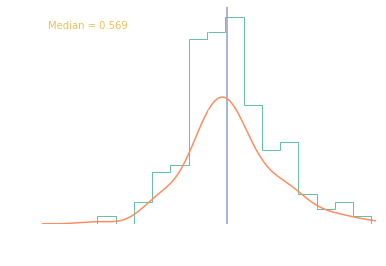

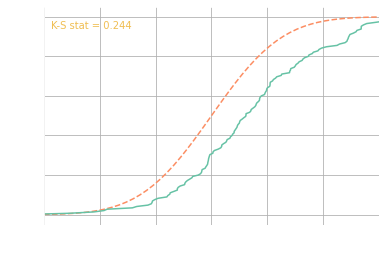

 KstestResult(statistic=0.24378362381657687, pvalue=4.507561117634459e-08) 


In [8]:
outliers = [
    "G015.66-00.49", "G019.49+00.11", "G029.86-00.04", "G030.19-00.16", "G030.22-00.18",
    "G030.41-00.23", "G030.81-00.05", "G029.95-00.01", "G031.28+00.06", "G081.87+00.78"
]
kdresults_input = "bimodal_reid14_1000x_pecFalse_krigeFalse_trough0.2_revLsrNone.pkl"
plots_clean_haa(kdresults_input, save_figs=True, print_stats=False, outlier_list=outliers)

# Code to plot differences between bimodal vs. vlsr_tolerance

In [80]:
def bimodal_vlsr_diffs(bimodal_file, vlsr_file, save_figs=True):
    # 
    # Load data
    # 
    with open(Path.cwd() / bimodal_file, "rb") as fb:
        b_file = dill.load(fb)
        plxdata = b_file["plxdata"]
        b_kddata = b_file["kddata"]
        b_dist_kd = b_file["dist_kd"]
        b_e_dist_kd = b_file["e_dist_kd"]
        b_is_near = b_file["is_near"]
        b_is_far = b_file["is_far"]
        b_is_tangent = b_file["is_tangent"]
        b_is_unreliable = b_file["is_unreliable"]
        b_gc_threshold = b_file["gc_threshold"]
        b_trough_threshold = b_file["trough_threshold"]
    with open(Path.cwd() / vlsr_file, "rb") as fv:
        v_file = dill.load(fv)
        # v_plxdata = v_file["plxdata"]
        v_kddata = v_file["kddata"]
        v_dist_kd = v_file["dist_kd"]
        v_e_dist_kd = v_file["e_dist_kd"]
        v_is_near = v_file["is_near"]
        v_is_far = v_file["is_far"]
        v_is_tangent = v_file["is_tangent"]
        v_is_unreliable = v_file["is_unreliable"]
        v_gc_threshold = v_file["gc_threshold"]
        v_vlsr_tol = v_file["vlsr_tol"]
    # 
    only_bimodal = (b_is_tangent) & (~b_is_unreliable) & (~v_is_tangent) & (~v_is_unreliable)
    only_vlsr_tol = (v_is_tangent) & (~v_is_unreliable) & (~b_is_tangent) & (~b_is_unreliable)
    both = (b_is_tangent) & (~b_is_unreliable) & (v_is_tangent) & (~v_is_unreliable)
    print("Number of only bimodal tangents:", sum(only_bimodal))
    print("Number of only vlsr_tol tangents:", sum(only_vlsr_tol))
    print("Number of tangents in both:", sum(both))
    dist_plx = plxdata["dist_mode"].values
    e_dist_plx = plxdata["dist_halfhpd"].values
    # 
    # Plot tangent sources
    # 
    # Convert to galactocentric frame
    glong = plxdata["glong"].values
    glat = plxdata["glat"].values
    is_q1 = (glong >= 0) & (glong < 90)
    is_q4 = (glong >= 270) & (glong < 360)
    # Bimodal sources
    b_Xb, b_Yb, b_Zb = trans.gal_to_bary(glong, glat, b_dist_kd)
    b_Xg, b_Yg, b_Zg = trans.bary_to_gcen(b_Xb, b_Yb, b_Zb, R0=_R0, Zsun=_ZSUN, roll=_ROLL)
    # vlsr_tol sources
    v_Xb, v_Yb, v_Zb = trans.gal_to_bary(glong, glat, v_dist_kd)
    v_Xg, v_Yg, v_Zg = trans.bary_to_gcen(v_Xb, v_Yb, v_Zb, R0=_R0, Zsun=_ZSUN, roll=_ROLL)
    # Rotate 90 deg CW (so Sun is on +y-axis)
    b_Xg, b_Yg = b_Yg, -b_Xg
    v_Xg, v_Yg = v_Yg, -v_Xg
    # print("--- Only bimodal tangent sources ---")
    # fields = ["gname", "glong", "glat", "plx", "e_plx", "vlsr_med", "vlsr_std",
    #           "dist_mode", "dist_halfhpd", "is_tooclose", "is_outlier"]
    # print(plxdata[fields][only_bimodal].to_markdown())
    # print("Dists:", b_dist_kd[only_bimodal])
    # print("vlsr_tangent:", b_kddata["vlsr_tangent"][only_bimodal])
    # print("vlsr_tangent_err_neg:", b_kddata["vlsr_tangent_err_neg"][only_bimodal])
    # print("vlsr_tangent_err_pos:", b_kddata["vlsr_tangent_err_pos"][only_bimodal])
    # print("X:", b_Xg[only_bimodal])
    # print("Y:", b_Yg[only_bimodal])
    # gc_good = (glong > 16) & (glong < 344)
    # print(f"Sources really close to GC direction in 'both' category. trough={b_trough_threshold}")
    # print(plxdata[fields][(both) & (~gc_good)].to_markdown())
    # print("Dists:", b_dist_kd[(both) & (~gc_good)])
    # print("tangent:", b_kddata["tangent"][(both) & (~gc_good)])
    # print("distance:", b_kddata["distance"][(both) & (~gc_good)])
    # print("distance_err_neg:", b_kddata["distance_err_neg"][(both) & (~gc_good)])
    # print("distance_err_pos:", b_kddata["distance_err_pos"][(both) & (~gc_good)])
    # print("vlsr_tangent:", b_kddata["vlsr_tangent"][(both) & (~gc_good)])
    # print("vlsr_tangent_err_neg:", b_kddata["vlsr_tangent_err_neg"][(both) & (~gc_good)])
    # print("vlsr_tangent_err_pos:", b_kddata["vlsr_tangent_err_pos"][(both) & (~gc_good)])
    # print("X:", b_Xg[(both) & (~gc_good)])
    # print("Y:", b_Yg[(both) & (~gc_good)])
    # print(f"Sources really close to GC direction in 'both' category. vlsr_tol={v_vlsr_tol}")
    # print("Dists:", v_dist_kd[(both) & (~gc_good)])
    # print("tangent:", v_kddata["tangent"][(both) & (~gc_good)])
    # print("distance:", v_kddata["distance"][(both) & (~gc_good)])
    # print("distance_err_neg:", v_kddata["distance_err_neg"][(both) & (~gc_good)])
    # print("distance_err_pos:", v_kddata["distance_err_pos"][(both) & (~gc_good)])
    # print("vlsr_tangent:", v_kddata["vlsr_tangent"][(both) & (~gc_good)])
    # print("vlsr_tangent_err_neg:", v_kddata["vlsr_tangent_err_neg"][(both) & (~gc_good)])
    # print("vlsr_tangent_err_pos:", v_kddata["vlsr_tangent_err_pos"][(both) & (~gc_good)])
    # print("X:", v_Xg[(both) & (~gc_good)])
    # print("Y:", v_Yg[(both) & (~gc_good)])
    #
    fig, ax = plt.subplots()
    size_scale = 4  # scaling factor for size
    #
    ax.scatter(b_Xg[only_bimodal], b_Yg[only_bimodal],
            c="tab:green", s=b_e_dist_kd[only_bimodal] * size_scale, zorder=10,
            label="Only Bimodal Tangent")
    #
    ax.scatter(v_Xg[only_vlsr_tol], v_Yg[only_vlsr_tol],
            c="tab:purple", s=v_e_dist_kd[only_vlsr_tol] * size_scale, zorder=5,
            label="Only vlsr\_tol Tangent")
    # 
    ax.scatter(b_Xg[both], b_Yg[both],  # no difference if you use b_coords or v_xoords (ofc)
            c="tab:orange", s=b_e_dist_kd[both] * size_scale,
            label="Tangents in Both")
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = "Bimodal_vs_vlsrTolerance.pdf"
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # 
    # Plot tangent sources's vlsr - vlsr_tangent
    #
    vlsr = plxdata["vlsr_med"].values
    e_vlsr = plxdata["vlsr_std"].values
    b_vlsr_diff = vlsr - b_kddata["vlsr_tangent"]
    v_vlsr_diff = vlsr - v_kddata["vlsr_tangent"]
    e_b_vlsr = 0.5 * (b_kddata["vlsr_tangent_err_neg"] + b_kddata["vlsr_tangent_err_pos"])
    e_v_vlsr = 0.5 * (v_kddata["vlsr_tangent_err_neg"] + v_kddata["vlsr_tangent_err_pos"])
    e_b_vlsr_diff = np.sqrt(e_b_vlsr**2 + e_vlsr**2)
    e_v_vlsr_diff = np.sqrt(e_v_vlsr**2 + e_vlsr**2)
    # Bimodal sources
    fig, ax = plt.subplots()
    size_scale = 4  # scaling factor for size
    cmap = "viridis"
    # all_e_vlsr_diffs = [
    #     b_vlsr_diff[(~b_is_unreliable) & (b_is_tangent)],
    #     v_vlsr_diff[(~v_is_unreliable) & (v_is_tangent)],
    # ]
    # norm = mpl.colors.Normalize(vmin=np.min(all_e_vlsr_diffs),
    #                               vmax=np.max(all_e_vlsr_diffs))
    # # 
    # ax.scatter(b_Xg[only_bimodal], b_Yg[only_bimodal],
    #            c=b_vlsr_diff[only_bimodal], s=b_e_dist_kd[only_bimodal] * size_scale,
    #            zorder=10, label="Only Bimodal Tangent", norm=norm, cmap=cmap)
    # #
    # ax.scatter(v_Xg[only_vlsr_tol], v_Yg[only_vlsr_tol],
    #            c=v_vlsr_diff[only_vlsr_tol], s=v_e_dist_kd[only_vlsr_tol] * size_scale,
    #            zorder=5, label="Only vlsr\_tol Tangent", norm=norm, cmap=cmap)
    # # 
    # ax.scatter(b_Xg[both], b_Yg[both],  # no difference if you use b_coords or v_xoords (ofc)
    #         c="tab:orange", s=b_e_dist_kd[both] * size_scale,
            # label="Tangents in Both")
    print(f"Num bimodal sources with vlsr w/in {v_vlsr_tol} km/s of v_tangent:",
          sum(abs(b_vlsr_diff) < v_vlsr_tol))
    b_norm = mpl.colors.Normalize(
        vmin=np.min(b_vlsr_diff[(~b_is_unreliable) & (b_is_tangent)]),
        vmax=np.max(b_vlsr_diff[(~b_is_unreliable) & (b_is_tangent)]))
    ax.scatter(b_Xg[(~b_is_unreliable) & (b_is_tangent)],
               b_Yg[(~b_is_unreliable) & (b_is_tangent)],
               c=b_vlsr_diff[(~b_is_unreliable) & (b_is_tangent)],
               s=b_e_dist_kd[(~b_is_unreliable) & (b_is_tangent)] * size_scale,
               zorder=10, label="Bimodal Tangent", norm=b_norm, cmap=cmap)
    b_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=b_norm, cmap=cmap), ax=ax)
    b_cbar.ax.set_ylabel(r"$v_{\rm\scriptscriptstyle LSR} - v_{\rm tangent}$ (km s$^{-1}$)",
                         rotation=270)
    b_cbar.ax.get_yaxis().labelpad = 15
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = "Bimodal_vlsr_vs_vlsrTangent.pdf"
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # vlsr_tol sources
    print(f"Num vlsr_tol sources with vlsr w/in {v_vlsr_tol} km/s of v_tangent:",
          sum(abs(v_vlsr_diff) < v_vlsr_tol))
    fig, ax = plt.subplots()
    size_scale = 4  # scaling factor for size
    cmap = "viridis"
    v_norm = mpl.colors.Normalize(
        vmin=np.min(v_vlsr_diff[(~v_is_unreliable) & (v_is_tangent)]),
        vmax=np.max(v_vlsr_diff[(~v_is_unreliable) & (v_is_tangent)]))
    ax.scatter(v_Xg[(~b_is_unreliable) & (v_is_tangent)],
               v_Yg[(~b_is_unreliable) & (v_is_tangent)],
               c=v_vlsr_diff[(~v_is_unreliable) & (v_is_tangent)],
               s=v_e_dist_kd[(~v_is_unreliable) & (v_is_tangent)] * size_scale,
               zorder=10, label="vlsr\_tol Tangent", norm=b_norm, cmap=cmap)
    b_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=b_norm, cmap=cmap), ax=ax)
    b_cbar.ax.set_ylabel(r"$v_{\rm\scriptscriptstyle LSR} - v_{\rm tangent}$ (km s$^{-1}$)",
                         rotation=270)
    b_cbar.ax.get_yaxis().labelpad = 15
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = "vlsrTolerance_vlsr_vs_vlsrTangent.pdf"
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    # # 
    # # Mask out the outlier near 15 deg of GC direction
    # # 
    # gc_good = (glong > 16) & (glong < 344)
    # # Bimodal sources
    # fig, ax = plt.subplots()
    # size_scale = 4  # scaling factor for size
    # cmap = "viridis"
    # print(f"Num bimodal sources with vlsr w/in {v_vlsr_tol} km/s of v_tangent:",
    #       sum((abs(b_vlsr_diff) < v_vlsr_tol) & (gc_good)))
    # b_norm = mpl.colors.Normalize(
    #     vmin=np.min(b_vlsr_diff[(~b_is_unreliable) & (b_is_tangent) & (gc_good)]),
    #     vmax=np.max(b_vlsr_diff[(~b_is_unreliable) & (b_is_tangent) & (gc_good)]))
    # ax.scatter(b_Xg[(~b_is_unreliable) & (b_is_tangent) & (gc_good)],
    #            b_Yg[(~b_is_unreliable) & (b_is_tangent) & (gc_good)],
    #            c=b_vlsr_diff[(~b_is_unreliable) & (b_is_tangent) & (gc_good)],
    #            s=b_e_dist_kd[(~b_is_unreliable) & (b_is_tangent) & (gc_good)] * size_scale,
    #            zorder=10, label="Only Bimodal Tangent", norm=b_norm, cmap=cmap)
    # b_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=b_norm, cmap=cmap), ax=ax)
    # b_cbar.ax.set_ylabel(r"$v_{\rm\scriptscriptstyle LSR} - v_{\rm tangent}$ (km s$^{-1}$)",
    #                      rotation=270)
    # b_cbar.ax.get_yaxis().labelpad = 15
    # ax.legend(fontsize=9)
    # ax.legend(fontsize=9)
    # ax.set_xlabel("$x$ (kpc)")
    # ax.set_ylabel("$y$ (kpc)")
    # ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    # ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    # ax.set_xlim(-8, 12)
    # ax.set_xticks([-5, 0, 5, 10])
    # ax.set_ylim(-5, 15)
    # ax.set_yticks([-5, 0, 5, 10, 15])
    # ax.grid(False)
    # ax.set_aspect("equal")
    # figname = "Bimodal_vlsr_vs_vlsrTangent_gcMasked.pdf"
    # fig.savefig(figname, bbox_inches="tight") if save_figs else None
    # plt.show()
    # # vlsr_tol sources
    # print(f"Num vlsr_tol sources with vlsr w/in {v_vlsr_tol} km/s of v_tangent:",
    #       sum((abs(v_vlsr_diff) < v_vlsr_tol) & (gc_good)))
    # fig, ax = plt.subplots()
    # size_scale = 4  # scaling factor for size
    # cmap = "viridis"
    # v_norm = mpl.colors.Normalize(
    #     vmin=np.min(v_vlsr_diff[(~v_is_unreliable) & (v_is_tangent) & (gc_good)]),
    #     vmax=np.max(v_vlsr_diff[(~v_is_unreliable) & (v_is_tangent) & (gc_good)]))
    # ax.scatter(v_Xg[(~b_is_unreliable) & (v_is_tangent) & (gc_good)],
    #            v_Yg[(~b_is_unreliable) & (v_is_tangent) & (gc_good)],
    #            c=v_vlsr_diff[(~v_is_unreliable) & (v_is_tangent) & (gc_good)],
    #            s=v_e_dist_kd[(~v_is_unreliable) & (v_is_tangent) & (gc_good)] * size_scale,
    #            zorder=10, label="Only vlsr\_tol Tangent", norm=b_norm, cmap=cmap)
    # b_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=b_norm, cmap=cmap), ax=ax)
    # b_cbar.ax.set_ylabel(r"$v_{\rm\scriptscriptstyle LSR} - v_{\rm tangent}$ (km s$^{-1}$)",
    #                      rotation=270)
    # b_cbar.ax.get_yaxis().labelpad = 15
    # ax.legend(fontsize=9)
    # ax.legend(fontsize=9)
    # ax.set_xlabel("$x$ (kpc)")
    # ax.set_ylabel("$y$ (kpc)")
    # ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    # ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    # ax.set_xlim(-8, 12)
    # ax.set_xticks([-5, 0, 5, 10])
    # ax.set_ylim(-5, 15)
    # ax.set_yticks([-5, 0, 5, 10, 15])
    # ax.grid(False)
    # ax.set_aspect("equal")
    # figname = "vlsrTolerance_vlsr_vs_vlsrTangent_gcMasked.pdf"
    # fig.savefig(figname, bbox_inches="tight") if save_figs else None
    # plt.show()
    vlsr_tol_not_bimodal = ((~b_is_tangent) & (~b_is_unreliable)
                            & (v_is_tangent) & (~v_is_unreliable))
    print(vlsr_tol_not_bimodal[12])
    print("Num bimodal sources that are not tangent but would be classified " +
          "as tangent using vlsr_tol (and not unreliable):", sum(vlsr_tol_not_bimodal))
    neg_diff_q1_gnames = plxdata["gname"].values[(vlsr_tol_not_bimodal) & (b_vlsr_diff < 0) & (is_q1)]
    neg_diff_q1 = b_vlsr_diff[(vlsr_tol_not_bimodal) & (b_vlsr_diff < 0) & (is_q1)]
    pos_diff_q4 = b_vlsr_diff[(vlsr_tol_not_bimodal) & (b_vlsr_diff > 0) & (is_q4)]
    print("Stats related to this subset:")
    if neg_diff_q1.size != 0:
        closest_neg_diff_q1 = neg_diff_q1.max()
        closest_neg_diff_q1_idx = np.argwhere(neg_diff_q1 == closest_neg_diff_q1)
        print("Closest vlsr < vlsr_tangent in q1:", closest_neg_diff_q1,
            "\nCorresponding gname:", neg_diff_q1_gnames[closest_neg_diff_q1_idx],
            "\nCorresponding index:", np.argwhere(plxdata["gname"].values == neg_diff_q1_gnames[closest_neg_diff_q1_idx]))
    else:
        print("No vlsr < vlsr_tangent in q1")
    if pos_diff_q4.size != 0:
        closest_pos_diff_q4 = pos_diff_q4.min()
        print("Closest vlsr > vlsr_tangent in q4:", closest_pos_diff_q4,
            "\nCorresponding index:", np.argwhere(pos_diff_q4 == closest_pos_diff_q4))
    else:
        print("No vlsr > vlsr_tangent in q4")
    fig, ax = plt.subplots()
    size_scale = 4  # scaling factor for size
    cmap = "viridis"
    vlsr_tol_not_bimodal_plot = ax.scatter(
        b_Xg[vlsr_tol_not_bimodal], b_Yg[vlsr_tol_not_bimodal],
        c=b_vlsr_diff[vlsr_tol_not_bimodal], cmap=cmap,
        s=e_b_vlsr_diff[vlsr_tol_not_bimodal] * size_scale,
        label="Tangent sources using vlsr\_tol\nbut not bimodal (using bimodal values)")
    v_not_b_cbar = fig.colorbar(vlsr_tol_not_bimodal_plot)
    v_not_b_cbar.ax.set_ylabel(
        r"$v_{\rm\scriptscriptstyle LSR} - v_{\rm tangent}$ (km s$^{-1}$)", rotation=270)
    v_not_b_cbar.ax.get_yaxis().labelpad = 15
    ax.legend(fontsize=9)
    ax.set_xlabel("$x$ (kpc)")
    ax.set_ylabel("$y$ (kpc)")
    ax.axhline(y=0, linewidth=0.5, linestyle="--", color="k")  # horizontal line
    ax.axvline(x=0, linewidth=0.5, linestyle="--", color="k")  # vertical line
    ax.set_xlim(-8, 12)
    ax.set_xticks([-5, 0, 5, 10])
    ax.set_ylim(-5, 15)
    ax.set_yticks([-5, 0, 5, 10, 15])
    ax.grid(False)
    ax.set_aspect("equal")
    figname = "tangent_w_vlsr_tol_not_bimodal_faceon.pdf"
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    fig, ax = plt.subplots()
    ax.hist(b_vlsr_diff[vlsr_tol_not_bimodal], bins=10, color='k', alpha=0.5,
            label="Tangent sources using vlsr\_tol\nbut not bimodal (using bimodal values)")
    ax.legend(fontsize=9)
    ax.set_xlabel(r"$v_{\rm\scriptscriptstyle LSR} - v_{\rm tangent}$ (km s$^{-1}$)")
    ax.set_ylabel("Frequency")
    figname = "tangent_w_vlsr_tol_not_bimodal_hist.pdf"
    fig.savefig(figname, bbox_inches="tight") if save_figs else None
    plt.show()
    
    
    

In [ ]:
# bimodal_input = "bimodal_1000x_pecTrue_krigeTrue_norm20_trough0.3.pkl"
# vlsr_tol_input = "vlsrtol_1000x_pecTrue_krigeTrue_norm20_vlsrTolerance20.pkl"

# with open(Path.cwd() / bimodal_input, "rb") as fb:
#     b_file = dill.load(fb)
#     plxdata = b_file["plxdata"]
#     b_kddata = b_file["kddata"]
#     b_dist_kd = b_file["dist_kd"]
#     b_e_dist_kd = b_file["e_dist_kd"]
#     b_is_near = b_file["is_near"]
#     b_is_far = b_file["is_far"]
#     b_is_tangent = b_file["is_tangent"]
#     b_is_unreliable = b_file["is_unreliable"]
#     b_gc_threshold = b_file["gc_threshold"]
#     b_trough_threshold = b_file["trough_threshold"]
# with open(Path.cwd() / vlsr_tol_input, "rb") as fv:
#     v_file = dill.load(fv)
#     # v_plxdata = v_file["plxdata"]
#     v_kddata = v_file["kddata"]
#     v_dist_kd = v_file["dist_kd"]
#     v_e_dist_kd = v_file["e_dist_kd"]
#     v_is_near = v_file["is_near"]
#     v_is_far = v_file["is_far"]
#     v_is_tangent = v_file["is_tangent"]
#     v_is_unreliable = v_file["is_unreliable"]
#     v_gc_threshold = v_file["gc_threshold"]
#     v_vlsr_tol = v_file["vlsr_tol"]

# print(*zip(list(b_kddata.keys()), [b_kddata[i][12] for i in list(b_kddata.keys())]))
# print()
# print(*zip(list(v_kddata.keys()), [v_kddata[i][12] for i in list(v_kddata.keys())]))

Number of bimodal tangents: 0
Number of vlsr_tol tangents: 23
Number of tangents in both: 36


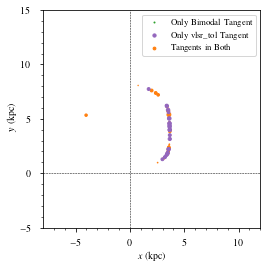

Num bimodal sources with vlsr w/in 20 km/s of v_tangent: 72


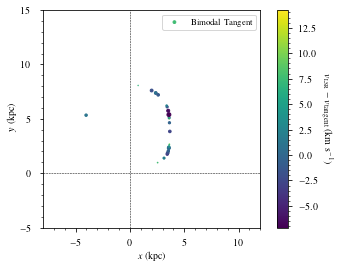

Num vlsr_tol sources with vlsr w/in 20 km/s of v_tangent: 72


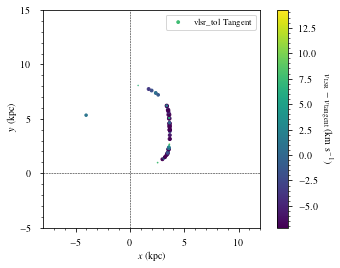

False
Num bimodal sources that are not tangent but would be classified as tangent using vlsr_tol (and not unreliable): 23
Stats related to this subset:
Closest vlsr < vlsr_tangent in q1: -3.51430555866618 
Corresponding gname: [['G075.78+00.34']] 
Corresponding index: [[  0 145]]
No vlsr > vlsr_tangent in q4


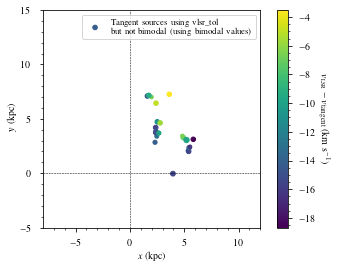

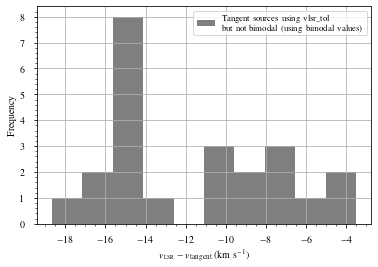

In [81]:
# %matplotlib inline
bimodal_input = "bimodal_1000x_pecTrue_krigeTrue_norm20_trough0.5.pkl"
vlsr_tol_input = "vlsrtol_1000x_pecTrue_krigeTrue_norm20_vlsrTolerance20.pkl"
# bimodal_input = "bimodal_1000x_pecTrue_krigeFalse_trough0.2.pkl"
# vlsr_tol_input = "vlsrtol_1000x_pecTrue_krigeFalse_vlsrTolerance20.pkl"
bimodal_vlsr_diffs(bimodal_input, vlsr_tol_input, save_figs=False)

Number of bimodal tangents: 0
Number of vlsr_tol tangents: 40
Number of tangents in both: 18


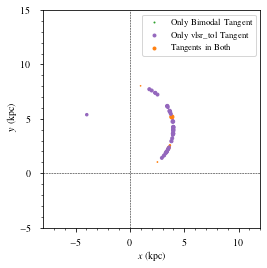

Num bimodal sources with vlsr w/in 20 km/s of v_tangent: 71


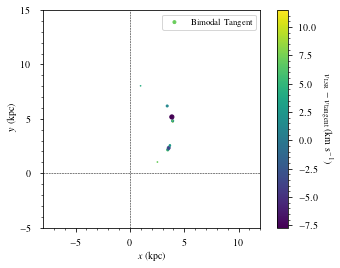

Num vlsr_tol sources with vlsr w/in 20 km/s of v_tangent: 71


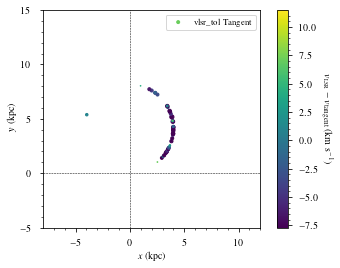

Num bimodal sources that are not tangent but would be classified as tangent using vlsr_tol (and not unreliable): 40
Stats related to this subset:
Closest vlsr < vlsr_tangent in q1: -0.03340630205587303 
Corresponding index: [[6]]
No vlsr > vlsr_tangent in q4


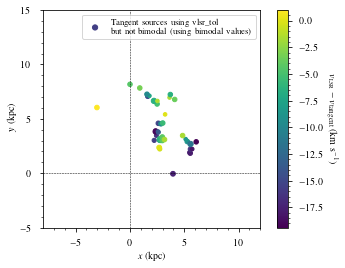

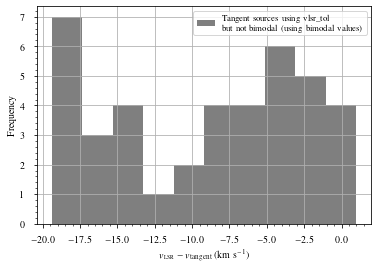

In [79]:
bimodal_input = "bimodal_1000x_pecTrue_krigeFalse_trough0.2.pkl"
vlsr_tol_input = "vlsrtol_1000x_pecTrue_krigeFalse_vlsrTolerance20.pkl"
bimodal_vlsr_diffs(bimodal_input, vlsr_tol_input, save_figs=False)

## Misc Code

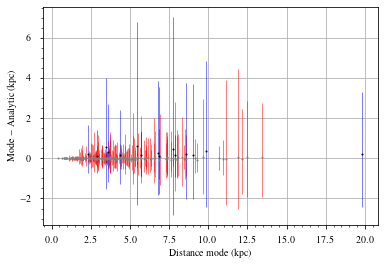

--- Big Diff Sources (15 sources with difference > 0.1 kpc) ---
|    | gname         |     glong |       glat |   plx |   e_plx |   dist_mode |   dist_halfhpd |   is_tooclose |   is_outlier |
|---:|:--------------|----------:|-----------:|------:|--------:|------------:|---------------:|--------------:|-------------:|
|  2 | G000.37+00.03 |  0.375871 |  0.0399829 | 0.125 |   0.047 |     6.77013 |        2.85918 |             1 |            0 |
|  4 | G001.00-00.23 |  1.00801  | -0.236915  | 0.09  |   0.057 |     7.75945 |        4.92092 |             1 |            0 |
|  5 | G001.14-00.12 |  1.14686  | -0.124515  | 0.194 |   0.161 |     3.47992 |        2.74752 |             0 |            1 |
|  6 | G002.70+00.04 |  2.70333  |  0.0400842 | 0.101 |   0.105 |     5.45535 |        4.56096 |             1 |            0 |
|  7 | G009.21-00.20 |  9.2145   | -0.201784  | 0.303 |   0.096 |     2.92183 |        1.05955 |             0 |            0 |
| 20 | G022.35+00.06 | 22.3565   |  0.06

In [17]:
plxfile = Path.cwd().parent / Path("pec_motions/csvfiles/alldata_HPDmode_NEW2.csv")
plxdata = pd.read_csv(plxfile)
plx = plxdata["plx"].values
e_plx = plxdata["e_plx"].values
peak_dist = trans.parallax_to_dist(plx, e_parallax=e_plx)
dist_mode = plxdata["dist_mode"].values
dist_hpdlow = plxdata["dist_hpdlow"].values
dist_hpdhigh = plxdata["dist_hpdhigh"].values
low_err = dist_mode - dist_hpdlow
high_err = dist_hpdhigh - dist_mode
errs = np.vstack((low_err, high_err))
diff = dist_mode - peak_dist
big_diff_threshold = 0.1  # kpc
big_diff = diff > big_diff_threshold
errs_small_diff = errs[:, ~big_diff]
errs_big_diff = errs[:, big_diff]
# 
fig, ax = plt.subplots()
ax.errorbar(dist_mode[~big_diff], diff[~big_diff], yerr=errs_small_diff,
            fmt=".", markersize=2,
            color="grey", ecolor="r", elinewidth=0.5)
ax.errorbar(dist_mode[big_diff], diff[big_diff], yerr=errs_big_diff,
            fmt=".", markersize=2,
            color="k", ecolor="b", elinewidth=0.5)
ax.set_xlabel("Distance mode (kpc)")
ax.set_ylabel("Mode $-$ Analytic (kpc)")
plt.show()
# 
fields = ["gname", "glong", "glat", "plx", "e_plx", "dist_mode", "dist_halfhpd", "is_tooclose", "is_outlier"]
print(f"--- Big Diff Sources ({sum(big_diff)} sources with difference > {big_diff_threshold} kpc) ---")
print(plxdata[fields][big_diff].to_markdown())  # leftmost column is index (from zero)
print(diff[big_diff])
# 
# print(f"--- Small Diff Sources ({sum(~big_diff)} sources with difference < {big_diff_threshold} kpc) ---")
# print(plxdata[fields][~big_diff].to_markdown())  # leftmost column is index (from zero)